# Projet n°5 : Segmentez des clients d'un site e-commerce - Phase Exploratoire

Nous sommes missionnés par la société Olist, pour faire une segmentation de leurs clients e-commerce, pour contribuer à aider leurs équipes opérationnelles de campagne de communication. 
Nous avons à disposition une base de données SQL stockant l'ensemble des données liées aux ventes, aux produits, aux vendeurs, aux commandes & les clients de Olist.
Cette mission est composée de plusieurs sous-missions, et s'articulera autour de plusieurs tâches, naviguant entre SQlite & les notebook.
- Répondre aux besoins urgents de création de quatre requêtes SQL pour alimenter le dashboard des équipes opérationnelles.
  

**Synthèse sur la RFM, qui sera une base pour notre segmentation basée sur la RFM.**

**- Champions :**

KPIs : Récence faible, Fréquence élevée, Valeur Monétaire élevée.
Clients les plus précieux, achètent souvent et dépensent beaucoup.

**- Loyaux :**

KPIs : Fréquence élevée, Valeur Monétaire élevée, Récence moyenne.
Clients réguliers et fidèles avec une histoire d'achats rentables.

**- Loyaux Potentiels :**

KPIs : Récence élevée, Fréquence élevée, Valeur Monétaire moyenne.
Clients récents et réguliers, mais n'ont pas encore dépensé autant.

**- A Réactiver :**

KPIs : Récence faible, Fréquence moyenne à faible, Valeur Monétaire moyenne à élevée.
Clients inactifs mais avec un historique d'achats, nécessitent un rappel.

**- A Risque :**

KPIs : Récence en baisse, Fréquence en baisse, Valeur Monétaire en baisse.
Clients en déclin, nécessitant une réengagement pour éviter la perte.

**- Perdus :**

KPIs : Récence très élevée, Fréquence très faible, Valeur Monétaire très faible.
Clients inactifs depuis longtemps, considérés comme perdus pour l'entreprise.

**Pour guider notre étude, les différents types de KPI seront les suivants :**

- Fréquence
- Récence
- Livraison
- Les produits achetés
- La localisation
- Valeur et paiement
- Satisfaction

# I. Importation des librairies & des données

## 1. Importer les librairies

In [1]:
# Librairies de base python 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import table
import missingno as msno
import math
import sqlite3

# Projection sur une cartographie
import folium
import folium.plugins
from folium.plugins import HeatMap
import geopandas as gpd

# Analyse statistique
from scipy import stats
from scipy.stats import norm
import statsmodels.formula.api as smf

# Scikit-Learn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## 2. Importer les données de la base SQL

In [2]:
# Chemin vers votre fichier de base de données
db_path = r'C:\Users\justi\OneDrive\Cours - Travail\DATA SCIENCE\Formation - DataScientist\Projet n°5\NOTEBOOK - DATA\olist.db'

# Connexion à la base de données
conn = sqlite3.connect(db_path)

# Utiliser pandas pour lire les données de la base de données dans un DataFrame
df_customers = pd.read_sql_query("SELECT * FROM customers", conn)
df_geoloc = pd.read_sql_query("SELECT * FROM geoloc",conn)
df_order_items = pd.read_sql_query("SELECT * FROM order_items",conn)
df_order_pymts = pd.read_sql_query("SELECT * FROM order_pymts",conn)
df_order_reviews = pd.read_sql_query("SELECT * FROM order_reviews",conn)
df_orders = pd.read_sql_query("SELECT * FROM orders",conn)
df_products = pd.read_sql_query("SELECT * FROM products",conn)
df_sellers = pd.read_sql_query("SELECT * FROM sellers",conn)
df_translation = pd.read_sql_query("SELECT * FROM translation",conn)

# Fermer la connexion à la base de données
conn.close()

# II. Vision des datasets importés

## 1. Structures des dataframes importés

In [24]:
# Initialiser une liste des dataframes
liste_df = [df_customers,
            df_geoloc,
            df_order_items,
            df_order_pymts,
            df_order_reviews,
            df_orders,
            df_products,
            df_sellers,
            df_translation]

liste_df_names = ['df_customers',
                  'df_geoloc',
                  'df_order_items',
                  'df_order_pymts',
                  'df_order_reviews',
                  'df_orders',
                  'df_products',
                  'df_sellers',
                  'df_translation']

# Afficher la structure des dataframes avec leur nom
for df, nom_df in zip(liste_df, liste_df_names):
    print("Structure de", nom_df, ":", df.shape)

Structure de df_customers : (99441, 6)
Structure de df_geoloc : (1000163, 6)
Structure de df_order_items : (112650, 8)
Structure de df_order_pymts : (103886, 6)
Structure de df_order_reviews : (99224, 8)
Structure de df_orders : (99441, 9)
Structure de df_products : (32951, 10)
Structure de df_sellers : (3095, 5)
Structure de df_translation : (71, 3)


In [4]:
# Afficher le taux de remplissage global des fichier
taux_global = sum(df.count().sum() for df in liste_df) / sum(df.shape[0] * df.shape[1] for df in liste_df) * 100
print(f"Taux de remplissage global de la database: {taux_global:.2f}%")

Taux de remplissage global de la database: 98.49%


In [5]:
# Afficher le taux de remplissage pour chaque dataframe
for df, nom_df in zip(liste_df, liste_df_names):
    taux_remplissage = df.count().sum() / (df.shape[0] * df.shape[1]) * 100
    print(f"{nom_df}: {taux_remplissage:.2f}%")

df_customers: 100.00%
df_geoloc: 100.00%
df_order_items: 100.00%
df_order_pymts: 100.00%
df_order_reviews: 81.62%
df_orders: 99.45%
df_products: 99.26%
df_sellers: 100.00%
df_translation: 100.00%


In [6]:
# Afficher les infos des colonnes des dataframes
for df in liste_df:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     99441 non-null  int64 
 1   customer_id               99441 non-null  object
 2   customer_unique_id        99441 non-null  object
 3   customer_zip_code_prefix  99441 non-null  int64 
 4   customer_city             99441 non-null  object
 5   customer_state            99441 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 6 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   index                        1000163 non-null  int64  
 1   geolocation_zip_code_prefix  1000163 non-null  int64  
 2   geolocation_lat              1000163 non-null  float6

In [7]:
# Synthèse des structures des dataframes
liste_noms_df = ['df_customers',
                 'df_geoloc',
                 'df_order_items',
                 'df_order_pymts',
                 'df_order_reviews',
                 'df_orders',
                 'df_products',
                 'df_sellers',
                 'df_translation']

liste_indices = []
liste_colonnes = []
liste_types = []
liste_uniques = []
liste_taux_remplissage = []

for df, nom_df in zip(liste_df, liste_noms_df):
    for column in df.columns:
        liste_indices.append(nom_df)
        liste_colonnes.append(column)
        liste_types.append(df[column].dtype)
        liste_uniques.append(df[column].nunique())
        taux_remplissage = df[column].count() / len(df) * 100
        liste_taux_remplissage.append(f"{taux_remplissage:.2f}%")

synthese_data = pd.DataFrame({
    'Données': liste_indices,
    'Nom colonne': liste_colonnes,
    'Type': liste_types,
    'Valeurs uniques': liste_uniques,
    'Taux de remplissage': liste_taux_remplissage
})

synthese_data.head(60)

Données                    Nom colonne     Type  Valeurs uniques  \
0       df_customers                          index    int64            99441   
1       df_customers                    customer_id   object            99441   
2       df_customers             customer_unique_id   object            96096   
3       df_customers       customer_zip_code_prefix    int64            14994   
4       df_customers                  customer_city   object             4119   
5       df_customers                 customer_state   object               27   
6          df_geoloc                          index    int64          1000163   
7          df_geoloc    geolocation_zip_code_prefix    int64            19015   
8          df_geoloc                geolocation_lat  float64           717360   
9          df_geoloc                geolocation_lng  float64           717613   
10         df_geoloc               geolocation_city   object             8011   
11         df_geoloc              geolocation_state   object               27   
12    df_order_items                          index    int64           112650   
13    df_order_items                       order_id   object            98666   
14    df_order_items                  order_item_id    int64               21   
15    df_order_items                     product_id   object            32951   
16    df_order_items                      seller_id   object             3095   
17    df_order_items            shipping_limit_date   object            93318   
18    df_order_items                          price  float64             5968   
19    df_order_items                  freight_value  float64             6999   
20    df_order_pymts                          index    int64           103886   
21    df_order_pymts                       order_id   object            99440   
22    df_order_pymts             payment_sequential    int64               29   
23    df_order_pymts                   payment_type   object                5   
24    df_order_pymts           payment_installments    int64               24   
25    df_order_pymts                  payment_value  float64            29077   
26  df_order_reviews                          index    int64            99224   
27  df_order_reviews                      review_id   object            98410   
28  df_order_reviews                       order_id   object            98673   
29  df_order_reviews                   review_score    int64                5   
30  df_order_reviews           review_comment_title   object             4527   
31  df_order_reviews         review_comment_message   object            36159   
32  df_order_reviews           review_creation_date   object              636   
33  df_order_reviews        review_answer_timestamp   object            98248   
34         df_orders                          index    int64            99441   
35         df_orders                       order_id   object            99441   
36         df_orders                    customer_id   object            99441   
37         df_orders                   order_status   object                8   
38         df_orders       order_purchase_timestamp   object            98875   
39         df_orders              order_approved_at   object            90733   
40         df_orders   order_delivered_carrier_date   object            81018   
41         df_orders  order_delivered_customer_date   object            95664   
42         df_orders  order_estimated_delivery_date   object              459   
43       df_products                          index    int64            32951   
44       df_products                     product_id   object            32951   
45       df_products          product_category_name   object               73   
46       df_products            product_name_lenght  float64               66   
47       df_products     product_description_lenght  float64             2960   
48       df_products             product_pho

In [8]:
# Filtrer les lignes où le taux de remplissage n'est pas égal à 100%
synthese_data_incomplete = synthese_data[synthese_data['Taux de remplissage'] != '100.00%']

# Afficher le DataFrame filtré
synthese_data_incomplete

Données                    Nom colonne     Type  Valeurs uniques  \
30  df_order_reviews           review_comment_title   object             4527   
31  df_order_reviews         review_comment_message   object            36159   
39         df_orders              order_approved_at   object            90733   
40         df_orders   order_delivered_carrier_date   object            81018   
41         df_orders  order_delivered_customer_date   object            95664   
45       df_products          product_category_name   object               73   
46       df_products            product_name_lenght  float64               66   
47       df_products     product_description_lenght  float64             2960   
48       df_products             product_photos_qty  float64               19   
49       df_products               product_weight_g  float64             2204   
50       df_products              product_length_cm  float64               99   
51       df_products              product_height_cm  float64              102   
52       df_products               product_width_cm  float64               95   

   Taux de remplissage  
30              11.66%  
31              41.30%  
39              99.84%  
40              98.21%  
41              97.02%  
45              98.15%  
46              98.15%  
47              98.15%  
48              98.15%  
49              99.99%  
50              99.99%  
51              99.99%  
52              99.99%

**Synthèse sur les données :**
- 99 941 clients uniques concernés
- 98 666 commandes distinctes 
- 112 650 produits vendus
- 3 095 vendeurs
- 32 951 produits
- 71 catégories de produits

## 2. Gestion & analyse des valeurs manquantes

Nous remarquons que nous avons trois tables concernées par des valeurs manquantes.
Pour les deux tables suivantes : 
- df_order_reviews
- df_orders

Les données manquantes sont compréhensibles et "normales".
Pour la table des commentaires cela est lié au fait que les clients ne laissent pas toujours de commentaires suite à une commande et peuvent juste laisser une note, la review_score, nous ne pouvons donc rien faire et finalement ne pas laisser de commentaires est une donnée à prendre à compte dans notre analyse.
Pour la table des commandes, df_orders, nous sommes dans la situation où des commandes sont prises mais ne sont pas encore au stade du transport, ou encore arrivées chez le client, il est donc logique de ne pas avoir de date dans ces colonnes. Là encore, nous ne pouvons rien, sachant que nous filtrerons nos données sur les commandes 'delivered'

Enfin la dernière table concerne les produits. Nous sommes dans la situation où il nous manque des données liées au produits, qui risquent d'être complexes voir impossible à imputer de manière pertinente.
Nous verrons à la fin de partie suivante, après les aggrégations & les jointures si cela nous pose problème ou non.


## 3. Requalification des catégories produits & des régions du Brésil

### a. Les catégories produits

In [25]:
# Faire apparaître les catégories présentes dans le dataframe translation
all_cat = df_translation['product_category_name_english'].unique()
print(all_cat)

['health_beauty' 'computers_accessories' 'auto' 'bed_bath_table'
 'furniture_decor' 'sports_leisure' 'perfumery' 'housewares' 'telephony'
 'watches_gifts' 'food_drink' 'baby' 'stationery' 'tablets_printing_image'
 'toys' 'fixed_telephony' 'garden_tools' 'fashion_bags_accessories'
 'small_appliances' 'consoles_games' 'audio' 'fashion_shoes' 'cool_stuff'
 'luggage_accessories' 'air_conditioning'
 'construction_tools_construction'
 'kitchen_dining_laundry_garden_furniture' 'costruction_tools_garden'
 'fashion_male_clothing' 'pet_shop' 'office_furniture' 'market_place'
 'electronics' 'home_appliances' 'party_supplies' 'home_confort'
 'costruction_tools_tools' 'agro_industry_and_commerce'
 'furniture_mattress_and_upholstery' 'books_technical' 'home_construction'
 'musical_instruments' 'furniture_living_room' 'construction_tools_lights'
 'industry_commerce_and_business' 'food' 'art' 'furniture_bedroom'
 'books_general_interest' 'construction_tools_safety'
 'fashion_underwear_beach' 'fashion_

In [26]:
# Regroupement de certaines catégories avoir des groupes logiques
categories_translation = {
    
# Fashion_Clothing
    'fashion_bags_accessories': 'Fashion_Clothing',
    'fashion_shoes': 'Fashion_Clothing',
    'fashion_male_clothing': 'Fashion_Clothing',
    'fashion_underwear_beach': 'Fashion_Clothing',
    'fashion_sport': 'Fashion_Clothing',
    'fashion_female_clothing': 'Fashion_Clothing',
    'fashion_childrens_clothes': 'Fashion_Clothing',
    'fashio_female_clothing':'Fashion_Clothing',
    
# Home_Furniture    
    'furniture_decor': 'Home_Furniture',
    'bed_bath_table': 'Home_Furniture',
    'housewares': 'Home_Furniture',
    'home_appliances': 'Home_Furniture',
    'home_appliances_2': 'Home_Furniture',
    'furniture_bedroom': 'Home_Furniture',
    'furniture_living_room': 'Home_Furniture',
    'furniture_mattress_and_upholstery': 'Home_Furniture',
    'office_furniture' : 'Home_Furniture',
    'home_confort': 'Home_Furniture',
    'home_comfort_2': 'Home_Furniture',

# Electronics_Computers
    'computers_accessories': 'Electronics_Computers',
    'electronics': 'Electronics_Computers',
    'tablets_printing_image': 'Electronics_Computers',
    'telephony': 'Electronics_Computers',
    'small_appliances': 'Electronics_Computers',
    'small_appliances_home_oven_and_coffee': 'Electronics_Computers',
    'fixed_telephony': 'Electronics_Computers',
    'computers': 'Electronics_Computers',
    'consoles_games': 'Electronics_Computers',

# Entertainment 
    'sports_leisure': 'Entertainment',
    'musical_instruments': 'Entertainment',
    'cds_dvds_musicals': 'Entertainment',
    'dvds_blu_ray': 'Entertainment',
    'cine_photo': 'Entertainment',
    'music': 'Entertainment',
    'audio': 'Entertainment',
    'art' : 'Entertainment',
    'books_technical': 'Entertainment',
    'books_general_interest': 'Entertainment',
    'books_imported': 'Entertainment',
    'stationery': 'Entertainment',
    
# Food_drink   
    'food_drink': 'Food_Drink',
    'food': 'Food_Drink',
    'drinks': 'Food_Drink',
    'la_cuisine': 'Food_Drink',

# Home_Garden
    'garden_tools': 'Home_Garden',
    'kitchen_dining_laundry_garden_furniture': 'Home_Garden',
    'costruction_tools_garden': 'Home_Garden',
    
# Automotive    
    'auto': 'Automotive',
    'air_conditioning': 'Automotive',
    'construction_tools_safety': 'Automotive',

# Health_Beauty
    'health_beauty': 'Health_Beauty',
    'perfumery': 'Health_Beauty',
    'diapers_and_hygiene': 'Health_Beauty',

# Baby_Kids
    'baby': 'Baby_Kids',
    'pet_shop': 'Baby_Kids',
    'diapers_and_hygiene': 'Baby_Kids',
    'toys': 'Baby_Kids',
    'fashion_childrens_clothes': 'Baby_Kids',

# Tools_Construction
    'construction_tools_construction': 'Tools_Construction',
    'costruction_tools_garden': 'Tools_Construction',
    'costruction_tools_tools': 'Tools_Construction',
    'construction_tools_lights': 'Tools_Construction',
    'construction_tools_safety': 'Tools_Construction',
    'construction_tools_construction': 'Tools_Construction',
    'construction_tools_lights': 'Tools_Construction',
    'home_construction': 'Tools_Construction',

# Miscellaneous    
    'cool_stuff': 'Miscellaneous',
    'luggage_accessories': 'Miscellaneous',
    'market_place': 'Miscellaneous',
    'party_supplies': 'Miscellaneous',
    'arts_and_craftmanship': 'Miscellaneous',
    'industry_commerce_and_business': 'Miscellaneous',
    'agro_industry_and_commerce': 'Miscellaneous',
    'signaling_and_security': 'Miscellaneous',
    'security_and_services': 'Miscellaneous',
    'christmas_supplies': 'Miscellaneous',
    'flowers': 'Miscellaneous',
    'watches_gifts': 'Miscellaneous',
}

# Ajout de la nouvelle colonne 'product_category_name_grouped' au dataframe
df_translation['main_category_name'] = df_translation['product_category_name_english'].map(categories_translation)

### b. Les régions du Brésil

In [27]:
# Dictionnaire des équivalences
regions_bresil = {
    "AC": "Acre",
    "AL": "Alagoas",
    "AP": "Amapá",
    "AM": "Amazonas",
    "BA": "Bahia",
    "CE": "Ceará",
    "DF": "District fédéral",
    "ES": "Espirito Santo",
    "GO": "Goiás",
    "MA": "Maranhão",
    "MT": "Mato Grosso",
    "MS": "Mato Grosso do Sul",
    "MG": "Minas Gerais",
    "PA": "Pará",
    "PB": "Paraíba",
    "PR": "Paraná",
    "PE": "Pernambouc",
    "PI": "Piauí",
    "RJ": "Rio de Janeiro",
    "RN": "Rio Grande do Norte",
    "RS": "Rio Grande do Sul",
    "RO": "Rondônia",
    "RR": "Roraima",
    "SC": "Santa Catarina",
    "SP": "São Paulo",
    "SE": "Sergipe",
    "TO": "Tocantins"
}

# Ajout de la nouvelle colonne dans le df
df_geoloc['geolocation_region'] = df_geoloc['geolocation_state'].map(regions_bresil)

# Suppression de la colonne geolocation_state
df_geoloc.drop(columns=['geolocation_state'], inplace=True)

# Renommer la colonne geolocation_region en geolocation_state
df_geoloc.rename(columns={'geolocation_region': 'geolocation_state'}, inplace=True)


# III. Création de nouveaux datasets pour agréger les données

Dans nos bases de données, il y a trois niveaux d'échantillonage principaux:

**Le premier niveau est une ligne égale à un produit avec les deux tables suivantes :**
- df_products 
- df_orders_items
- la clé de recoupement est product_id

Nous allons pouvoir utiliser la colonne order_id pour faire aggrégation et monter d'un niveau dans la hiérarchie.

**A l'issue de ces transformation nous aurons un df_commandes_produits qui compilera les données de ce niveau**

**Le second niveau correspond à une ligne égale une commande, voici les tables correspondantes :**
- df_commandes_produits
- df_order
- df_order_reviews
- df_order_pymts
- la clé de recoupement est order_id

**A l'issue de ces transformations, nous aurons un df_commandes qui compilera les données de ce niveau**

**Le troisième niveau correspond à l'équivalence au niveau du customers / clients**

Les tables correspondantes :

- df_customers
- df_commandes (agrégée sur la colonne customer_id
- la clé de recoupement est customer_id

L'agrégation finale sera sur les customer_unique_id.

## 1. Premier niveau d'agrégation : Commandes / Produits

Trois étapes principales :
- faire la jointure gauche des datasets
- importer la colonne de la table 'translation' pour avoir le traduction des labels sur les produits
- faire une agrégation sur la colonne order_id

### a. Faire les jointures entre les deux tables 'df_order_items' & df_products'

In [28]:
# Jointure entre les deux tables où la table products vient compléter la table order_items
df_commandes_produits = pd.merge(df_order_items, df_products, how='left', on='product_id')

In [29]:
# Jointure entre les deux tables pour importer la colonne traduite translation
df_commandes_produits = pd.merge(df_commandes_produits, df_translation, how='left', on='product_category_name')

In [30]:
# Vérification concernant la présence de valeurs nulles
nombre_valeurs_nulles = df_commandes_produits.isnull().sum()
print(nombre_valeurs_nulles)

index_x                             0
order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
index_y                             0
product_category_name            1603
product_name_lenght              1603
product_description_lenght       1603
product_photos_qty               1603
product_weight_g                   18
product_length_cm                  18
product_height_cm                  18
product_width_cm                   18
index                            1627
product_category_name_english    1627
main_category_name               1627
dtype: int64


Pour les variables concernant le poids et les dimensions nous allons faire une imputation avec la médiane, ainsi que la description du produit.
Pour la colonne catégorielle, nous allons remplacer par 'Other'

In [31]:
# Remplacer les valeurs nulles par NaN dans le DataFrame
df_commandes_produits.replace('', np.nan, inplace=True)

In [32]:
# Créer une instance SimpleImputer avec la stratégie 'median'
imputer = SimpleImputer(strategy='median')

# Sélectionner les colonnes numériques pour l'imputation
colonnes_numeriques = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_description_lenght']

# Imputer les valeurs manquantes dans les colonnes numériques avec la médiane
df_commandes_produits[colonnes_numeriques] = imputer.fit_transform(df_commandes_produits[colonnes_numeriques])

In [33]:
# Remplacer les valeurs nulles dans la colonne 'main_category_name' par 'Other' 
df_commandes_produits['main_category_name'] = df_commandes_produits['main_category_name'].fillna('Other')

In [34]:
# Calcul du volume des produits
df_commandes_produits['product_volume_cm3'] = df_commandes_produits['product_length_cm']*df_commandes_produits['product_height_cm']*df_commandes_produits['product_width_cm']

# Suppression des colonnes non-utiles
drop_column = ['index',
               'index_x',
               'index_y',
               'product_photos_qty',
               'product_length_cm',
               'product_height_cm',
               'product_width_cm',
               'product_category_name',
               'product_category_name_english',
               'product_name_lenght',
               'shipping_limit_date',
               'seller_id']

df_commandes_produits = df_commandes_produits.drop(drop_column, axis =1)

Avant de faire la première agrégation, je vais encoder ma variable catégorielle, ainsi je ne perdrais pas d'information avec l'opération d'agrégation. Et pour lui donner un poids relatif au prix de l'article, je vais multiplier par le prix de celui-ci. Ainsi, je pourrai faire mon agrégation en faisant la somme et je ne perdrai pas d'information lors de cette opération.

In [41]:
sumprice = df_commandes_produits['price'].sum()
print(sumprice)

13591643.700000003


In [42]:
# Créer des variables encodées à partir de la colonne 'main_category_name'
cat_main_df = pd.get_dummies(df_commandes_produits['main_category_name'], prefix='cat')

In [43]:
df_commandes_produits

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       00018f77f2f0320c557190d7a144bdd3              1   
2       000229ec398224ef6ca0657da4fc703e              1   
3       00024acbcdf0a6daa1e931b038114c75              1   
4       00042b26cf59d7ce69dfabb4e55b4fd9              1   
...                                  ...            ...   
112645  fffc94f6ce00a00581880bf54a75a037              1   
112646  fffcd46ef2263f404302a634eb57f7eb              1   
112647  fffce4705a9662cd70adb13d4a31832d              1   
112648  fffe18544ffabc95dfada21779c9644f              1   
112649  fffe41c64501cc87c801fd61db3f6244              1   

                              product_id   price  freight_value  \
0       4244733e06e7ecb4970a6e2683c13e61   58.90          13.29   
1       e5f2d52b802189ee658865ca93d83a8f  239.90          19.93   
2       c777355d18b72b67abbeef9df44fd0fd  199.00          17.87   
3       7634da152a4610f1595efa32f14722fc   12.99          12.79   
4       ac6c3623068f30de03045865e4e10089  199.90          18.14   
...                                  ...     ...            ...   
112645  4aa6014eceb682077f9dc4bffebc05b0  299.99          43.41   
112646  32e07fd915822b0765e448c4dd74c828  350.00          36.53   
112647  72a30483855e2eafc67aee5dc2560482   99.90          16.95   
112648  9c422a519119dcad7575db5af1ba540e   55.99           8.72   
112649  350688d9dc1e75ff97be326363655e01   43.00          12.79   

        product_description_lenght  product_weight_g     main_category_name  \
0                            598.0             650.0          Miscellaneous   
1                            239.0           30000.0              Baby_Kids   
2                            695.0            3050.0         Home_Furniture   
3                            480.0             200.0          Health_Beauty   
4                            409.0            3750.0            Home_Garden   
...                            ...               ...                    ...   
112645                      1002.0           10150.0         Home_Furniture   
112646                       232.0            8950.0  Electronics_Computers   
112647                       869.0             967.0          Entertainment   
112648                      1306.0             100.0  Electronics_Computers   
112649                       511.0             600.0         Home_Furniture   

        product_volume_cm3  
0                   3528.0  
1                  60000.0  
2                  14157.0  
3                   2400.0  
4                  42000.0  
...                    ...  
112645             53400.0  
112646             44460.0  
112647              9576.0  
112648              8000.0  
112649              1710.0  

[112650 rows x 9 columns]

In [47]:
cat_main_df.head(2)

cat_Automotive  cat_Baby_Kids  cat_Electronics_Computers  \
0             0.0            0.0                        0.0   
1             0.0          239.9                        0.0   

   cat_Entertainment  cat_Fashion_Clothing  cat_Food_Drink  cat_Health_Beauty  \
0                0.0                   0.0             0.0                0.0   
1                0.0                   0.0             0.0                0.0   

   cat_Home_Furniture  cat_Home_Garden  cat_Miscellaneous  cat_Other  \
0                 0.0              0.0               58.9        0.0   
1                 0.0              0.0                0.0        0.0   

   cat_Tools_Construction  
0                     0.0  
1                     0.0

In [45]:
# Multiplier chaque colonne de la matrice de variables encodées, par les valeurs de la colonne 'price'
cat_main_df = cat_main_df.mul(df_commandes_produits['price'], axis=0)

# Concaténer les colonnes encodées avec le DataFrame d'origine
df_commandes_produits = pd.concat([df_commandes_produits, cat_main_df], axis=1)

### b. Les agrégations sur l'order_id pour le dataframe 'commandes_produits'

Nous allons pouvoir faire une agrégation sur notre colonne 'order_id' à ce stade.
Nous allons avoir des transformations de variables qui vont en découler :
- Le max de 'order_item_id' par commande distincte
- La somme de 'price'
- La somme de 'freight_value'
- La moyenne de 'product_description_lenght'
- La moyenne de 'product_weigh_g'
- La moyenne de 'product_volume_cm3'
- Pour mes colonnes encodées 'cat' je vais faire la sommme

In [48]:
# Agrégation des données
cat_columns = [col for col in df_commandes_produits.columns if col.startswith('cat')]
aggregation_dict = {
    'order_item_id': 'max',
    'price': 'sum',
    'freight_value': 'sum',
    'product_description_lenght': 'mean',
    'product_weight_g': 'mean',
    'product_volume_cm3': 'mean'
}

# Ajout de la somme pour les colonnes 'cat' en ignorant les NaN
aggregation_dict.update({col: lambda x: x.sum(skipna=True) for col in cat_columns})

df_commandes_produits = df_commandes_produits.groupby('order_id').agg(aggregation_dict)

# Réinitialisation de l'index
df_commandes_produits.reset_index(inplace=True)

# Renommer les colonnes
df_commandes_produits = df_commandes_produits.reset_index().rename(columns={
    'order_item_id': 'total_items',
    'price': 'total_price',
    'freight_value': 'total_freight_value',
    'product_description_lenght': 'avg_product_description_length',
    'product_weight_g': 'avg_product_weight_g',
    'product_volume_cm3': 'avg_product_volume_cm3',
})


In [49]:
# Vérification si perte d'information au cours de l'aggrégation pour la somme des prix
cat_columns = [col for col in df_commandes_produits.columns if col.startswith('cat')]

# Faire la somme de ces colonnes
sum_cat_columns = df_commandes_produits[cat_columns].sum()

# Faire la somme de la colonne total_price
sumtotalprice = round(df_commandes_produits['total_price'].sum(),2)

# Somme totale des prix des colonnes encodées
sum_price_col_enc = round(sum_cat_columns.sum(), 2)

# Somme du nombre maximal d'articles par commande dans df_commandes_produits
sumArtCommandeProd = df_commandes_produits['total_items'].sum()

# Somme des articles vendus dans df_order_items
sumArtOrderItems = df_order_items.groupby('order_id')['order_item_id'].max().sum()

# Vérification de la perte d'information
if sum_price_col_enc == sumtotalprice: 
    print("Aucune perte d'information sur la somme de price.")
else:
    print("Perte d'information sur la colonne price.")
    
if sumArtCommandeProd == sumArtOrderItems:
    print("Aucune perte d'information sur le nombre d'articles.")
else:
    print("Perte d'information sur le nombre d'articles.")


Aucune perte d'information sur la somme de price.
Aucune perte d'information sur le nombre d'articles.


## 2. Second niveau d'agrégation : "Commandes"

Dans cette partie, nous allons reprendre le dataframe créé dans la partie précédent, où nous sommes passés du niveau produit, au niveau commandes.
Nous allons ainsi pouvoir relier les autres tables étant à l'unité de la commande.
Nous allons faire une jointure entre les tables suivantes :

- df_commandes_produits
- df_order_pymts
- df_order_reviews
- df_order

### a. Analyse des doublons sur order_id & jointures des dataframes

Nous n'avons pas le même nombre de lignes entre les différentes tables. Nous allons regarder dans un premier temps s'il y a des tables avec des doublons pour la colonne order_id.

In [50]:
# Définir une fonction pour calculer le nombre de lignes et de valeurs uniques dans la colonne 'order_id'
def count_order_id_info(df):
    num_rows = len(df)
    num_unique_order_id = df['order_id'].nunique()
    return num_rows, num_unique_order_id

# Créer une liste de tuples contenant les noms des dataframes et les dataframes eux-mêmes
dataframes = [
    ('df_commandes_produits', df_commandes_produits),
    ('df_order_pymts', df_order_pymts),
    ('df_order_reviews', df_order_reviews),
    ('df_order', df_orders)
]

# Parcourir la liste de tuples et afficher les informations pour chaque dataframe
for df_name, df in dataframes:
    num_rows, num_unique_order_id = count_order_id_info(df)
    print(f"{df_name} :")
    print("Nombre de lignes :", num_rows)
    print("Nombre de valeurs uniques dans 'order_id' :", num_unique_order_id)
    print()


df_commandes_produits :
Nombre de lignes : 98666
Nombre de valeurs uniques dans 'order_id' : 98666

df_order_pymts :
Nombre de lignes : 103886
Nombre de valeurs uniques dans 'order_id' : 99440

df_order_reviews :
Nombre de lignes : 99224
Nombre de valeurs uniques dans 'order_id' : 98673

df_order :
Nombre de lignes : 99441
Nombre de valeurs uniques dans 'order_id' : 99441



Nous remarquons qu'il y a des écarts entre les tables en termes du nombre de n° de commandes, qui indiquent la présence de doublons dans certaines, les tables concernées sont :
- order_pymts
- order_reviews

**Gestion des doublons pour la table 'order_pymts'**

In [51]:
# Infos sur order_pymnts
summary_pymts = df_order_pymts.describe(include='all')
summary_pymts

index                          order_id  payment_sequential  \
count   103886.00000                            103886       103886.000000   
unique           NaN                             99440                 NaN   
top              NaN  fa65dad1b0e818e3ccc5cb0e39231352                 NaN   
freq             NaN                                29                 NaN   
mean     51942.50000                               NaN            1.092679   
std      29989.44937                               NaN            0.706584   
min          0.00000                               NaN            1.000000   
25%      25971.25000                               NaN            1.000000   
50%      51942.50000                               NaN            1.000000   
75%      77913.75000                               NaN            1.000000   
max     103885.00000                               NaN           29.000000   

       payment_type  payment_installments  payment_value  
count        103886         103886.000000  103886.000000  
unique            5                   NaN            NaN  
top     credit_card                   NaN            NaN  
freq          76795                   NaN            NaN  
mean            NaN              2.853349     154.100380  
std             NaN              2.687051     217.494064  
min             NaN              0.000000       0.000000  
25%             NaN              1.000000      56.790000  
50%             NaN              1.000000     100.000000  
75%             NaN              4.000000     171.837500  
max             NaN             24.000000   13664.080000

Nous avons une colonne catégorielle qui est 'payment_type' avec les catégories suivantes.

In [52]:
val_pay = df_order_pymts['payment_type'].unique()
print(val_pay)

['credit_card' 'boleto' 'voucher' 'debit_card' 'not_defined']


In [53]:
# Créer des variables encodées à partir de la colonne 'payment_type'
pay_type_df = pd.get_dummies(df_order_pymts['payment_type'], prefix='paytype')

# Multiplier chaque colonne de la matrice de variables encodées, par les valeurs de la colonne 'payment_sequential'
pay_type_df = pay_type_df.mul(df_order_pymts['payment_sequential'], axis=0)

# Concaténer les colonnes factices avec le DataFrame d'origine
df_order_pymts = pd.concat([df_order_pymts, pay_type_df], axis=1)

Nous avons éclaté la variable 'payment_type' avec 'get_dummies', pour avoir une variable booléenne pour chaque moyen de paiement, puis associer la colonne 'payment_sequential', qui permet de savoir combien il y a eu de séquence de paiement différentes sur la commande.

Nous avons des doublons au sein de cette table, nous allons faire une aggrégation sur la colonne order_id, pour remédier à cela.
Nous ferons les opérations suivantes :
- max pour 'payment_sequential'
- somme pour les colonnes 'paytype'
- somme pour 'payment_value'
- le plus fréquent sur la commande 'payment_type'
- max pour le 'payment_installments'

Je ne supprime pas tout de suite mes colonnes concernant le type de paiement utilisé, et le nombre de séquencement pour avoir ces colonnes pour l'analyse exploratoire. L'utilisation du 'get_dummies' est pour anticiper la partie modélisation en faisant en amont une partie du feature engineering.

In [54]:
# Agrégation des colonnes avec les règles spécifiées en amont sur le dataframe concernant les commentaires
df_order_pymts = df_order_pymts.groupby('order_id').agg({
    'payment_sequential': 'sum',
    'paytype_boleto': 'sum',
    'paytype_credit_card': 'sum',
    'paytype_debit_card': 'sum',
    'paytype_not_defined': 'sum',
    'paytype_voucher': 'sum',
    'payment_value': 'sum',
    'payment_type': lambda x: x.mode().iloc[0], 
    'payment_installments': 'max'
}).reset_index()

In [55]:
# Confirmation que notre aggrégation sur la colonne order_id a fonctionné
uniquevalue = df_order_pymts['order_id'].nunique()
print('Nombre de valeurs uniques pour order_id',uniquevalue)
print('Structure du dataframe',df_order_pymts.shape)

Nombre de valeurs uniques pour order_id 99440
Structure du dataframe (99440, 10)


**Gestion des doublons pour la table 'order_reviews'**

Concernant la table des commentaires, nous avons également des doublons concernant nos commandes. Une nouvelle fois, nous allons faire une aggrégation sur notre colonne order_id.
Nous allons procéder de la sorte : 
- supprimer les colonnes suivantes, | 'review_creation_date', 'review_comment_title', 'review_answer_timestamp', 'review_id'
- faire la moyenne pour le score, colonne 'review_score'
- le cumul du nombre de caractères dans le corps du commentaires, colonne 'review_comment_message'

Avant nous allons pouvoir calculer le temps de réponse entre l'émission de l'enquête de satisfaction & la réponse du client.

In [56]:
# Convertir les colonnes de type texte en objets datetime
df_order_reviews['review_creation_date'] = pd.to_datetime(df_order_reviews['review_creation_date'])
df_order_reviews['review_answer_timestamp'] = pd.to_datetime(df_order_reviews['review_answer_timestamp'])

# Calculer la différence entre les dates et extraire le nombre de jours
df_order_reviews['délaiSatisfaction'] = (df_order_reviews['review_answer_timestamp'] - df_order_reviews['review_creation_date']).dt.days

In [57]:
# Suppresion des colonnes utilisées ci-dessus
df_order_reviews = df_order_reviews.drop(columns=['review_creation_date', 'review_comment_title','review_answer_timestamp','review_id'])

In [58]:
# Infos sur order_reviews
summary_reviews = df_order_reviews.describe(include='all')
summary_reviews

index                          order_id  review_score  \
count   99224.000000                             99224  99224.000000   
unique           NaN                             98673           NaN   
top              NaN  c88b1d1b157a9999ce368f218a407141           NaN   
freq             NaN                                 3           NaN   
mean    49611.500000                               NaN      4.086421   
std     28643.645892                               NaN      1.347579   
min         0.000000                               NaN      1.000000   
25%     24805.750000                               NaN      4.000000   
50%     49611.500000                               NaN      5.000000   
75%     74417.250000                               NaN      5.000000   
max     99223.000000                               NaN      5.000000   

       review_comment_message  délaiSatisfaction  
count                   40977       99224.000000  
unique                  36159                NaN  
top                 Muito bom                NaN  
freq                      230                NaN  
mean                      NaN           2.582248  
std                       NaN           9.890526  
min                       NaN           0.000000  
25%                       NaN           1.000000  
50%                       NaN           1.000000  
75%                       NaN           3.000000  
max                       NaN         518.000000

In [59]:
# Définir la fonction d'agrégation pour le nombre total de caractères
def total_character_count(s):
    return s.str.len().sum()

# Charger le DataFrame et effectuer l'agrégation
df_order_reviews = df_order_reviews.groupby('order_id').agg({
    'review_comment_message': total_character_count, 
    'review_score': 'mean',
    'délaiSatisfaction': 'mean'
}).reset_index()

# Renommer les colonnes résultantes
df_order_reviews = df_order_reviews.rename(columns={
    'review_comment_message': 'total_characters_review_comment_message',
    'review_score': 'avg_review_score',
    'délaiSatisfaction' : 'avg_délaiSatisfaction'
})

df_order_reviews.head(5)

order_id  total_characters_review_comment_message  \
0  00010242fe8c5a6d1ba2dd792cb16214                                     46.0   
1  00018f77f2f0320c557190d7a144bdd3                                      0.0   
2  000229ec398224ef6ca0657da4fc703e                                     90.0   
3  00024acbcdf0a6daa1e931b038114c75                                      0.0   
4  00042b26cf59d7ce69dfabb4e55b4fd9                                     39.0   

   avg_review_score  avg_délaiSatisfaction  
0               5.0                    1.0  
1               4.0                    2.0  
2               5.0                    0.0  
3               4.0                    0.0  
4               5.0                    1.0

*Jointure des tables df_commandes_produits / df_orders*

In [60]:
# Jointure entre les tables df_commandes_produits & df_orders
df_commandes = pd.merge(df_commandes_produits, df_orders, how='inner', on='order_id')

# Suppression des colonnes index créées
df_commandes = df_commandes.drop(columns=['index_x', 'index_y'])

# Vérification de la forme du DataFrame
print(df_commandes.shape)

(98666, 26)


In [61]:
# Jointure entre les tables df_commandes & df_reviews
df_commandes = pd.merge(df_commandes, df_order_reviews, how='left', on='order_id')

# Vérification de la forme du DataFrame
print(df_commandes.shape)

(98666, 29)


In [62]:
# Jointure entre les tables df_commandes & df_reviews
df_commandes = pd.merge(df_commandes, df_order_pymts, how='inner', on='order_id')

# Vérification de la forme du DataFrame
print(df_commandes.shape)

(98665, 38)


In [63]:
print('Afficher la structure du dataframe',df_commandes.shape)
num_unique_order_id = df_commandes['order_id'].nunique()

print('Afficher le nombre de valeur unique pour order_id',num_unique_order_id)

doublonsOrderId = df_commandes['order_id'].duplicated().sum()
print('Afficher le nombre de doublons pour order_id',doublonsOrderId)

Afficher la structure du dataframe (98665, 38)
Afficher le nombre de valeur unique pour order_id 98665
Afficher le nombre de doublons pour order_id 0


In [64]:
# Vérification sur le total d'article avec la prise en compte que nous avons perdu une commande lors de notre jointure en amont
sumArt = df_commandes['total_items'].sum()
print(sumArt)

112647


In [65]:
# Structure de df_commande
print(df_commandes.shape)

(98665, 38)


In [66]:
# Analyse des statuts des commandes dans la table df_commandes
total_occ = df_commandes['order_status'].count()
(df_commandes['order_status'].value_counts() / total_occ)*100

order_status
delivered      97.782395
shipped         1.120965
canceled        0.467238
invoiced        0.316222
processing      0.305073
unavailable     0.006081
approved        0.002027
Name: count, dtype: float64

In [67]:
# Filtrer le DataFrame sur la colonne 'order_status' avec le statut 'delivered'
df_commandes = df_commandes.loc[df_commandes['order_status'] == 'delivered']

# Suppression de la colonne 'order_status', plus utile (valeurs unique = delivered)
df_commandes.drop(columns=['order_status'], inplace=True)
print(df_commandes.shape)

(96477, 37)


### b. Création de colonnes

Nous allons procéder à la création de 4 colonnes, concernant les dates :
- Temps de transport
- Temps total de la commande
- Ecart en jours entre la date réelle & estimée de livraison
- Une colonne par année qui donnera le nombre total de commande sur l'année

In [70]:
# Convertir les colonnes au format date
df_commandes['order_purchase_timestamp'] = pd.to_datetime(df_commandes['order_purchase_timestamp'])
df_commandes['order_approved_at'] = pd.to_datetime(df_commandes['order_approved_at'])
df_commandes['order_delivered_carrier_date'] = pd.to_datetime(df_commandes['order_delivered_carrier_date'])
df_commandes['order_delivered_customer_date'] = pd.to_datetime(df_commandes['order_delivered_customer_date'])
df_commandes['order_estimated_delivery_date'] = pd.to_datetime(df_commandes['order_estimated_delivery_date'])

In [71]:
df_commandes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96477 entries, 0 to 98664
Data columns (total 37 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   order_id                                 96477 non-null  object        
 1   total_items                              96477 non-null  int64         
 2   total_price                              96477 non-null  float64       
 3   total_freight_value                      96477 non-null  float64       
 4   avg_product_description_length           96477 non-null  float64       
 5   avg_product_weight_g                     96477 non-null  float64       
 6   avg_product_volume_cm3                   96477 non-null  float64       
 7   cat_Automotive                           96477 non-null  float64       
 8   cat_Baby_Kids                            96477 non-null  float64       
 9   cat_Electronics_Computers                964

In [72]:
# Conversion de la colonne en datetime
df_commandes['order_purchase_timestamp'] = pd.to_datetime(df_commandes['order_purchase_timestamp'], errors='coerce')

# Vérification des valeurs NaT (Non applicable Time) après la conversion
if df_commandes['order_purchase_timestamp'].isnull().any():
    print("Certaines dates n'ont pas pu être converties et ont été remplacées par NaT.")

# Détermination des années minimale et maximale
min_year = df_commandes['order_purchase_timestamp'].dt.year.min()
max_year = df_commandes['order_purchase_timestamp'].dt.year.max()

# Création de la liste des années
years = list(range(min_year, max_year + 1))

# Ajout des colonnes pour chaque année
for year in years:
    df_commandes[str(year)] = df_commandes['order_purchase_timestamp'].dt.year.apply(lambda x: 1 if x == year else 0)


In [73]:
# Création de la colonne 'délai de transport'
df_commandes['time_shipping'] = (df_commandes['order_delivered_customer_date'] - df_commandes['order_delivered_carrier_date']).dt.days

# Création de la colonne 'tpsTotal'
df_commandes['time_order'] = (df_commandes['order_delivered_customer_date'] - df_commandes['order_purchase_timestamp']).dt.days

# Création de la colonne pour calculer l'écart entre la date réelle et date prévisionnelle de réception
df_commandes['écart_Prév'] = (df_commandes['order_delivered_customer_date'] - df_commandes['order_estimated_delivery_date']).dt.days

# Suppression des colonnes 
df_commandes = df_commandes.drop(columns=['order_delivered_carrier_date',
                                          'order_approved_at',
                                          'order_delivered_customer_date',
                                          'order_estimated_delivery_date'
                                         ])

In [75]:
# Afficher le dataframe
pd.set_option('display.max_columns', None)
df_commandes.head(5)

order_id  total_items  total_price  \
0  00010242fe8c5a6d1ba2dd792cb16214            1        58.90   
1  00018f77f2f0320c557190d7a144bdd3            1       239.90   
2  000229ec398224ef6ca0657da4fc703e            1       199.00   
3  00024acbcdf0a6daa1e931b038114c75            1        12.99   
4  00042b26cf59d7ce69dfabb4e55b4fd9            1       199.90   

   total_freight_value  avg_product_description_length  avg_product_weight_g  \
0                13.29                           598.0                 650.0   
1                19.93                           239.0               30000.0   
2                17.87                           695.0                3050.0   
3                12.79                           480.0                 200.0   
4                18.14                           409.0                3750.0   

   avg_product_volume_cm3  cat_Automotive  cat_Baby_Kids  \
0                  3528.0             0.0            0.0   
1                 60000.0             0.0          239.9   
2                 14157.0             0.0            0.0   
3                  2400.0             0.0            0.0   
4                 42000.0             0.0            0.0   

   cat_Electronics_Computers  cat_Entertainment  cat_Fashion_Clothing  \
0                        0.0                0.0                   0.0   
1                        0.0                0.0                   0.0   
2                        0.0                0.0                   0.0   
3                        0.0                0.0                   0.0   
4                        0.0                0.0                   0.0   

   cat_Food_Drink  cat_Health_Beauty  cat_Home_Furniture  cat_Home_Garden  \
0             0.0               0.00                 0.0              0.0   
1             0.0               0.00                 0.0              0.0   
2             0.0               0.00               199.0              0.0   
3             0.0              12.99                 0.0              0.0   
4             0.0               0.00                 0.0            199.9   

   cat_Miscellaneous  cat_Other  cat_Tools_Construction  \
0               58.9        0.0                     0.0   
1                0.0        0.0                     0.0   
2                0.0        0.0                     0.0   
3                0.0        0.0                     0.0   
4                0.0        0.0                     0.0   

                        customer_id order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795      2017-02-04 13:57:51   

   total_characters_review_comment_message  avg_review_score  \
0                                     46.0               5.0   
1                                      0.0               4.0   
2                                     90.0               5.0   
3                                      0.0               4.0   
4                                     39.0               5.0   

   avg_délaiSatisfaction  payment_sequential  paytype_boleto  \
0                    1.0                   1               0   
1                    2.0                   1               0   
2                    0.0                   1               0   
3                    0.0                   1               0   
4                    1.0                   1               0   

   paytype_credit_card  paytype_debit_card  paytype_not_defined  \
0                    1                   0                    0   
1                    1                   0                    0   
2                    1                   0                    0   
3                    1                   0                    0   
4                    1                   0     

## 3. Troisième niveau d'agrégation : "Clients"

Nous allons procéder à la dernière étape de cette partie concernant les jointures et les aggrégations des tables de notre database.
Nous allons faire la jointure entre la table commandes & customers, puis des transformations de colonnes.

In [76]:
# Afficher les structures des dataframes à joindre 
print('Structure du dataframe df_commandes', df_commandes.shape)
print('Structure du dataframe df_customers', df_customers.shape)

Structure du dataframe df_commandes (96477, 39)
Structure du dataframe df_customers (99441, 6)


La première jointure concerne les données de géolocation pour les latitudes et longitudes entre la table customers & la table geoloc.

In [77]:
# Sélection des colonnes à conserver sur le dataframe 'geolocation'
df_geoloc = df_geoloc[['geolocation_zip_code_prefix','geolocation_lat','geolocation_lng']]
df_geoloc.shape

(1000163, 3)

In [78]:
# Agrégation sur le zipcode pour avoir la latitude et longitude moyenne par clients
df_geoloc = df_geoloc.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()

In [79]:
# Jointure entre le dataframe customers & geoloc
df_customers = pd.merge(df_customers, df_geoloc, how='left', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')

# Supprimer la colonne en double pour le zipcode 
df_customers.drop(columns=['geolocation_zip_code_prefix'], inplace=True)

*Jointure entre la table commandes & customers*

In [80]:
# Nombre de valeurs uniques pour les colonnes dédiées à customers_id
print(df_customers['customer_id'].nunique())
print(df_customers['customer_unique_id'].nunique())

99441
96096


In [81]:
# Jointure entre le dataframe df_customers & df_commandes
df_clients = pd.merge(df_customers, df_commandes, how='inner', left_on='customer_id', right_on='customer_id')

Le choix ici est de faire un 'inner' pour n'avoir que les lignes qui correspondent dans l'une et dans l'autre, afin de ne pas avoir de lignes supplémentaires que ce soit un client sans les données commandes, ou l'inverse avec des commandes sans données clients.

In [82]:
# Structure du dataframe
print('Structure du dataframe :', df_clients.shape)

# Valeur unique sur clients
uniqueClient = df_clients['customer_id'].nunique()
print('Nombre de valeurs uniques pour customers_id:',uniqueClient)

# Valeur unique sur clients
uniqueClientID = df_clients['customer_unique_id'].nunique()
print('Nombre de valeurs uniques pour customers_unique_id:',uniqueClientID)

Structure du dataframe : (96477, 46)
Nombre de valeurs uniques pour customers_id: 96477
Nombre de valeurs uniques pour customers_unique_id: 93357


Après avoir vérifié directement à la source des données. La colonne qui nous intéresse est customer_unique_id qui est celle qui défini de manière distincte nos clients, il s'agit donc une nouvelle fois de faire une aggrégation de notre dataframe sur cette colonne pour avoir une ligne égale un client unique, avec les colonnes qui constituront nos informations pour la segmentation.

In [84]:
df_clients

index                       customer_id  \
0          0  06b8999e2fba1a1fbc88172c00ba8bc7   
1          1  18955e83d337fd6b2def6b18a428ac77   
2          2  4e7b3e00288586ebd08712fdd0374a03   
3          3  b2b6027bc5c5109e529d4dc6358b12c3   
4          4  4f2d8ab171c80ec8364f7c12e35b23ad   
...      ...                               ...   
96472  99436  17ddf5dd5d51696bb3d7c6291687be6f   
96473  99437  e7b71a9017aa05c9a7fd292d714858e8   
96474  99438  5e28dfe12db7fb50a4b2f691faecea5e   
96475  99439  56b18e2166679b8a959d72dd06da27f9   
96476  99440  274fa6071e5e17fe303b9748641082c8   

                     customer_unique_id  customer_zip_code_prefix  \
0      861eff4711a542e4b93843c6dd7febb0                     14409   
1      290c77bc529b7ac935b93aa66c333dc3                      9790   
2      060e732b5b29e8181a18229c7b0b2b5e                      1151   
3      259dac757896d24d7702b9acbbff3f3c                      8775   
4      345ecd01c38d18a9036ed96c73b8d066                     13056   
...                                 ...                       ...   
96472  1a29b476fee25c95fbafc67c5ac95cf8                      3937   
96473  d52a67c98be1cf6a5c84435bd38d095d                      6764   
96474  e9f50caf99f032f0bf3c55141f019d99                     60115   
96475  73c2643a0a458b49f58cea58833b192e                     92120   
96476  84732c5050c01db9b23e19ba39899398                      6703   

               customer_city customer_state  geolocation_lat  geolocation_lng  \
0                     franca             SP       -20.498489       -47.396929   
1      sao bernardo do campo             SP       -23.727992       -46.542848   
2                  sao paulo             SP       -23.531642       -46.656289   
3            mogi das cruzes             SP       -23.499702       -46.185233   
4                   campinas             SP       -22.975100       -47.142925   
...                      ...            ...              ...              ...   
96472              sao paulo             SP       -23.586003       -46.499638   
96473        taboao da serra             SP       -23.615830       -46.768533   
96474              fortaleza             CE        -3.734569       -38.510534   
96475                 canoas             RS       -29.949839       -51.168494   
96476                  cotia             SP       -23.596732       -46.911994   

                               order_id  total_items  total_price  \
0      00e7ee1b050b8499577073aeb2a297a1            1       124.99   
1      29150127e6685892b6eab3eec79f59c7            1       289.00   
2      b2059ed67ce144a36e2aa97d2c9e9ad2            1       139.94   
3      951670f92359f4fe4a63112aa7306eba            1       149.94   
4      6b7d50bd145f6fc7f33cebabd7e49d0f            1       230.00   
...                                 ...          ...          ...   
96472  6760e20addcf0121e9d58f2f1ff14298            1        74.90   
96473  9ec0c8947d973db4f4e8dcf1fbfa8f1b            1       114.90   
96474  fed4434add09a6f332ea398efd656a5c            1        37.00   
96475  e31ec91cea1ecf97797787471f98a8c2            1       689.00   
96476  28db69209a75e59f20ccbb5c36a20b90            1        13.99   

       total_freight_value  avg_product_description_length  \
0                    21.88                          1141.0   
1                    46.48                          1002.0   
2                    17.79                           955.0   
3                    23.36                          1066.0   
4                    22.25                           407.0   
...                    ...                             ...   
96472                13.88                           489.0   
96473                14.16                          1193.0   
96474                19.04                           575.0   
96475                22.07                           452.0   
96476                 7.78                           933.0   

       avg_product_weight_g  a

In [85]:
# Suppression des colonnes mentionnées
df_clients = df_clients.drop([('customer_id')], axis=1)

In [86]:
# Dupliquer la colonne de la date d'achat du customers
df_clients['order_purchase_timestamp2'] = df_clients['order_purchase_timestamp'].copy()
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96477 entries, 0 to 96476
Data columns (total 46 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   index                                    96477 non-null  int64         
 1   customer_unique_id                       96477 non-null  object        
 2   customer_zip_code_prefix                 96477 non-null  int64         
 3   customer_city                            96477 non-null  object        
 4   customer_state                           96477 non-null  object        
 5   geolocation_lat                          96213 non-null  float64       
 6   geolocation_lng                          96213 non-null  float64       
 7   order_id                                 96477 non-null  object        
 8   total_items                              96477 non-null  int64         
 9   total_price                            

Les transformations lors de l'agrégation du dataframe, df_clients :

- 'customer_zip_code_prefix' : la première occurence
- 'customer_city' : la plus fréquente
- 'customer_state' : la plus fréquente
- 'geolocation_lat' : la plus fréquente
- 'geolocation_lng' : la plus fréquente
- 'order_id' : la somme des valeurs uniques
- 'max_order_item_id' : la somme
- 'price_sum' : la somme
- 'total_freight_value' : la somme
- 'avg_product_description_lenght' : la moyenne
- 'avg_product_weight_g' : la moyenne
- 'avg_product_volume_cm3' : la moyenne
- 'latest_shipping_limit_date' : la date la plus récente
- 'cat' col : sum
- 'Total_characters_review_comment_message' : la somme
- 'avg_review_score' : la moyenne
- 'avg_délaiSatisfaction : la moyenne
- 'payment_sequential' :  le max
- 'payment_value' : la somme
- 'payment_type' : le plus fréquent
- 'payment_installments' : la moyenne
- 'tpsTransport' : la moyenne
- 'tpsTotal' : la moyenne 
- 'écart_Prév' : la moyenne
- 'order_purchase_timestamp2' : la plus ancienne
- 'paytype_cols' : le max
- 'years' : la somme

In [89]:
df_clients.head(4)

index                customer_unique_id  customer_zip_code_prefix  \
0      0  861eff4711a542e4b93843c6dd7febb0                     14409   
1      1  290c77bc529b7ac935b93aa66c333dc3                      9790   
2      2  060e732b5b29e8181a18229c7b0b2b5e                      1151   
3      3  259dac757896d24d7702b9acbbff3f3c                      8775   

           customer_city customer_state  geolocation_lat  geolocation_lng  \
0                 franca             SP       -20.498489       -47.396929   
1  sao bernardo do campo             SP       -23.727992       -46.542848   
2              sao paulo             SP       -23.531642       -46.656289   
3        mogi das cruzes             SP       -23.499702       -46.185233   

                           order_id  total_items  total_price  \
0  00e7ee1b050b8499577073aeb2a297a1            1       124.99   
1  29150127e6685892b6eab3eec79f59c7            1       289.00   
2  b2059ed67ce144a36e2aa97d2c9e9ad2            1       139.94   
3  951670f92359f4fe4a63112aa7306eba            1       149.94   

   total_freight_value  avg_product_description_length  avg_product_weight_g  \
0                21.88                          1141.0                8683.0   
1                46.48                          1002.0               10150.0   
2                17.79                           955.0                8267.0   
3                23.36                          1066.0               12160.0   

   avg_product_volume_cm3  cat_Automotive  cat_Baby_Kids  \
0                107136.0             0.0            0.0   
1                 53400.0             0.0            0.0   
2                 45968.0             0.0            0.0   
3                 79968.0             0.0            0.0   

   cat_Electronics_Computers  cat_Entertainment  cat_Fashion_Clothing  \
0                        0.0                0.0                   0.0   
1                        0.0                0.0                   0.0   
2                        0.0                0.0                   0.0   
3                        0.0                0.0                   0.0   

   cat_Food_Drink  cat_Health_Beauty  cat_Home_Furniture  cat_Home_Garden  \
0             0.0                0.0              124.99              0.0   
1             0.0                0.0              289.00              0.0   
2             0.0                0.0              139.94              0.0   
3             0.0                0.0              149.94              0.0   

   cat_Miscellaneous  cat_Other  cat_Tools_Construction  \
0                0.0        0.0                     0.0   
1                0.0        0.0                     0.0   
2                0.0        0.0                     0.0   
3                0.0        0.0                     0.0   

  order_purchase_timestamp  total_characters_review_comment_message  \
0      2017-05-16 15:05:35                                      0.0   
1      2018-01-12 20:48:24                                      0.0   
2      2018-05-19 16:07:45                                      0.0   
3      2018-03-13 16:06:38                                      0.0   

   avg_review_score  avg_délaiSatisfaction  payment_sequential  \
0               4.0                    4.0                   1   
1               5.0                   11.0                   1   
2               5.0                    0.0                   1   
3               5.0                    4.0                   1   

   paytype_boleto  paytype_credit_card  paytype_debit_card  \
0               0                    1                   0   
1               0                    1                   0   
2               0                    1                   0   
3               0                    1                   0   

   paytype_not_defined  paytype_voucher  payment_value payment_type  \
0                    0                0         146.87  credit_card   
1                    0                0 

In [61]:
# Définir les fonctions d'agrégation personnalisées
def most_frequent(series):
    if series.empty:
        return None
    mode_series = series.mode()
    if len(mode_series) > 0:
        return mode_series.iloc[0]
    else:
        return None

# Créer un dictionnaire de fonctions d'agrégation pour chaque colonne
agg_functions = {
    'customer_zip_code_prefix': most_frequent,
    'customer_city': most_frequent,
    'customer_state': most_frequent,
    'geolocation_lat': most_frequent,
    'geolocation_lng': most_frequent,
    'order_id': 'nunique',
    'total_items': 'sum',
    'total_price': 'sum',
    'total_freight_value': 'sum',
    'avg_product_description_length': 'mean',
    'avg_product_weight_g': 'mean',
    'avg_product_volume_cm3': 'mean',
    'order_purchase_timestamp': 'max',
    'total_characters_review_comment_message': 'sum',
    'avg_review_score': 'mean',
    'avg_délaiSatisfaction': 'mean',
    'payment_sequential': 'max',
    'payment_value': 'sum',
    'payment_type': most_frequent,
    'payment_installments': 'mean',
    'time_shipping': 'mean',
    'time_order': 'mean',
    'écart_Prév': 'mean',
    'order_purchase_timestamp2': 'min',
    'paytype_boleto': 'max',
    'paytype_credit_card': 'max',
    'paytype_debit_card': 'max',
    'paytype_not_defined': 'max',
    'paytype_voucher': 'max',
    '2016': 'sum',
    '2017': 'sum',
    '2018': 'sum'
}

# Créer une liste pour stocker les noms des colonnes à sommer
cat_columns_to_sum = []

# Parcourir les colonnes du DataFrame
for col in df_clients.columns:
    # Vérifier si le nom de la colonne commence par 'cat'
    if col.startswith('cat'):
        # Ajouter la colonne à la liste des colonnes à sommer
        cat_columns_to_sum.append(col)

# Ajouter les fonctions d'agrégation pour les colonnes à sommer
for col in cat_columns_to_sum:
    agg_functions[col] = 'sum'

# Appliquer les fonctions d'agrégation
df_cust = df_clients.groupby('customer_unique_id').agg(agg_functions).reset_index()

# Renommer les colonnes
df_cust.rename(columns={'customer_zip_code_prefix': 'customer_zip_code_prefix_most_frequent',
                        'customer_city': 'customer_city_most_frequent',
                        'customer_state': 'customer_state_most_frequent',
                        'geolocation_lat': 'geolocation_lat_most_frequent',
                        'geolocation_lng': 'geolocation_lng_most_frequent',
                        'order_id': 'total_orders',
                        'total_price' : 'total_price',
                        'total_characters_review_comment_message': 'total_characters_review_comment_message_sum',
                        'order_purchase_timestamp': 'latest_order_purchase_timestamp',
                        'avg_review_score': 'avg_review_score_mean',
                        'avg_délaiSatisfaction': 'avg_délaiSatisfaction_mean',
                        'payment_sequential': 'max_payment_sequential',
                        'payment_value': 'payment_value_sum',
                        'payment_type': 'payment_type_most_frequent',
                        'payment_installments': 'payment_installments_mean',
                        'time_shipping': 'time_shipping_mean',
                        'time_order': 'time_order_mean',
                        'order_purchase_timestamp2': 'oldest_order_purchase',
                        '2016' : 'tot_ord_2016',
                        '2017' : 'tot_ord_2017',
                        '2018' : 'tot_ord_2018',
                        'écart_Prév': 'écart_Prév_mean'}, inplace=True)


## 4. Détecter les outliers

In [67]:
# Description statistique de notre dataframe df_clients
df_cust.describe()

customer_zip_code_prefix_most_frequent  geolocation_lat_most_frequent  \
count                            93357.000000                   93103.000000   
mean                             35235.899718                     -21.191832   
min                               1003.000000                     -33.689948   
25%                              11410.000000                     -23.589882   
50%                              24451.000000                     -22.924015   
75%                              59073.000000                     -20.135904   
max                              99980.000000                      42.184003   
std                              29841.932706                       5.613031   

       geolocation_lng_most_frequent  total_orders   total_items  \
count                   93103.000000  93357.000000  93357.000000   
mean                      -46.187239      1.033420      1.180351   
min                       -72.668881      1.000000      1.000000   
25%                       -48.124815      1.000000      1.000000   
50%                       -46.632614      1.000000      1.000000   
75%                       -43.624737      1.000000      1.000000   
max                        -8.723762     15.000000     24.000000   
std                         4.056879      0.209099      0.620832   

        total_price  total_freight_value  avg_product_description_length  \
count  93357.000000         93357.000000                    93357.000000   
mean     141.621551            23.546892                      792.504805   
min        0.850000             0.000000                        4.000000   
25%       47.650000            14.070000                      360.000000   
50%       89.700000            17.600000                      603.000000   
75%      154.750000            25.520000                      991.000000   
max    13440.000000          1794.960000                     3992.000000   
std      215.695168            22.780387                      645.319603   

       avg_product_weight_g  avg_product_volume_cm3  \
count          93357.000000            93357.000000   
mean            2102.611491            15180.591193   
min                0.000000              168.000000   
25%              300.000000             2850.000000   
50%              700.000000             6512.500000   
75%             1825.000000            18375.000000   
max            40425.000000           296208.000000   
std             3730.423856            23165.835948   

      latest_order_purchase_timestamp  \
count                           93357   
mean    2018-01-04 03:54:56.246505472   
min               2016-10-03 16:56:50   
25%               2017-09-17 18:27:12   
50%               2018-01-23 00:18:46   
75%               2018-05-07 17:23:11   
max               2018-08-29 15:00:37   
std                               NaN   

       total_characters_review_comment_message_sum  avg_review_score_mean  \
count                                 93357.000000           92754.000000   
mean                                     28.221355               4.153677   
min                                       0.000000               1.000000   
25%                                       0.000000               4.000000   
50%                                       0.000000               5.000000   
75%                                      41.000000               5.000000   
max                                     700.000000               5.000000   
std                                      49.485500               1.280123   

       avg_délaiSatisfaction_mean  max_payment_sequential  payment_value_sum  \
count                92754.000000            93357.000000       93357.000000   
mean                     2.585860                1.137794         165.198772   
min                      0.000000                1.000000           9.590000   
25%                      1.000000                1.000000          63.060000   
50%                      1.0

**Commentaires :**
Certaines colonnes semblent avoir des valeurs extrêmes notamment concernant les délais de livraison, le temps total de livraison et l'écart entre la date estimée & réelle. Nous approfondirons cette partie des valeurs extrêmes lors de la phase exploratoire de l'analyse.

## 5. Gestion des valeurs nulles

<Axes: >

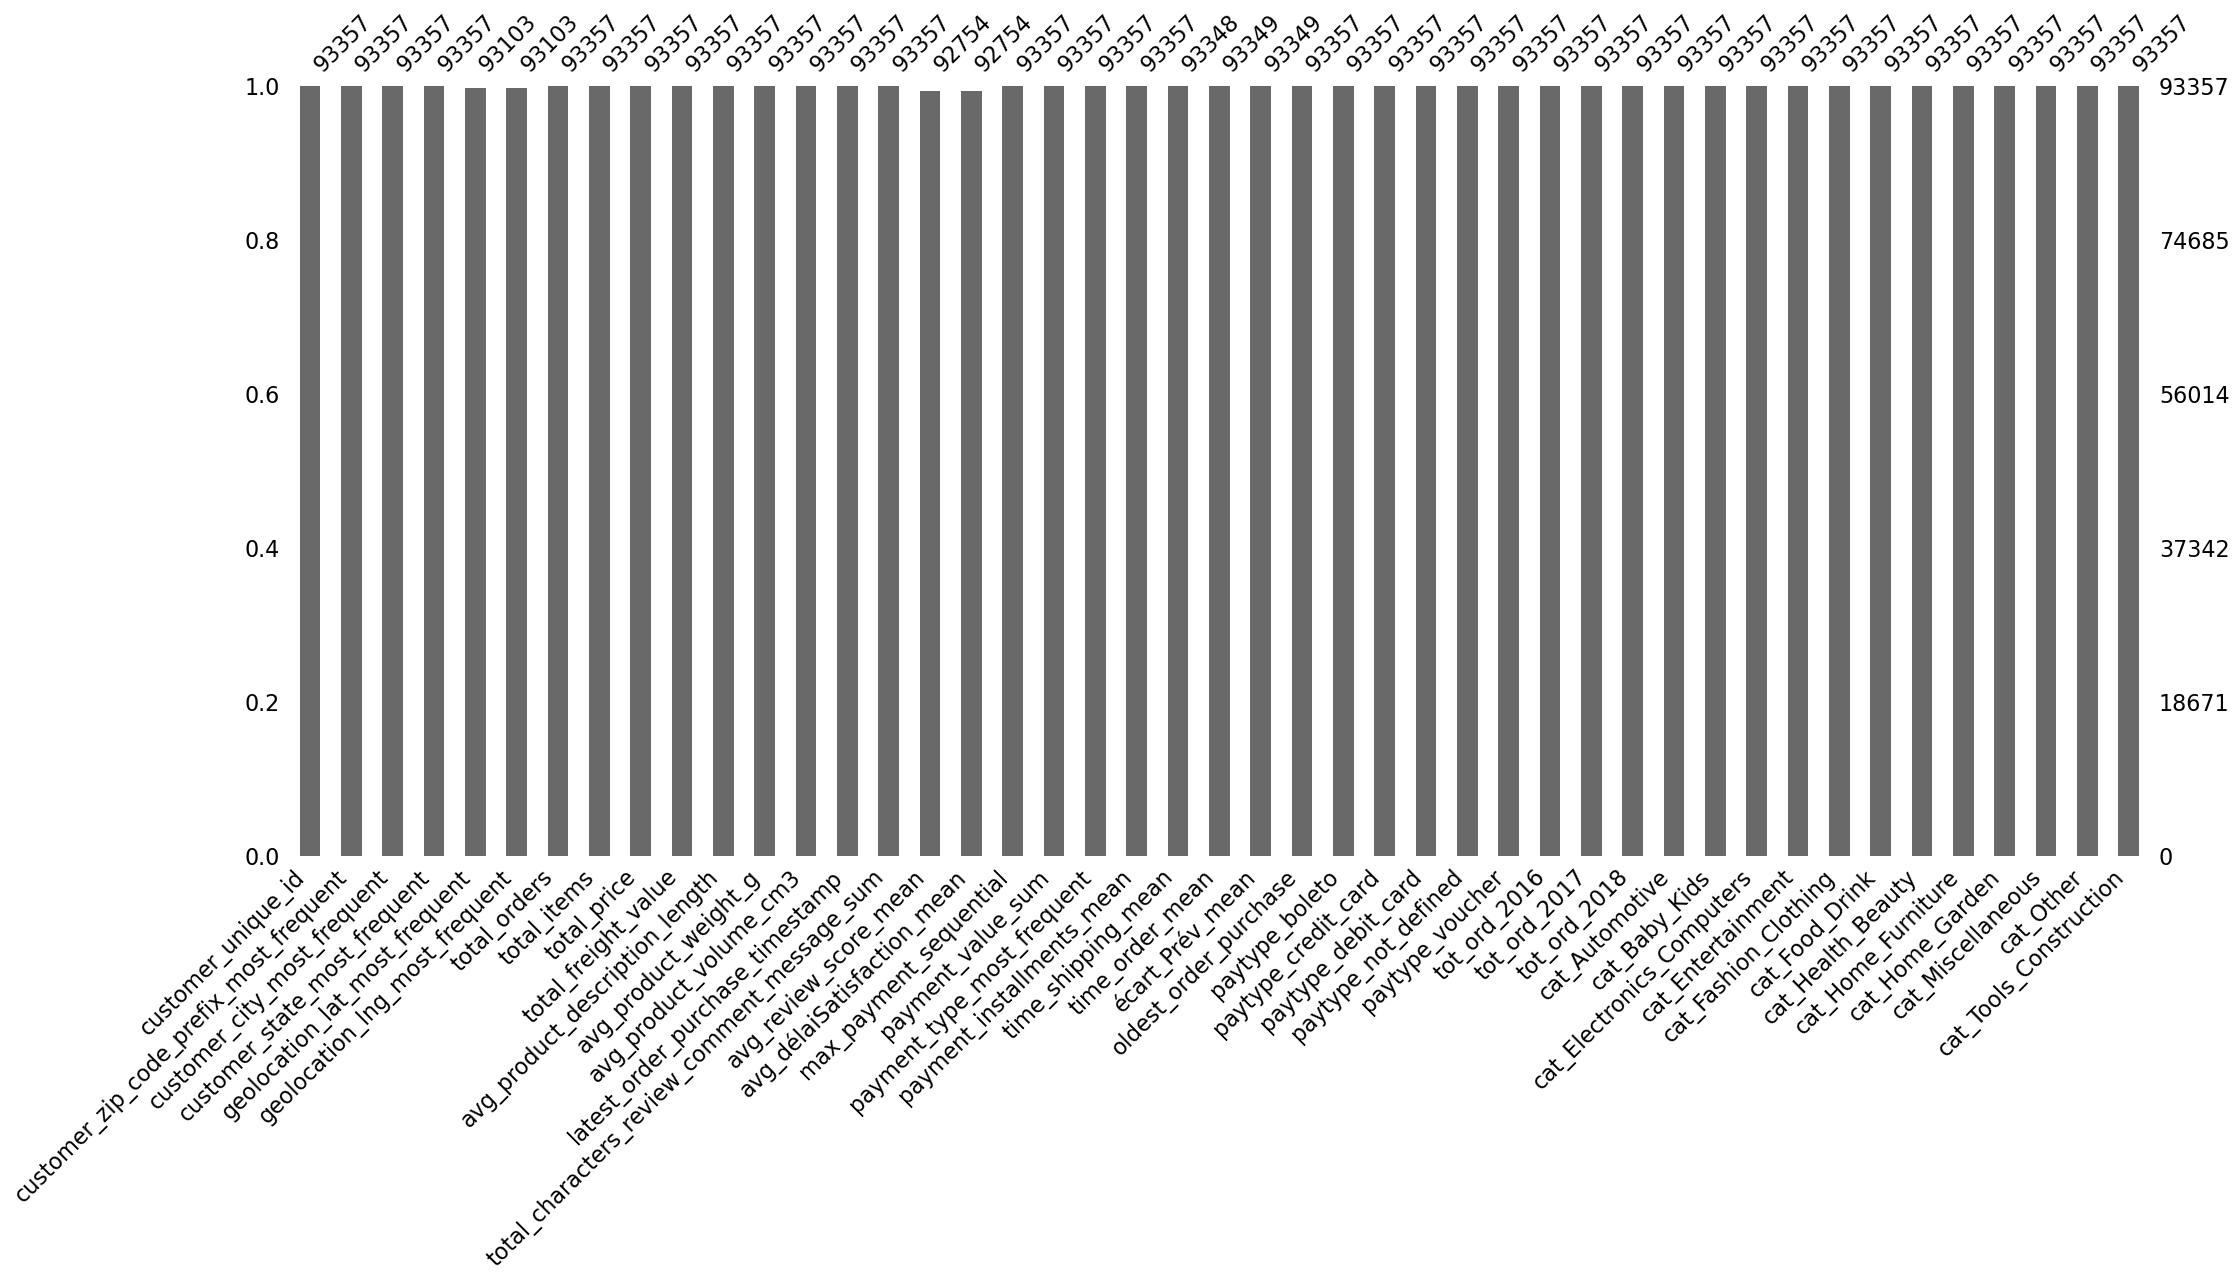

In [68]:
# Afficher le remplissage par colonne du dataframe df_clients
msno.bar(df_cust)

In [69]:
# Calcul du taux de remplissage par colonne
fill_rate_by_column = df_cust.count() / len(df_cust) * 100

# Calcul du taux de remplissage global
fill_rate_global = df_cust.count().sum() / (len(df_cust) * len(df_cust.columns)) * 100

# Affichage des résultats
print("Taux de remplissage par colonne :")
print(fill_rate_by_column)
print("\nTaux de remplissage global du DataFrame : {:.2f}%".format(fill_rate_global))


Taux de remplissage par colonne :
customer_unique_id                             100.000000
customer_zip_code_prefix_most_frequent         100.000000
customer_city_most_frequent                    100.000000
customer_state_most_frequent                   100.000000
geolocation_lat_most_frequent                   99.727926
geolocation_lng_most_frequent                   99.727926
total_orders                                   100.000000
total_items                                    100.000000
total_price                                    100.000000
total_freight_value                            100.000000
avg_product_description_length                 100.000000
avg_product_weight_g                           100.000000
avg_product_volume_cm3                         100.000000
latest_order_purchase_timestamp                100.000000
total_characters_review_comment_message_sum    100.000000
avg_review_score_mean                           99.354092
avg_délaiSatisfaction_mean            

Nous avons un taux remplissage de 99.96%, où cela est dû lors des différents recoupement où certaines commandes n'était pas présentes dans les deux tables par exemple. 
Il est difficile d'imputer les données manquantes de manière pertinente, il est donc préférable de supprimer les lignes où nous avons des Nan, étant donné la faible représentation de celle-ci, cela ne va pas transformer la structure de nos données.

In [70]:
# Supprimer les lignes avec des valeurs nulles (Nan)
print('Nombre de lignes avant :', df_cust.shape)
df_cust = df_cust.dropna()
print('Nombre de lignes après :', df_cust.shape)
# Calcul du taux de remplissage global
fill_rate_global2 = df_cust.count().sum() / (len(df_cust) * len(df_cust.columns)) * 100
print('Taux de remplissage:', fill_rate_global2)

Nombre de lignes avant : (93357, 45)
Nombre de lignes après : (92492, 45)
Taux de remplissage: 100.0


## 6. Feature engineering

### a. Calcul du nombre de jours depuis le premier & le dernier achat

In [71]:
# Transformation en jours par rapport à la date max, les dates oldest_order_purchase & latest_order_purchase_timestamp, en se basant sur la date la plus récente 
earliestDate = df_cust['latest_order_purchase_timestamp'].max()
print('Afficher la date d\'achat la plus récente:', earliestDate)

# Calculer la différence en jours par rapport à la date la plus récente
df_cust['time_since_last_purch'] = (earliestDate - df_cust['latest_order_purchase_timestamp']).dt.days
df_cust['time_since_first_purch'] = (earliestDate - df_cust['oldest_order_purchase']).dt.days

Afficher la date d'achat la plus récente: 2018-08-29 15:00:37


C:\Users\justi\AppData\Local\Temp\ipykernel_13840\640360885.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cust['time_since_last_purch'] = (earliestDate - df_cust['latest_order_purchase_timestamp']).dt.days
C:\Users\justi\AppData\Local\Temp\ipykernel_13840\640360885.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cust['time_since_first_purch'] = (earliestDate - df_cust['oldest_order_purchase']).dt.days


### b. Calcul du nombre moyen d'article par commande par clients et le coût moyen par commande 

In [73]:
# Calcul du nombre moyen d'article par commande et par client
df_cust['mean_items_per_order'] = df_cust['total_items'] / df_cust['total_orders']
mean_items = df_cust['mean_items_per_order'].mean()
print('Nombre moyen d\'article commandés par commande & par client:',mean_items)

# Calcul du coût moyen par commande et par client
df_cust['mean_price_per_order'] = df_cust['payment_value_sum'] / df_cust['total_orders']
mean_price = df_cust['mean_price_per_order'].mean()
print('Prix total moyen par commande et par client:',mean_price)


Nombre moyen d'article commandés par commande & par client: 1.1388259662440132
Prix total moyen par commande et par client: 160.06107937812212


C:\Users\justi\AppData\Local\Temp\ipykernel_13840\3656958156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cust['mean_items_per_order'] = df_cust['total_items'] / df_cust['total_orders']
C:\Users\justi\AppData\Local\Temp\ipykernel_13840\3656958156.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cust['mean_price_per_order'] = df_cust['payment_value_sum'] / df_cust['total_orders']


<Axes: >

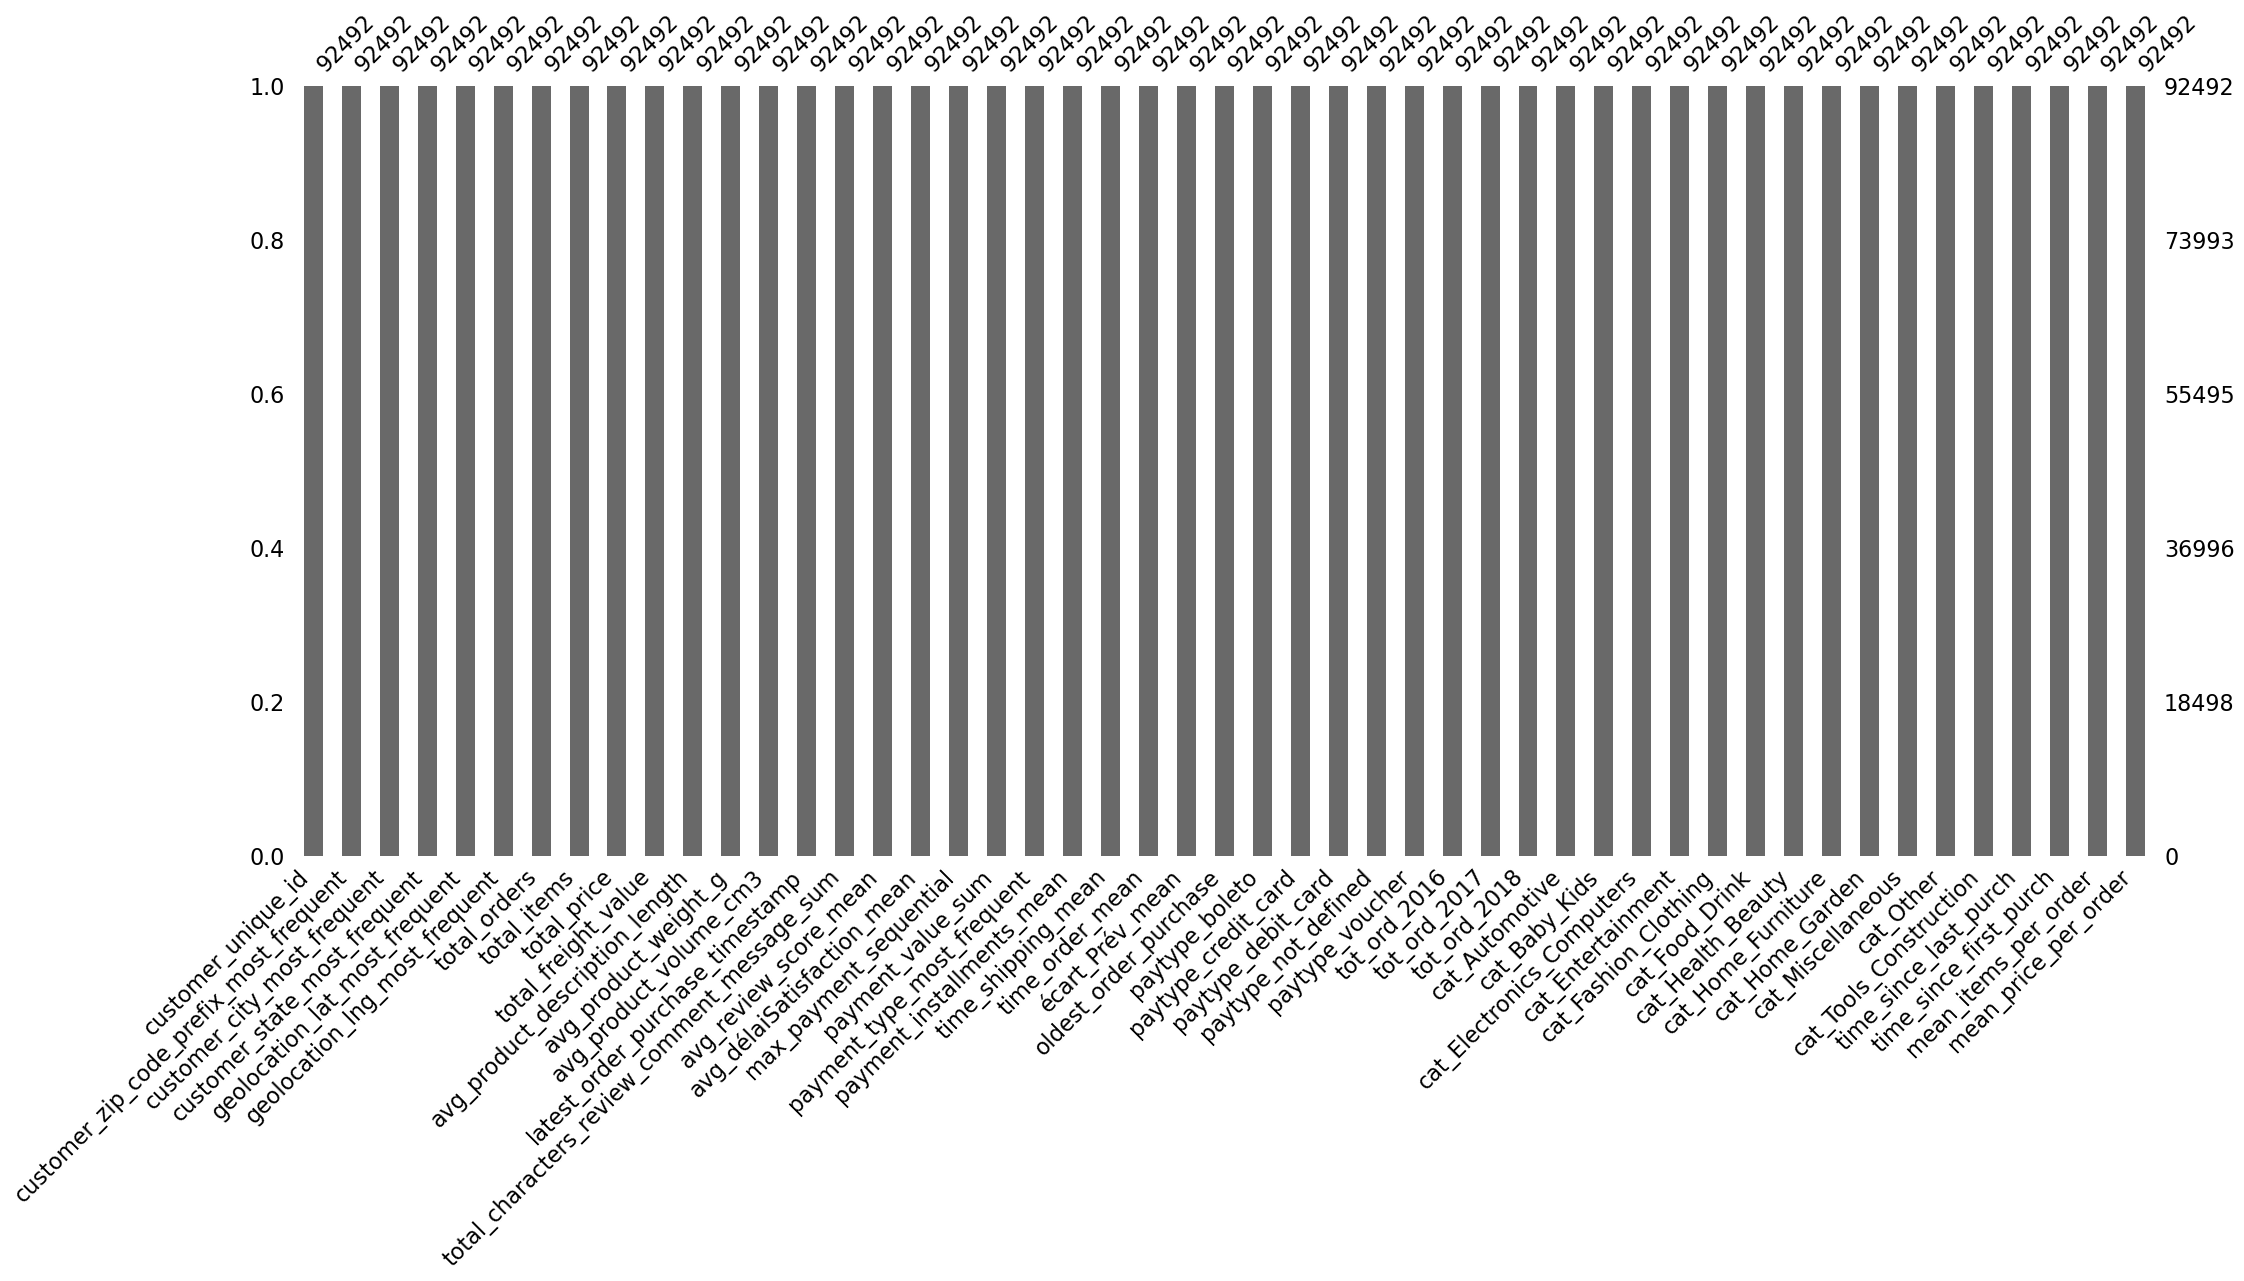

In [74]:
msno.bar(df_cust)

In [75]:
# Afficher les colonnes présentent dans notre dataframe
print('Afficher le nom des colonnes:', df_cust.columns)
print('Afficher la structure de dataframe:',df_cust.shape)

Afficher le nom des colonnes: Index(['customer_unique_id', 'customer_zip_code_prefix_most_frequent',
       'customer_city_most_frequent', 'customer_state_most_frequent',
       'geolocation_lat_most_frequent', 'geolocation_lng_most_frequent',
       'total_orders', 'total_items', 'total_price', 'total_freight_value',
       'avg_product_description_length', 'avg_product_weight_g',
       'avg_product_volume_cm3', 'latest_order_purchase_timestamp',
       'total_characters_review_comment_message_sum', 'avg_review_score_mean',
       'avg_délaiSatisfaction_mean', 'max_payment_sequential',
       'payment_value_sum', 'payment_type_most_frequent',
       'payment_installments_mean', 'time_shipping_mean', 'time_order_mean',
       'écart_Prév_mean', 'oldest_order_purchase', 'paytype_boleto',
       'paytype_credit_card', 'paytype_debit_card', 'paytype_not_defined',
       'paytype_voucher', 'tot_ord_2016', 'tot_ord_2017', 'tot_ord_2018',
       'cat_Automotive', 'cat_Baby_Kids', 'cat_Elect

In [76]:
# Consolider les dataframes en csv
df_cust.to_csv('df_cust.csv', index=False)
df_commandes_produits.to_csv('df_commandes_produits.csv', index=False)
df_commandes.to_csv('df_commandes.csv',index=False)

# IV. Dataframe clients & RFM

**Identité Client :**

- customer_unique_id (Identifiant unique du client)
- customer_zip_code_prefix_most_frequent (Code postal le plus fréquent du client)
- customer_city_most_frequent (Ville la plus fréquente du client)
- customer_state_most_frequent (État le plus fréquent du client)
- geolocation_lat_most_frequent (Latitude la plus fréquente)
- geolocation_lng_most_frequent (Longitude la plus fréquente)

**Activité Client :**

- time_since_last_purch (Temps depuis le dernier achat)
- time_since_first_purch (Temps depuis le premier achat)
- total_orders (Nombre total de commandes)
- mean_items_per_order (Nombre moyen d'articles par commande)
- mean_price_per_order (Prix moyen par commande)
- total_price (Total des achats)
- total_freight_value (Total des frais de port)
- payment_value_sum (Total des paiements)

**Satisfaction Client :**

- avg_review_score_mean (Note moyenne des avis)
- avg_délaiSatisfaction_mean (Délai moyen de satisfaction)
- total_characters_review_comment_message_sum (Total des caractères dans les commentaires des avis)

**Paiement et Livraison :**

- max_payment_sequential (Nombre maximal de paiements séquentiels)
- time_shipping_mean (Temps moyen de traitement de la livraison)
- time_order_mean (Temps moyen de traitement de la commande)
- écart_Prév_mean (Écart moyen par rapport à la date prévue)
- payment_type_most_frequent (Type de paiement le plus fréquent)
- payment_installments_mean (Nombre moyen d'installations de paiement)
- paytype colonnes (Colonnes encodées du moyen de paiement associées au nombre de séquence)

**Produits :**

- avg_product_description_length (Longueur moyenne de description des produits commandés)
- avg_product_weight_g (Poids moyen des produits commandés)
- avg_product_volume_cm3 (Volume moyen des produits commandés)
- cat_Automotive (Catégorie Automobile)
- cat_Baby_Kids (Catégorie Bébé et Enfant)
- cat_Electronics_Computers (Catégorie Électronique et Informatique)
- cat_Entertainment (Catégorie Divertissement)
- cat_Fashion_Clothing (Catégorie Mode et Vêtements)
- cat_Food_Drink (Catégorie Alimentation et Boissons)
- cat_Health_Beauty (Catégorie Santé et Beauté)
- cat_Home_Furniture (Catégorie Mobilier et Décoration)
- cat_Home_Garden (Catégorie Jardin et Bricolage)
- cat_Miscellaneous (Catégorie Divers)
- cat_Other (Autres catégories)
- cat_Tools_Construction (Catégorie Outils et Construction)

**Synthèse après la phase de nettoyage des données :**
- 92 492 clients uniques dans le dataframe final, contre 93 357 dans la base de données d'origine, perte de 1% liée à notre relation 'inner' ainsi qu'à la suppresion de ligne pour les nan et l'opération de filtrage sur les commandes livrées --> Perte marginale.
- 45 variables

Lors de la phase exploratoire, et notamment l'ACP, nous allons pouvoir commencer à faire un tri sur les variables les plus pertinentes ou non notamment en regardant les charges factorielles associées aux variables, dans les premières composantes.

In [141]:
df_cust

customer_unique_id  \
0      0000366f3b9a7992bf8c76cfdf3221e2   
1      0000b849f77a49e4a4ce2b2a4ca5be3f   
2      0000f46a3911fa3c0805444483337064   
3      0000f6ccb0745a6a4b88665a16c9f078   
4      0004aac84e0df4da2b147fca70cf8255   
...                                 ...   
93352  fffcf5a5ff07b0908bd4e2dbc735a684   
93353  fffea47cd6d3cc0a88bd621562a9d061   
93354  ffff371b4d645b6ecea244b27531430a   
93355  ffff5962728ec6157033ef9805bacc48   
93356  ffffd2657e2aad2907e67c3e9daecbeb   

       customer_zip_code_prefix_most_frequent customer_city_most_frequent  \
0                                        7787                     cajamar   
1                                        6053                      osasco   
2                                       88115                    sao jose   
3                                       66812                       belem   
4                                       18040                    sorocaba   
...                                       ...                         ...   
93352                                   55250                     sanharo   
93353                                   44054            feira de santana   
93354                                   78552                       sinop   
93355                                   29460          bom jesus do norte   
93356                                   83608                 campo largo   

      customer_state_most_frequent  geolocation_lat_most_frequent  \
0                               SP                     -23.340235   
1                               SP                     -23.559115   
2                               SC                     -27.542880   
3                               PA                      -1.312214   
4                               SP                     -23.505548   
...                            ...                            ...   
93352                           PE                      -8.362511   
93353                           BA                     -12.217395   
93354                           MT                     -11.834552   
93355                           ES                     -21.126568   
93356                           PR                     -25.447504   

       geolocation_lng_most_frequent  total_orders  total_items  total_price  \
0                         -46.830140             1            1       129.90   
1                         -46.787626             1            1        18.90   
2                         -48.633426             1            1        69.00   
3                         -48.483159             1            1        25.99   
4                         -47.469705             1            1       180.00   
...                              ...           ...          ...          ...   
93352                     -36.562343             1            2      1570.00   
93353                     -38.959308             1            1        64.89   
93354                     -55.508110             1            1        89.90   
93355                     -41.672806             1            1       115.00   
93356                     -49.441283             1            1        56.99   

       total_freight_value  avg_product_description_length  \
0                    12.00                           236.0   
1                     8.29                           635.0   
2                    17.22                           177.0   
3                    17.63                          1741.0   
4                    16.89                           794.0   
...                    ...                             ...   
93352               497.42                           478.5   
93353                19.69                           506.0   
93354                22.56                           716.0   
93355                18.69                           591.0   
93356                14.57                          1003.0   

       avg_product_weight_g  avg_product_vol

# V. Analyse exploratoire

In [2]:
# Les dataframe consolidés
df_cust = pd.read_csv('df_cust.csv')
df_commandes_produits = pd.read_csv('df_commandes_produits.csv')
df_commandes = pd.read_csv('df_commandes.csv')

In [91]:
df_cust

customer_unique_id  \
0      0000366f3b9a7992bf8c76cfdf3221e2   
1      0000b849f77a49e4a4ce2b2a4ca5be3f   
2      0000f46a3911fa3c0805444483337064   
3      0000f6ccb0745a6a4b88665a16c9f078   
4      0004aac84e0df4da2b147fca70cf8255   
...                                 ...   
92487  fffcf5a5ff07b0908bd4e2dbc735a684   
92488  fffea47cd6d3cc0a88bd621562a9d061   
92489  ffff371b4d645b6ecea244b27531430a   
92490  ffff5962728ec6157033ef9805bacc48   
92491  ffffd2657e2aad2907e67c3e9daecbeb   

       customer_zip_code_prefix_most_frequent customer_city_most_frequent  \
0                                        7787                     cajamar   
1                                        6053                      osasco   
2                                       88115                    sao jose   
3                                       66812                       belem   
4                                       18040                    sorocaba   
...                                       ...                         ...   
92487                                   55250                     sanharo   
92488                                   44054            feira de santana   
92489                                   78552                       sinop   
92490                                   29460          bom jesus do norte   
92491                                   83608                 campo largo   

      customer_state_most_frequent  geolocation_lat_most_frequent  \
0                               SP                     -23.340235   
1                               SP                     -23.559115   
2                               SC                     -27.542880   
3                               PA                      -1.312214   
4                               SP                     -23.505548   
...                            ...                            ...   
92487                           PE                      -8.362511   
92488                           BA                     -12.217395   
92489                           MT                     -11.834552   
92490                           ES                     -21.126568   
92491                           PR                     -25.447504   

       geolocation_lng_most_frequent  total_orders  total_items  total_price  \
0                         -46.830140             1            1       129.90   
1                         -46.787626             1            1        18.90   
2                         -48.633426             1            1        69.00   
3                         -48.483159             1            1        25.99   
4                         -47.469705             1            1       180.00   
...                              ...           ...          ...          ...   
92487                     -36.562343             1            2      1570.00   
92488                     -38.959308             1            1        64.89   
92489                     -55.508110             1            1        89.90   
92490                     -41.672806             1            1       115.00   
92491                     -49.441283             1            1        56.99   

       total_freight_value  avg_product_description_length  \
0                    12.00                           236.0   
1                     8.29                           635.0   
2                    17.22                           177.0   
3                    17.63                          1741.0   
4                    16.89                           794.0   
...                    ...                             ...   
92487               497.42                           478.5   
92488                19.69                           506.0   
92489                22.56                           716.0   
92490                18.69                           591.0   
92491                14.57                          1003.0   

       avg_product_weight_g  avg_product_vol

## 1. Vision globale des distributions pour les variables numériques

In [67]:
# Regarder les stats globaux avec .describe
df_cust.describe(include='all')

customer_unique_id  \
count                              92492   
unique                             92492   
top     0000366f3b9a7992bf8c76cfdf3221e2   
freq                                   1   
mean                                 NaN   
min                                  NaN   
25%                                  NaN   
50%                                  NaN   
75%                                  NaN   
max                                  NaN   
std                                  NaN   

        customer_zip_code_prefix_most_frequent customer_city_most_frequent  \
count                             92492.000000                       92492   
unique                                     NaN                        4040   
top                                        NaN                   sao paulo   
freq                                       NaN                       14415   
mean                              35172.027462                         NaN   
min                                1003.000000                         NaN   
25%                               11347.000000                         NaN   
50%                               24422.000000                         NaN   
75%                               58998.750000                         NaN   
max                               99980.000000                         NaN   
std                               29845.498732                         NaN   

       customer_state_most_frequent  geolocation_lat_most_frequent  \
count                         92492                   92492.000000   
unique                           27                            NaN   
top                              SP                            NaN   
freq                          38900                            NaN   
mean                            NaN                     -21.194314   
min                             NaN                     -33.689948   
25%                             NaN                     -23.590310   
50%                             NaN                     -22.924511   
75%                             NaN                     -20.135904   
max                             NaN                      42.184003   
std                             NaN                       5.611792   

        geolocation_lng_most_frequent  total_orders   total_items  \
count                    92492.000000  92492.000000  92492.000000   
unique                            NaN           NaN           NaN   
top                               NaN           NaN           NaN   
freq                              NaN           NaN           NaN   
mean                       -46.193160      1.033549      1.179778   
min                        -72.668881      1.000000      1.000000   
25%                        -48.131834      1.000000      1.000000   
50%                        -46.633115      1.000000      1.000000   
75%                        -43.635297      1.000000      1.000000   
max                         -8.723762     15.000000     24.000000   
std                          4.057211      0.209640      0.617388   

         total_price  total_freight_value  avg_product_description_length  \
count   92492.000000         92492.000000                    92492.000000   
unique           NaN                  NaN                             NaN   
top              NaN                  NaN                             NaN   
freq             NaN                  NaN                             NaN   
mean      141.404174            23.522520                      792.656159   
min         0.850000             0.000000                        4.000000   
25%        47.650000            14.050000                      360.000000   
50%        89.700000            17.600000                      603.000000   
75%       153.992500            25.480000                      991.000000   
max     13440.000000          1794.960000                     3992.000000   
std       214.533505            22.7569

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


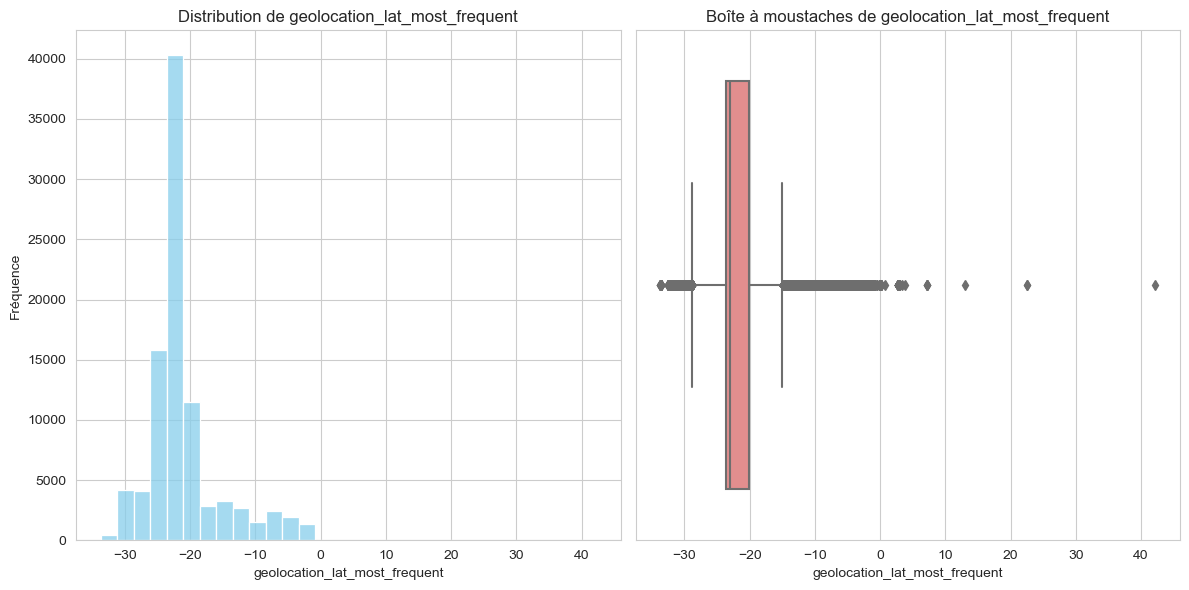

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


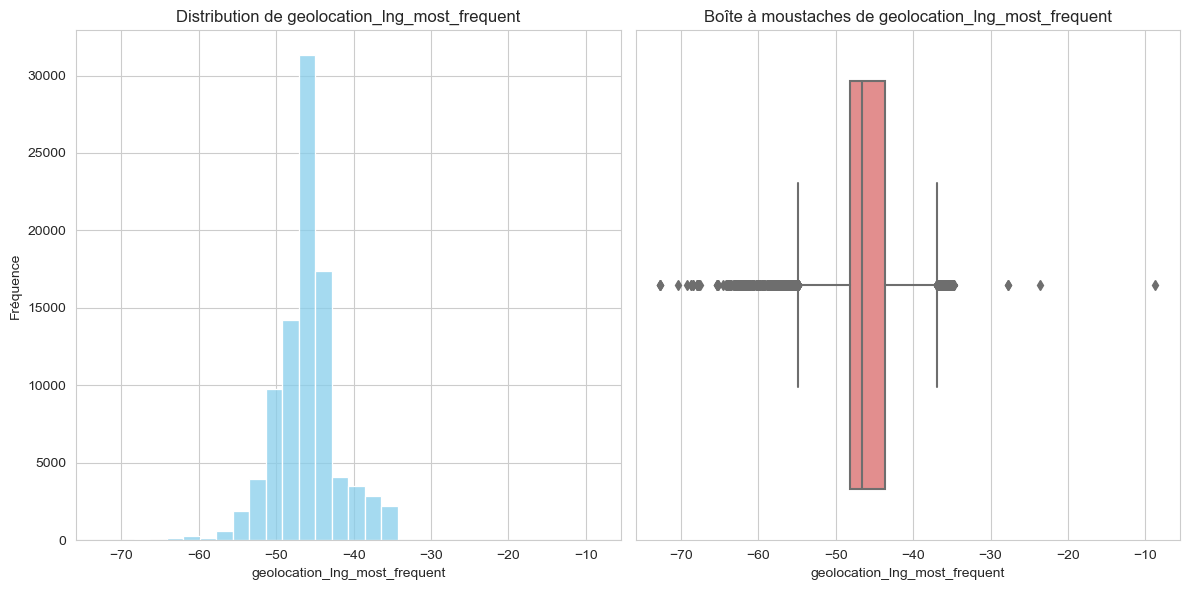

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


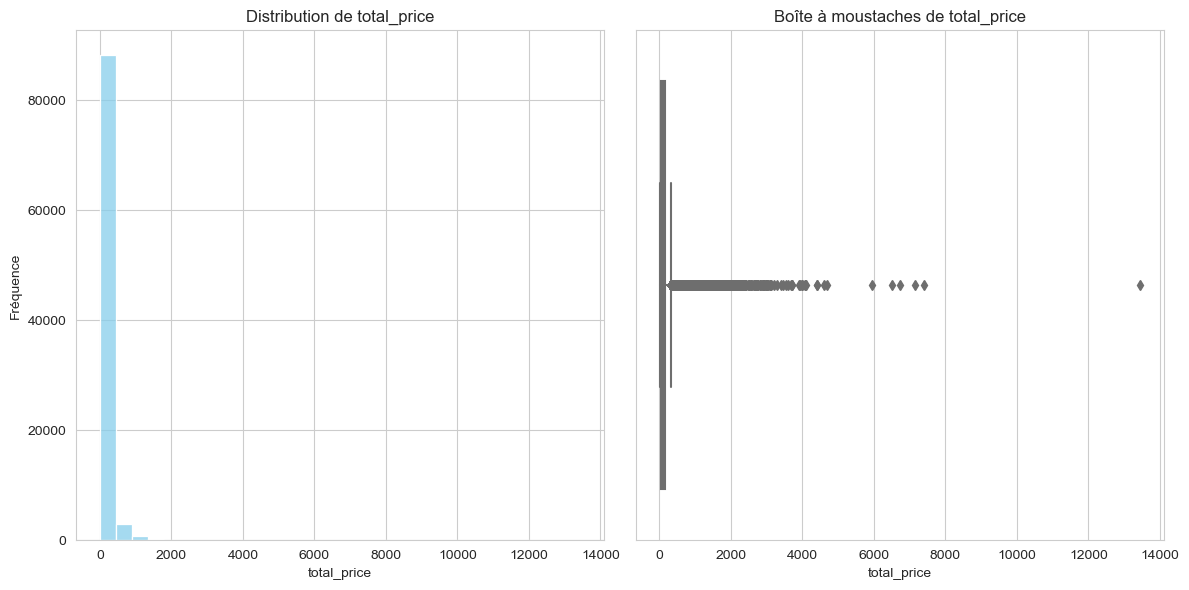

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


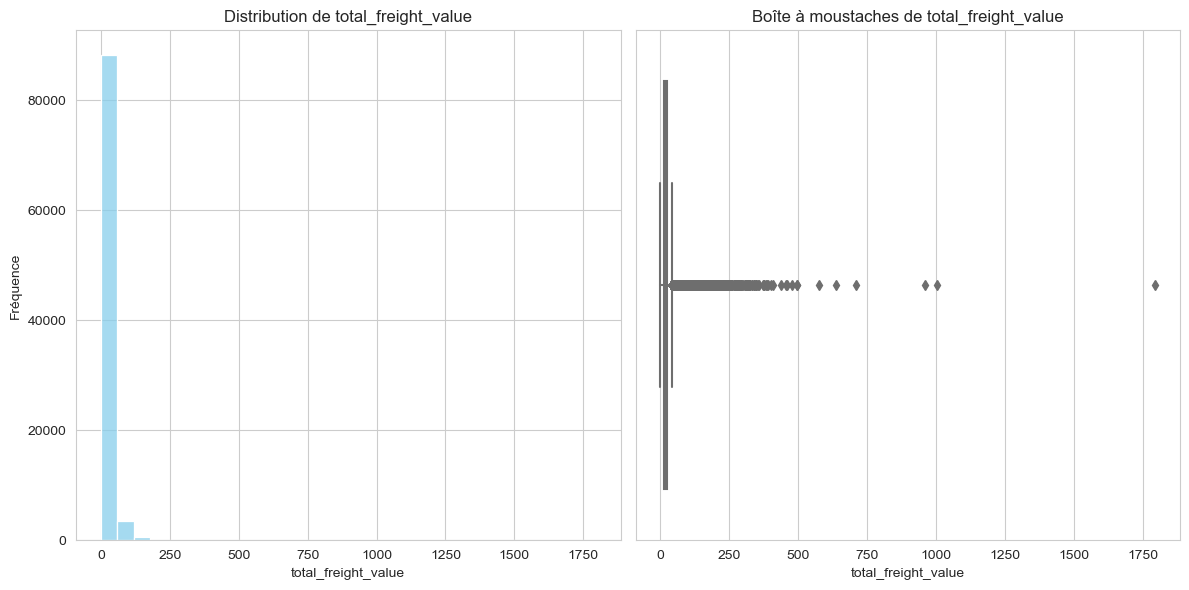

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


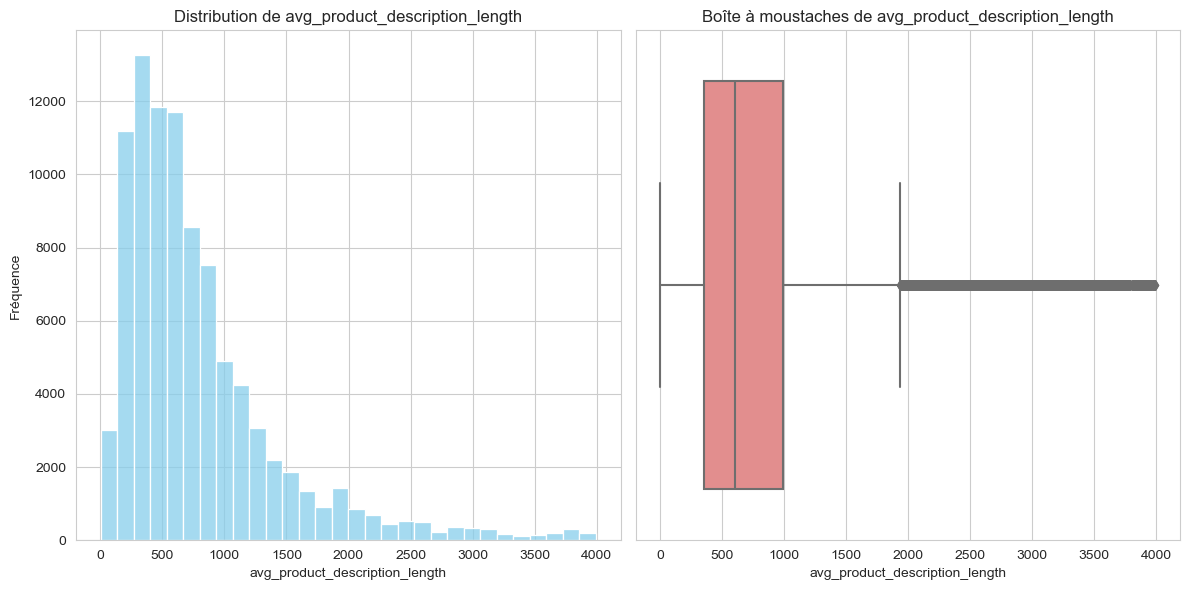

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


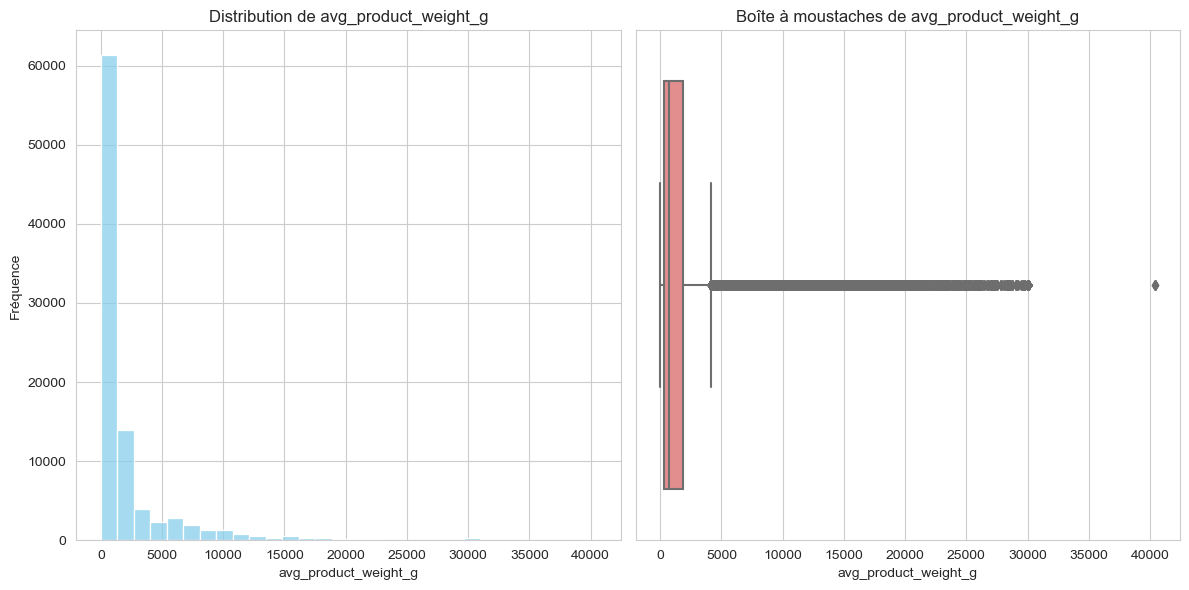

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


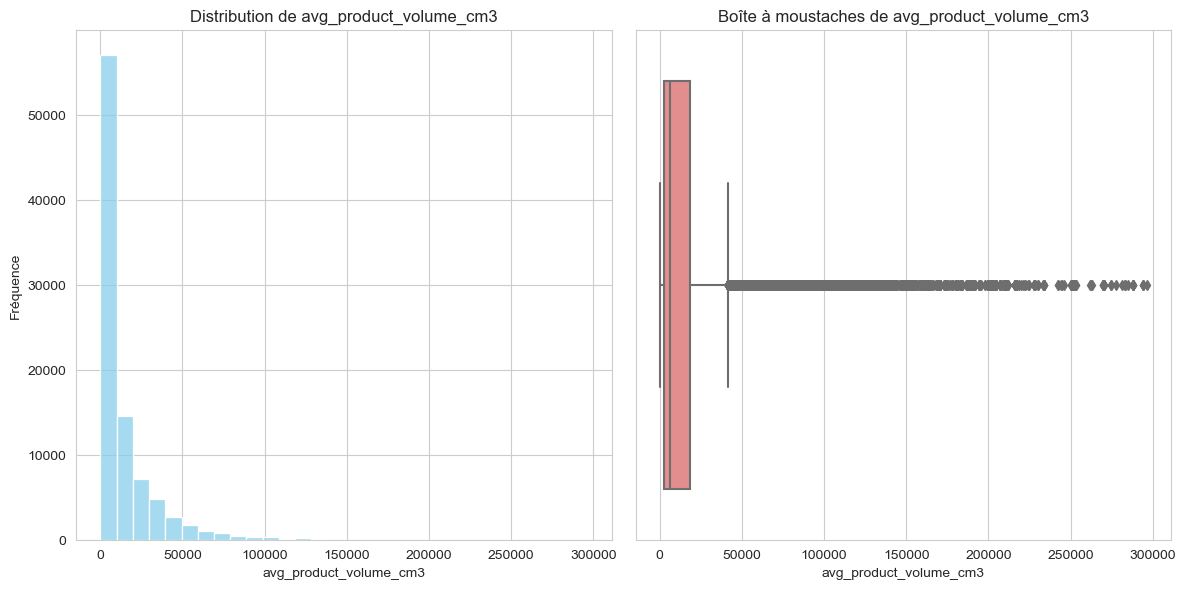

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


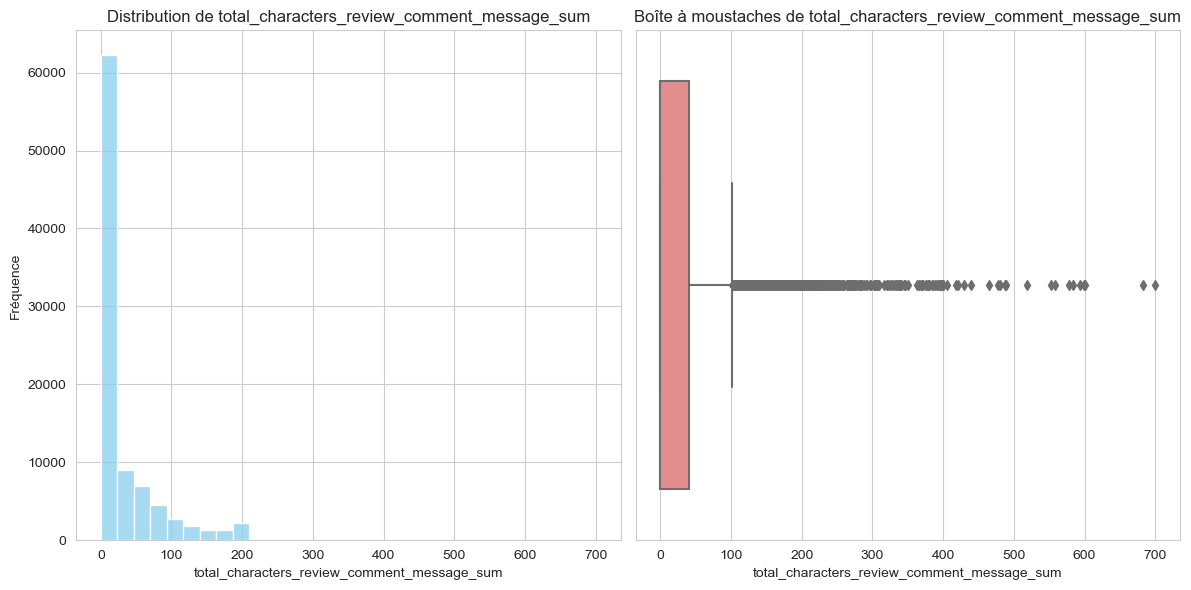

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


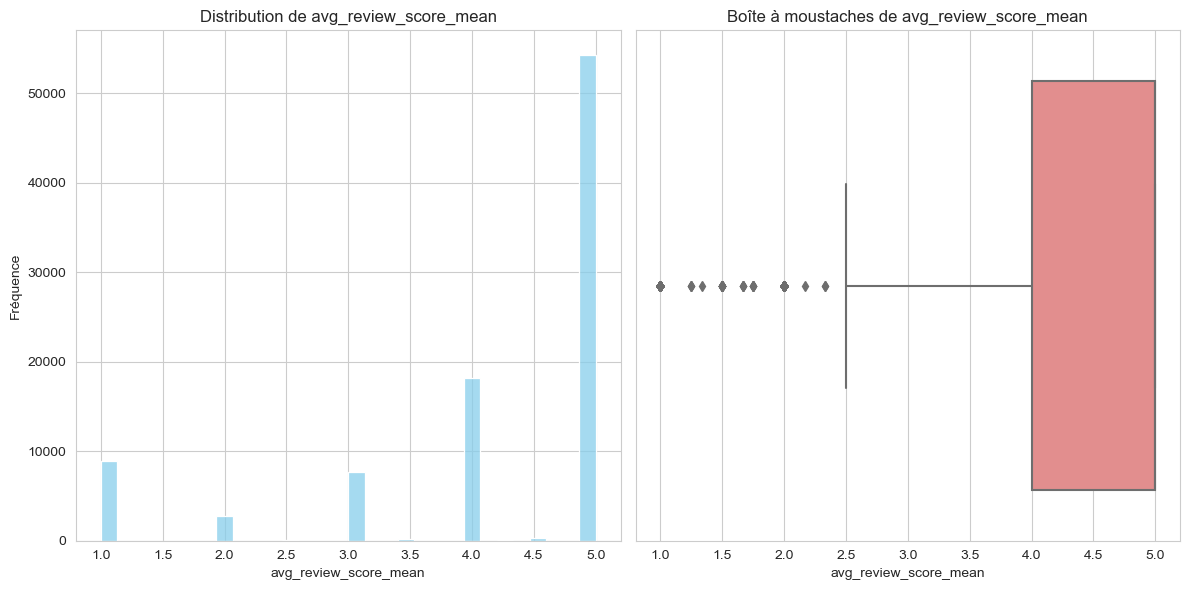

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


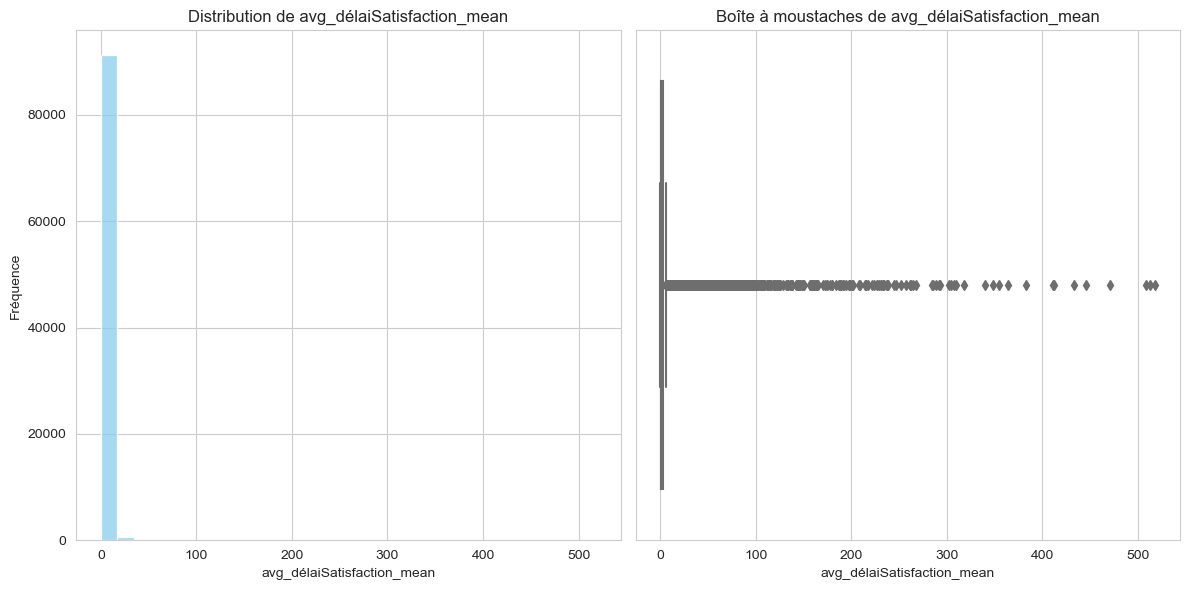

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


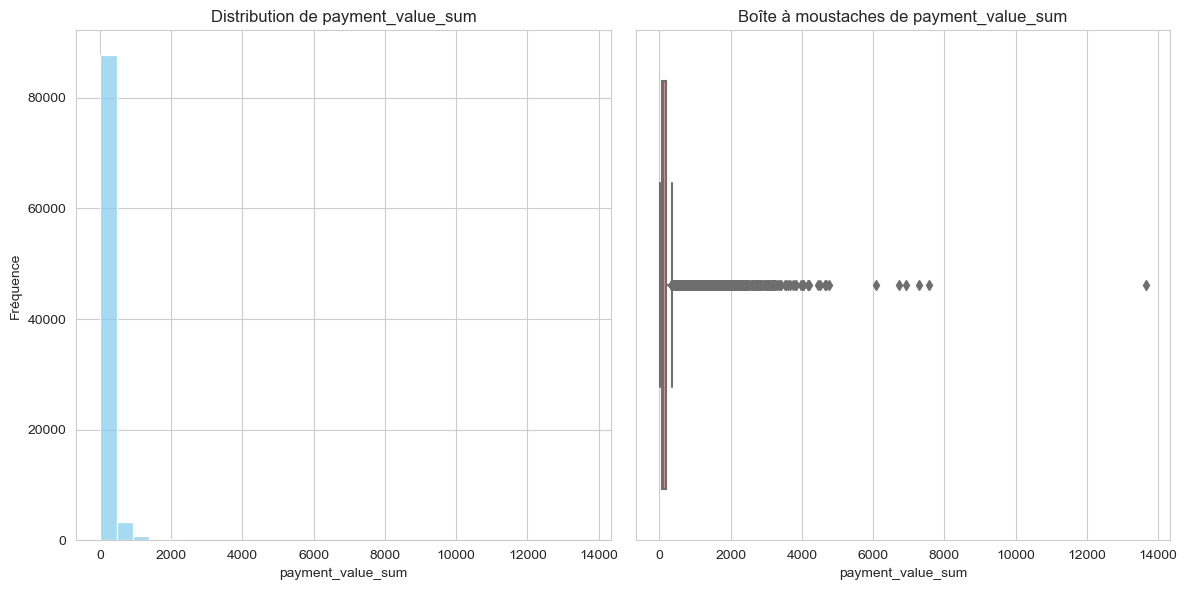

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


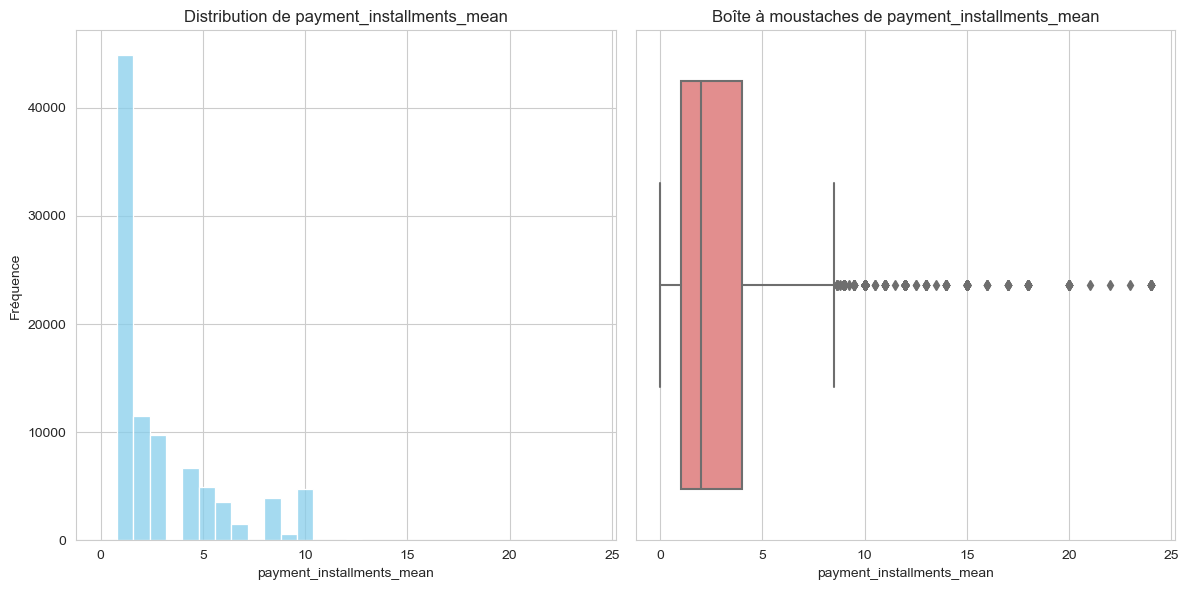

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


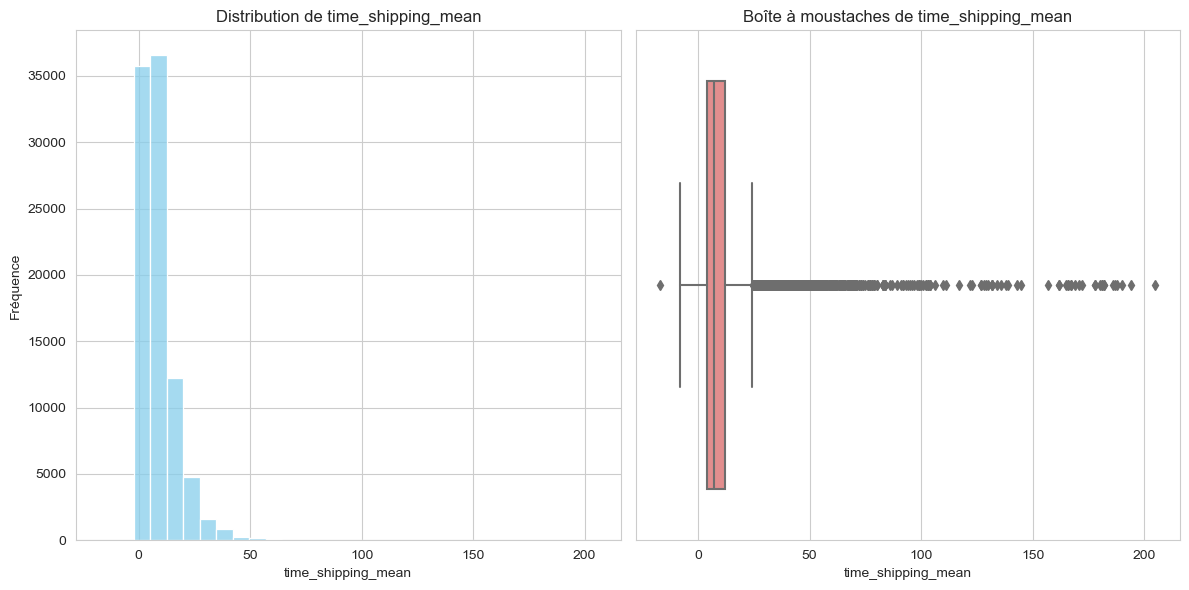

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


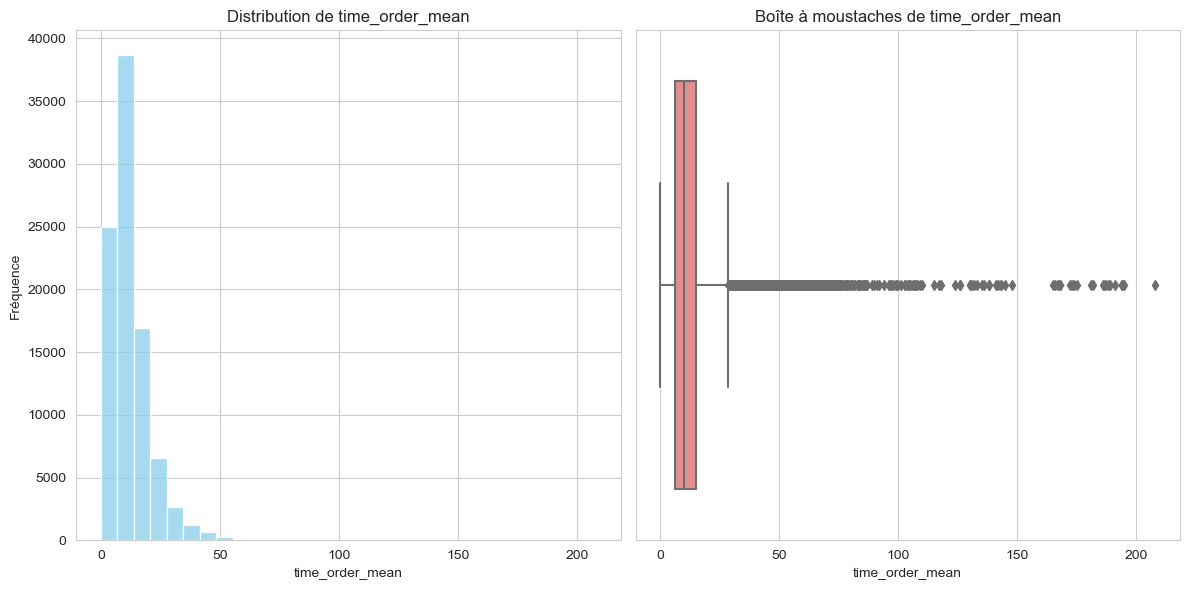

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


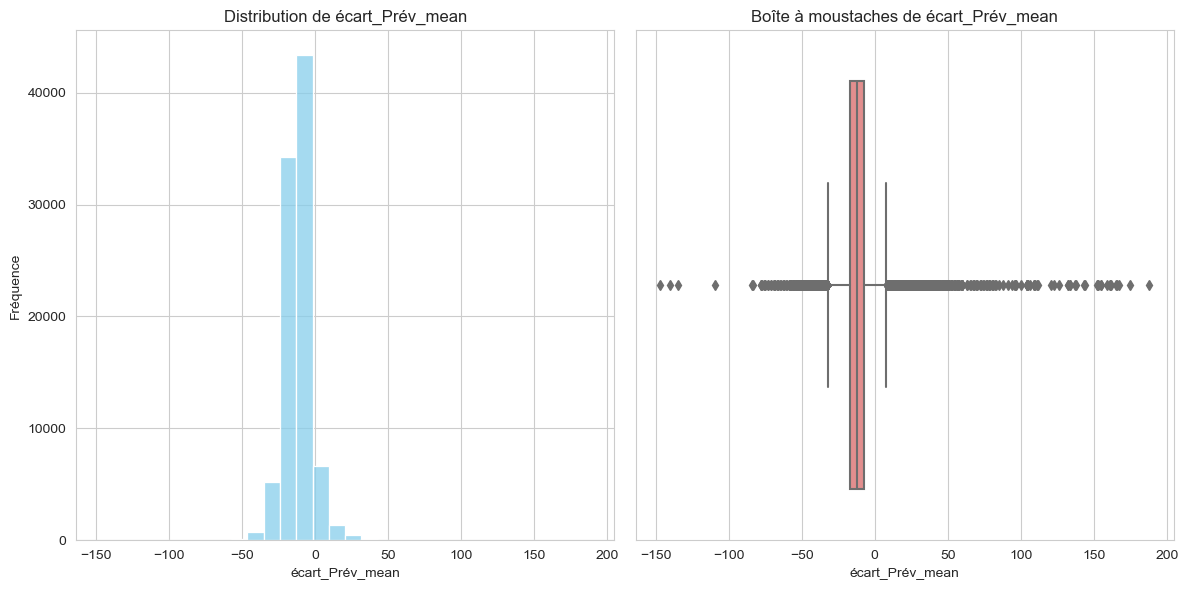

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


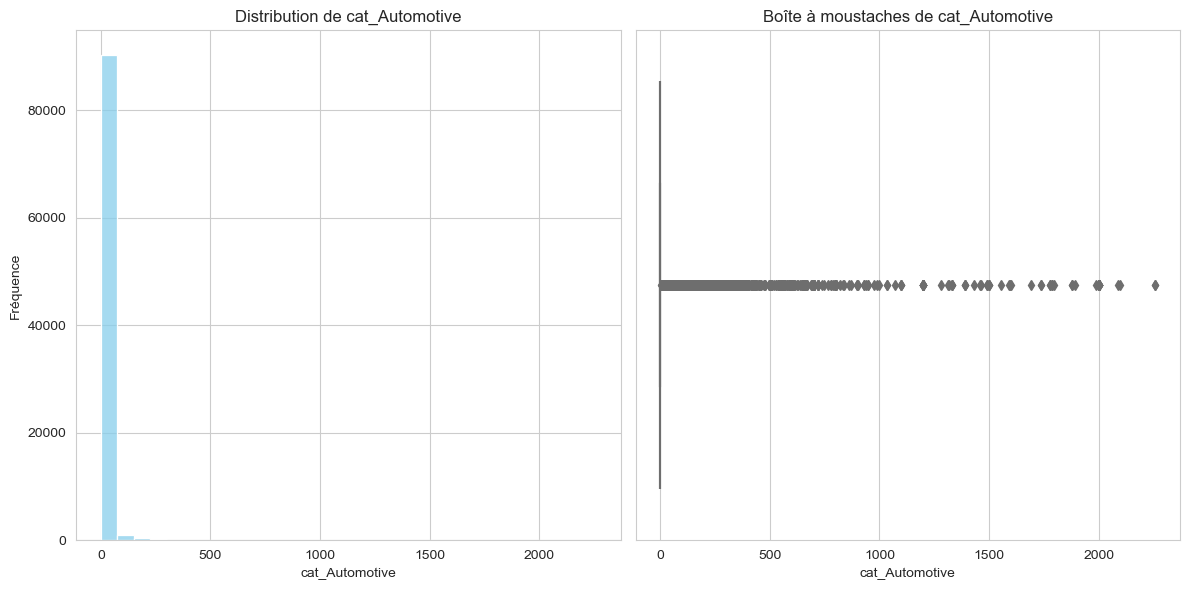

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


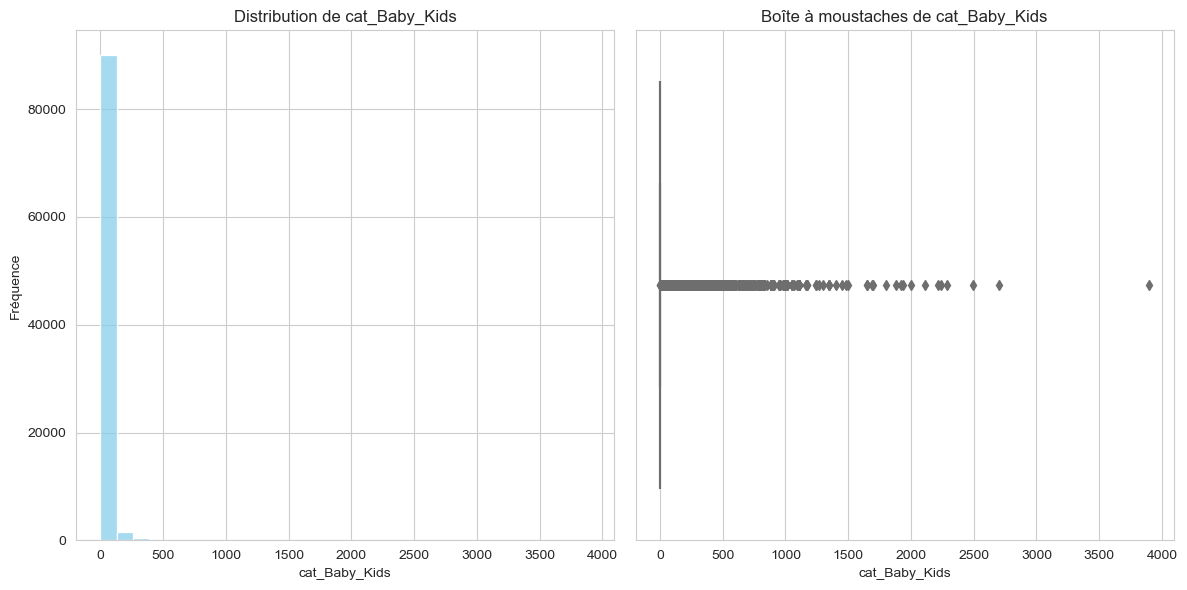

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


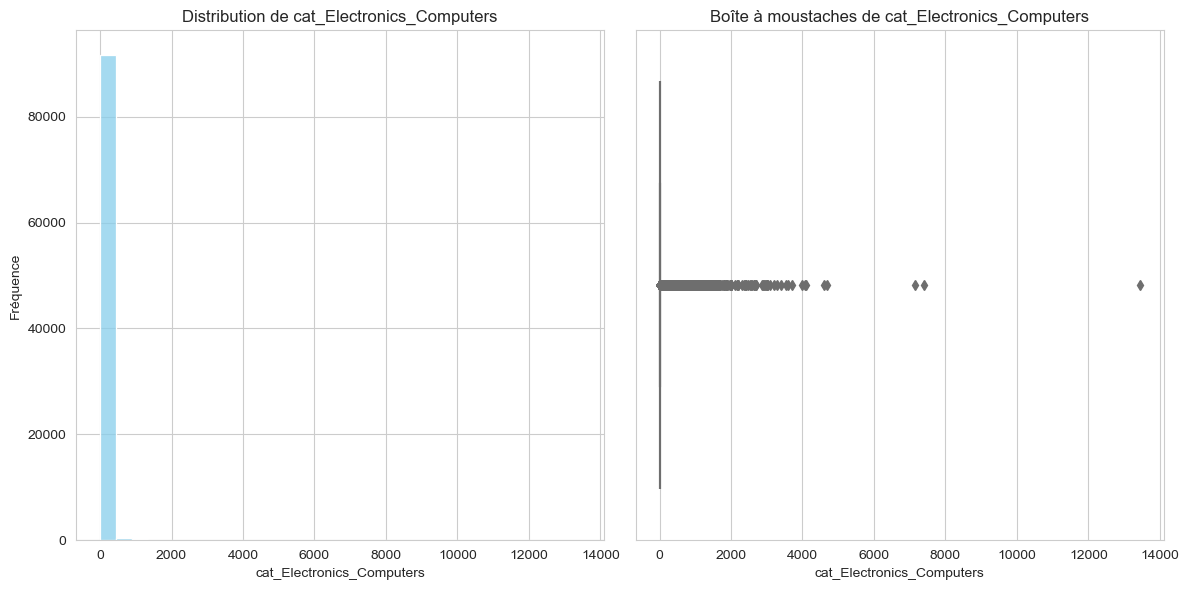

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


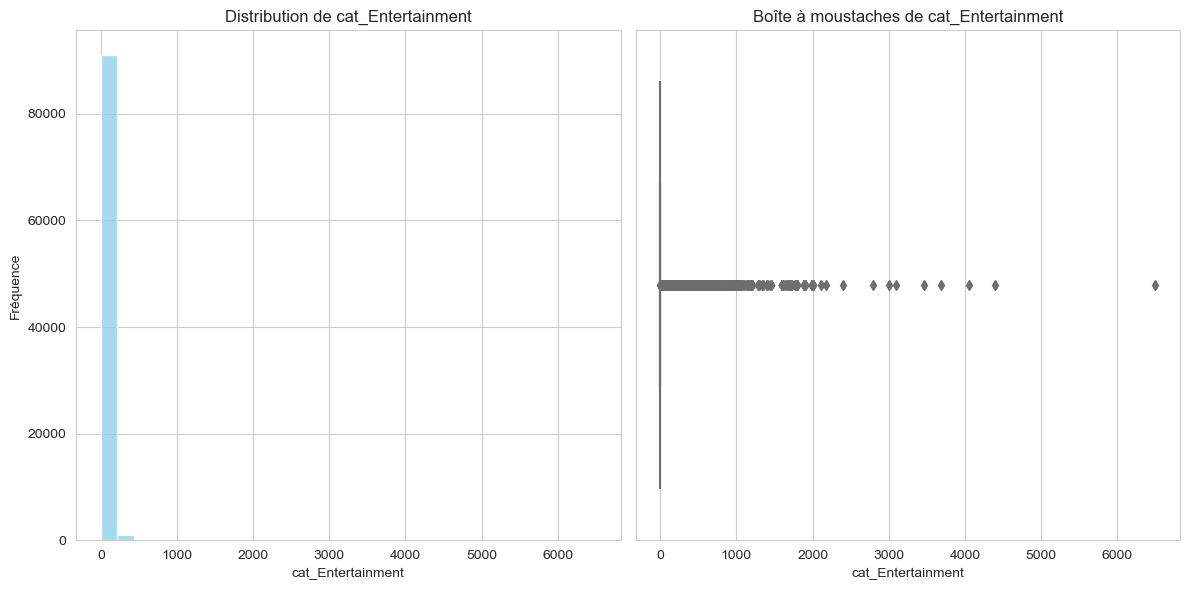

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


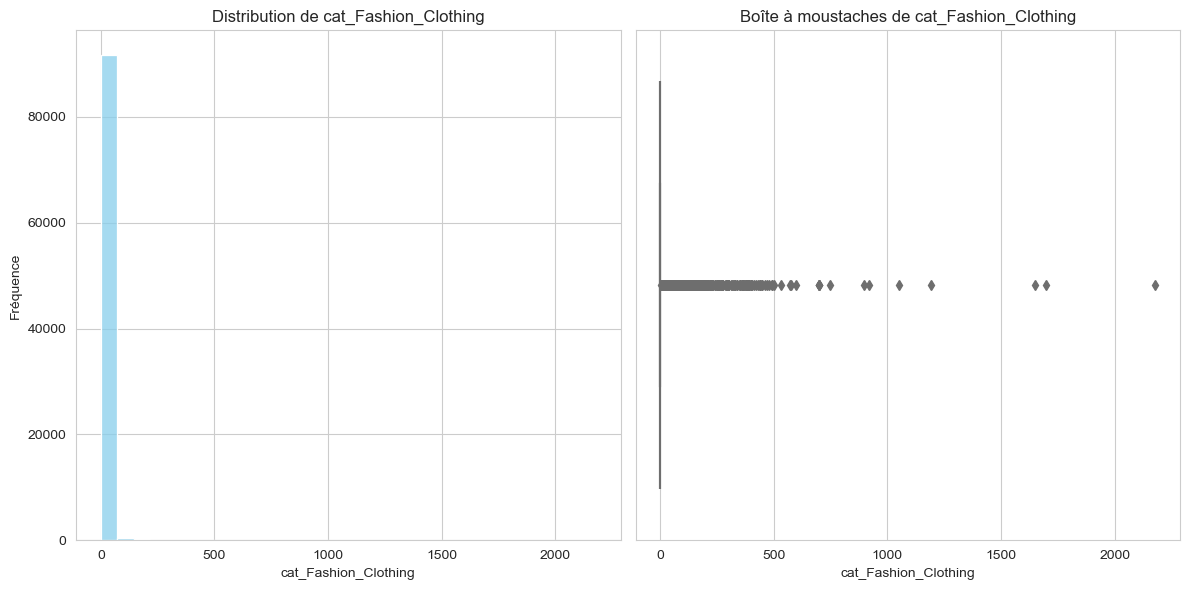

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


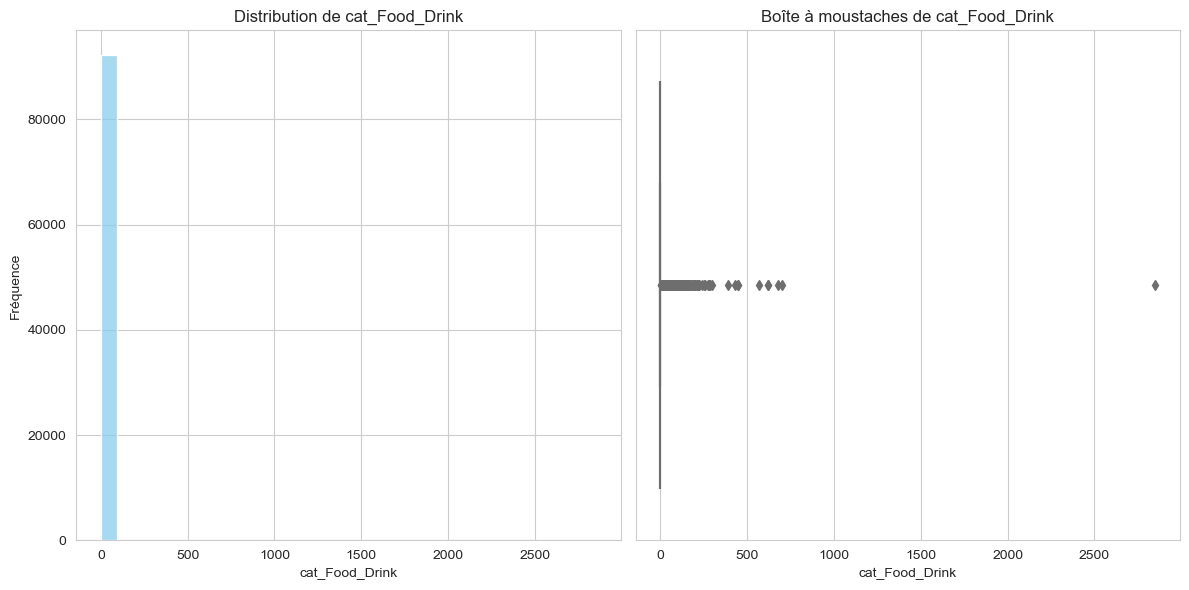

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


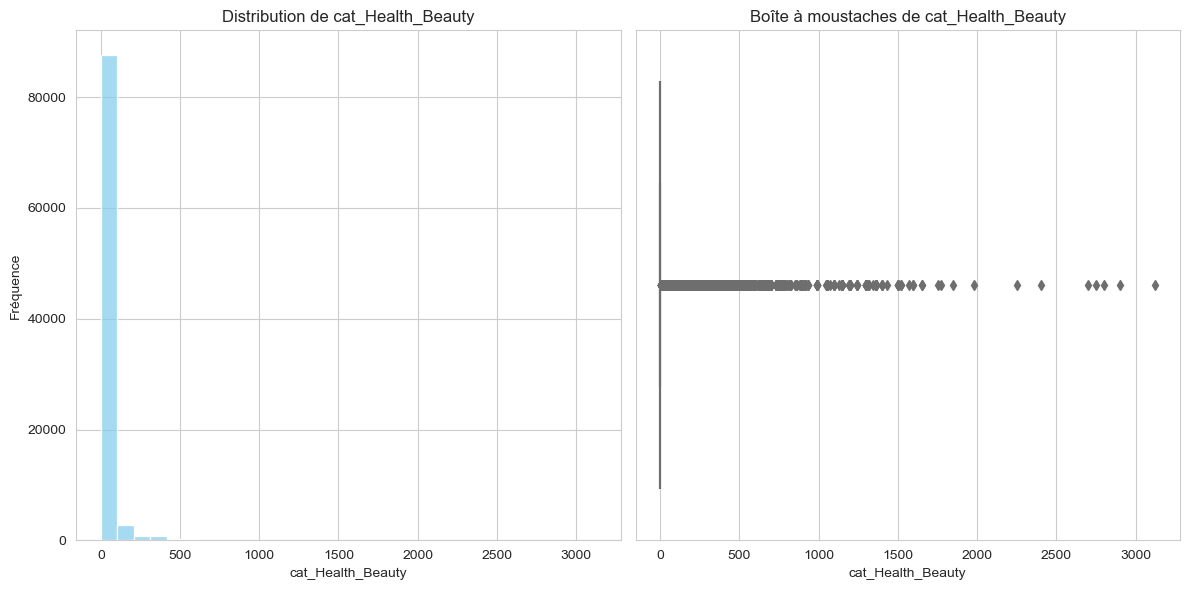

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


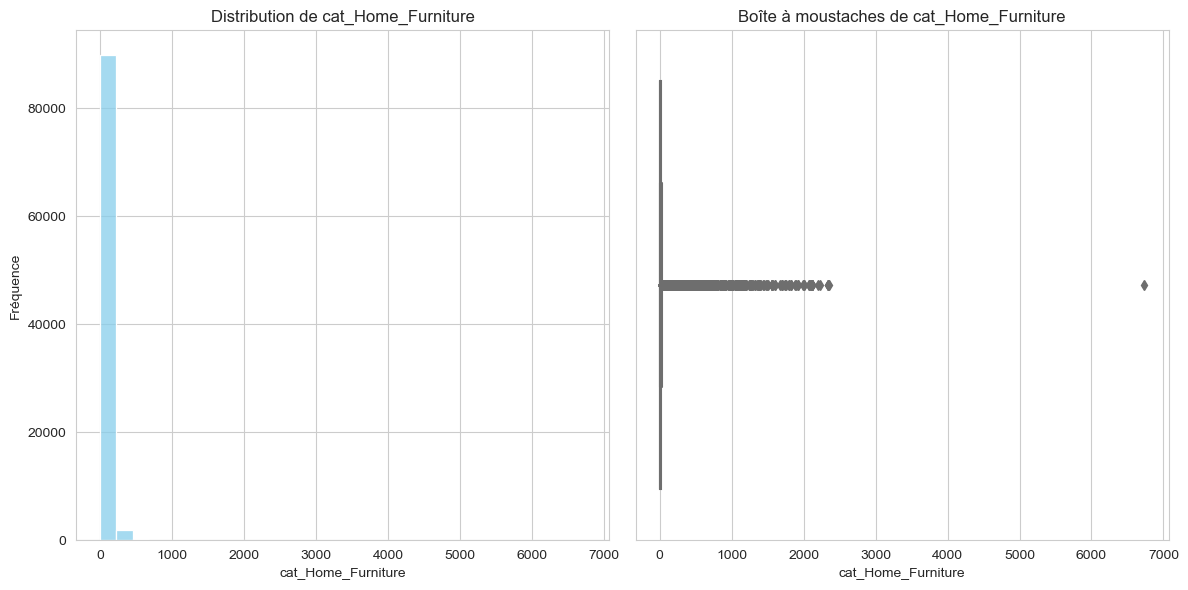

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


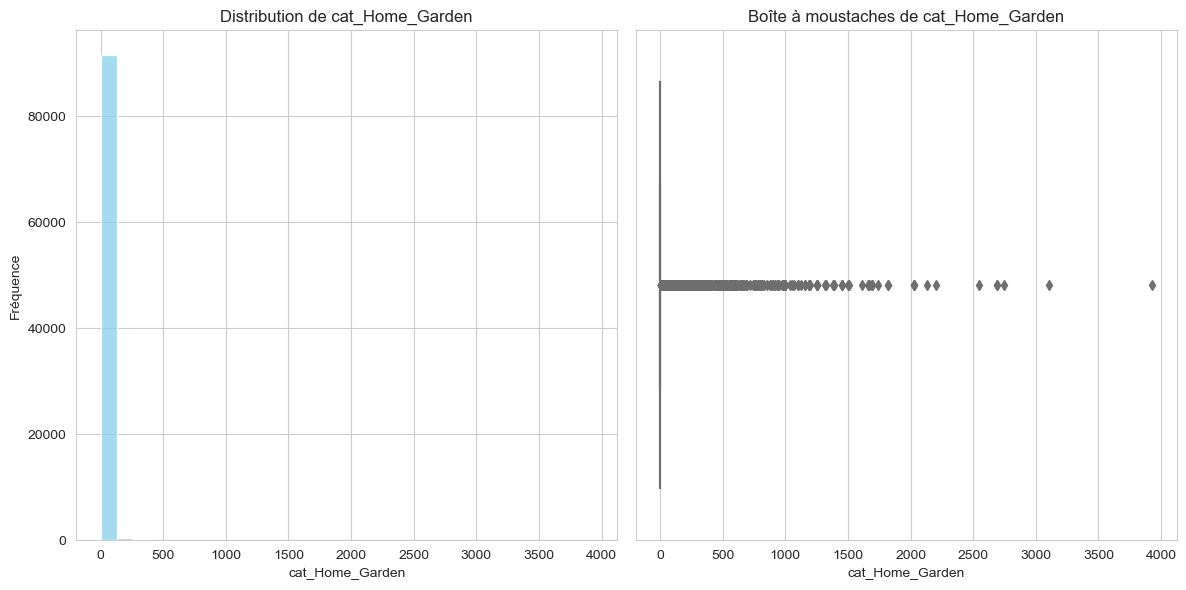

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


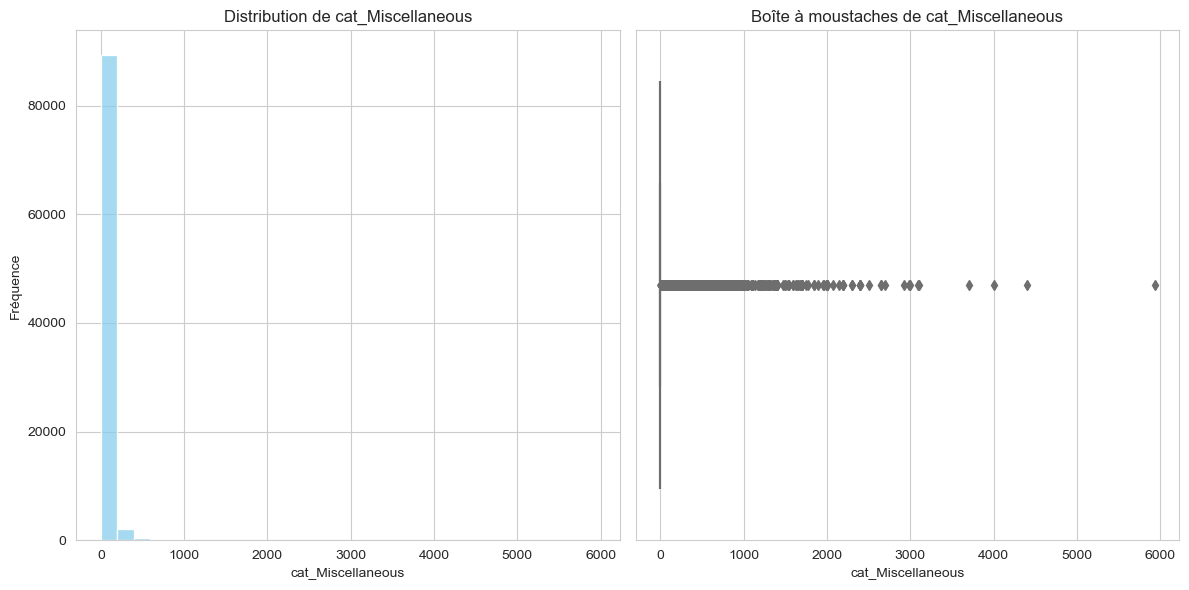

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


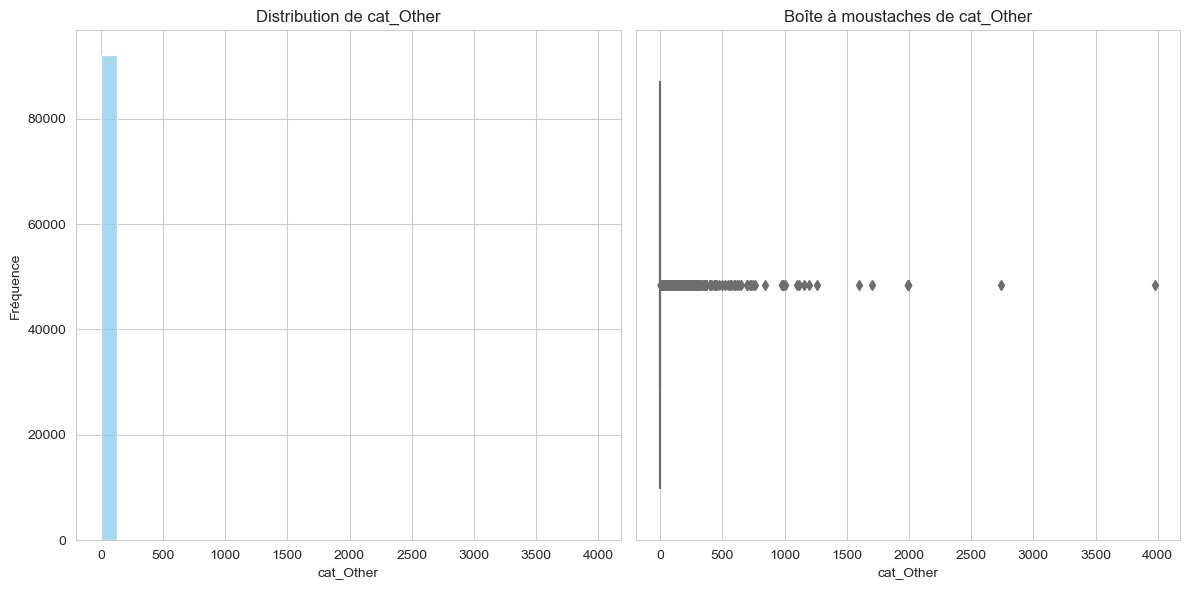

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


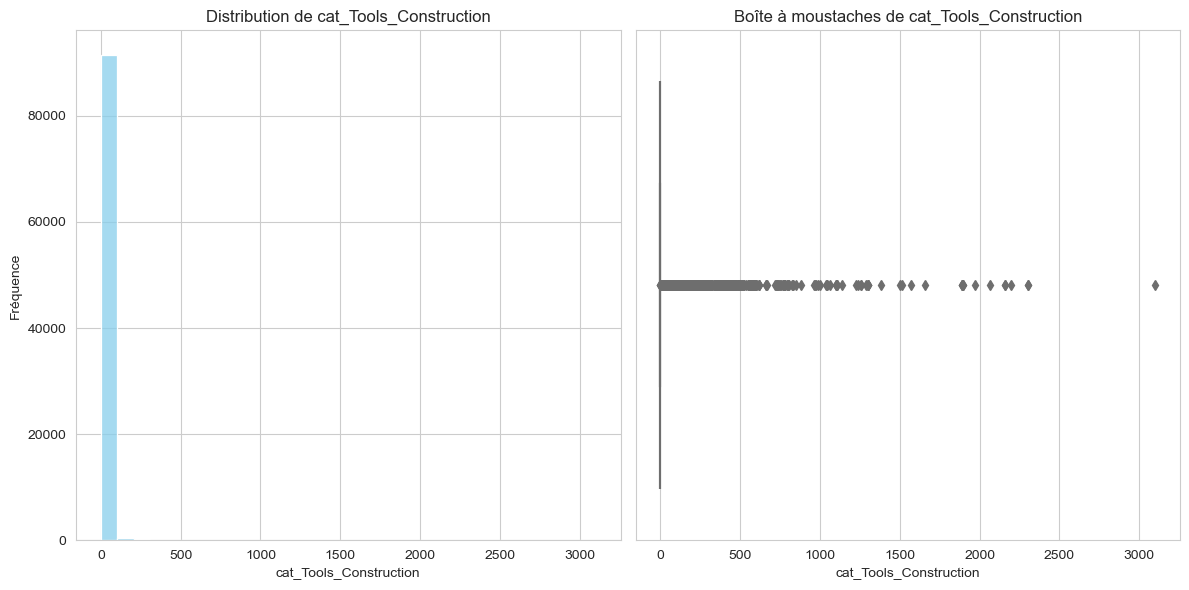

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


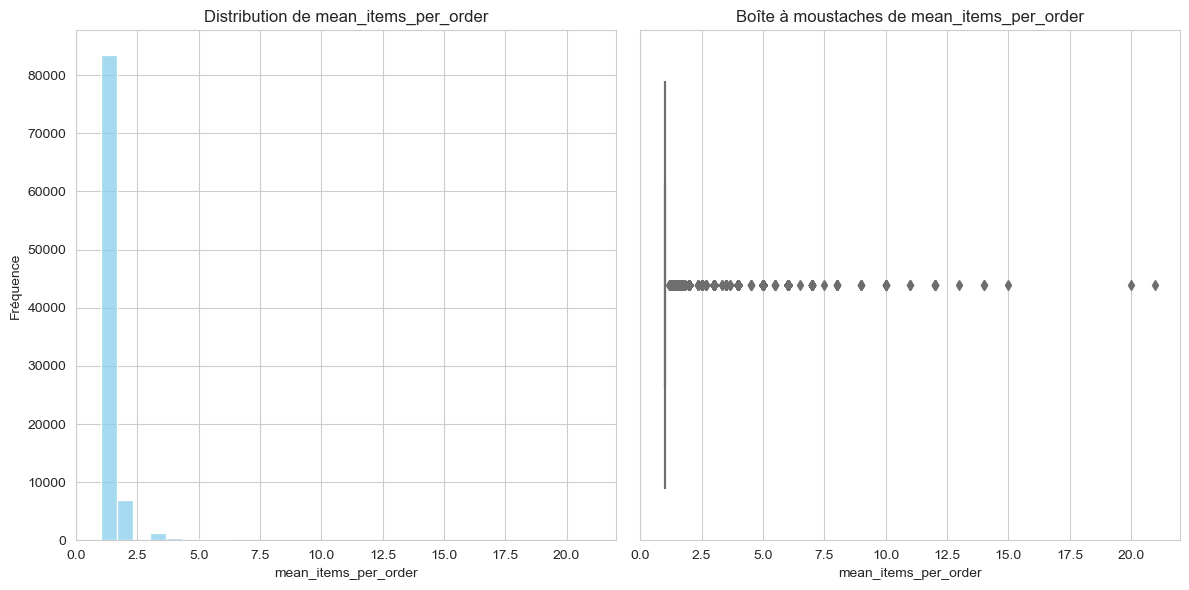

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


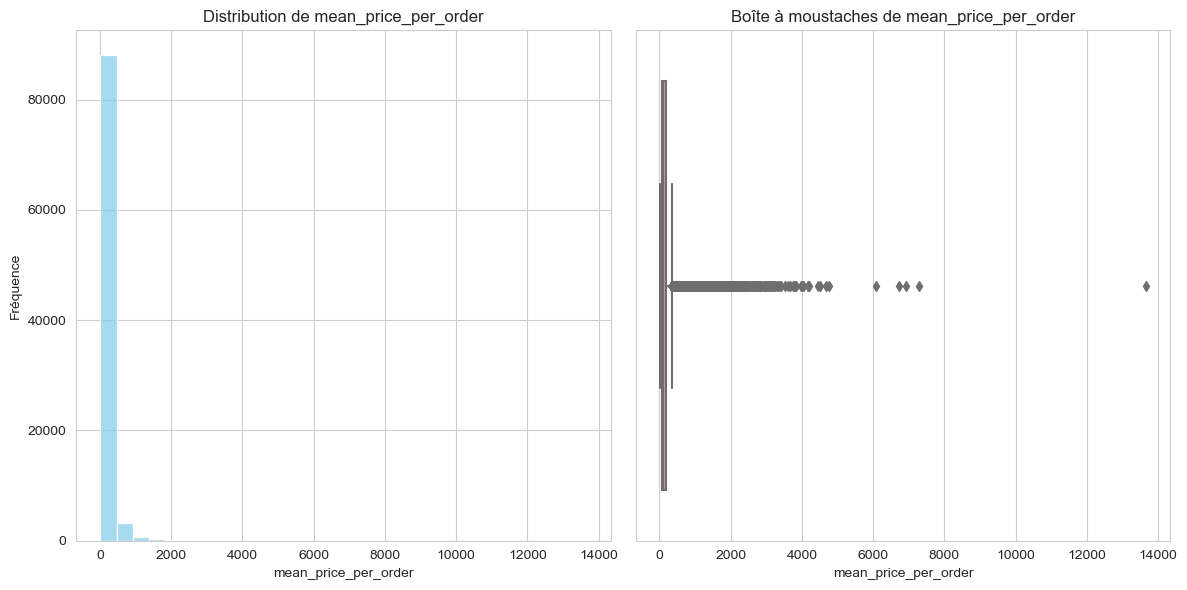

In [68]:
# Définir le style des graphiques
sns.set_style("whitegrid")

# Boucle pour tracer les graphiques
for column in df_cust.select_dtypes(['int32', 'float64']).columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Distribution plot
    sns.histplot(df_cust[column], bins=30, ax=axes[0], color='skyblue')
    axes[0].set_title('Distribution de ' + column)
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Fréquence')
    
    # Box plot
    sns.boxplot(x=df_cust[column], ax=axes[1], color='lightcoral')
    axes[1].set_title('Boîte à moustaches de ' + column)
    axes[1].set_xlabel(column)
    
    # Réglages des subplots
    plt.tight_layout()
    plt.show()


## 2. Commandes & articles & clients

### a. Quel est le nombre de commande par client ?

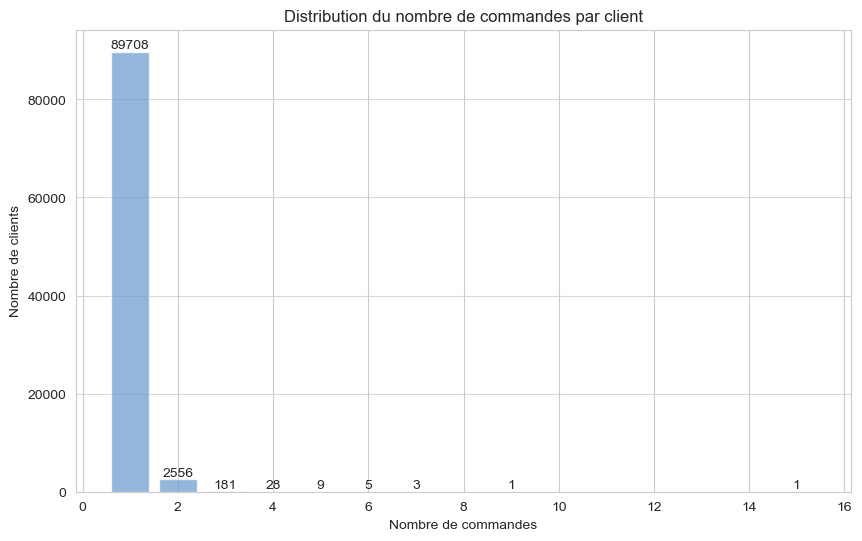

In [89]:
# Groupement par client et calcul du cumul des commandes
order_count_distribution = df_cust['total_orders']

# Tracer le graphique
plt.figure(figsize=(10, 6))
counts = order_count_distribution.value_counts().sort_index()
plt.bar(counts.index, counts.values, color='#6699cc', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Nombre de commandes')
plt.ylabel('Nombre de clients')
plt.title('Distribution du nombre de commandes par client')
# Ajouter des étiquettes de valeurs
for x, y in zip(counts.index, counts.values):
    plt.text(x, y, str(int(y)), ha='center', va='bottom')

plt.show()


In [197]:
# Calculer la fréquence du nombre de commandes par client
order_count_frequency = df_cust['total_orders'].value_counts(normalize=True).reset_index()
order_count_frequency.columns = ['Nombre de commandes', 'Fréquence']

# Calculer le nombre de commandes en valeur absolue
order_count_absolute = df_cust['total_orders'].value_counts().reset_index()
order_count_absolute.columns = ['Nombre de commandes', 'Nombre de clients']

# Fusionner les deux dataframes
order_count_frequency = order_count_frequency.merge(order_count_absolute, on='Nombre de commandes')

# Trier les valeurs par le nombre de commandes
order_count_frequency = order_count_frequency.sort_values(by='Nombre de commandes')

# Afficher le tableau
order_count_frequency

Nombre de commandes  Fréquence  Nombre de clients
0                    1   0.969900              89708
1                    2   0.027635               2556
2                    3   0.001957                181
3                    4   0.000303                 28
4                    5   0.000097                  9
5                    6   0.000054                  5
6                    7   0.000032                  3
7                    9   0.000011                  1
8                   15   0.000011                  1

### b. Quel est le nombre d'articles commandés par client ?

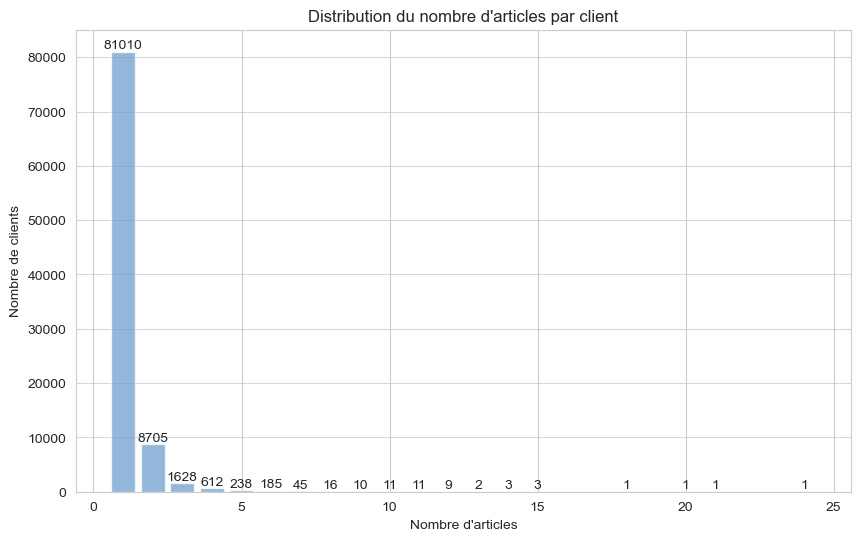

In [90]:
# Groupement par client et calcul du cumul des commandes
item_count_distribution = df_cust['total_items']

# Tracer le graphique
plt.figure(figsize=(10, 6))
counts = item_count_distribution.value_counts().sort_index()
plt.bar(counts.index, counts.values, color='#6699cc', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Nombre d\'articles')
plt.ylabel('Nombre de clients')
plt.title('Distribution du nombre d\'articles par client')
# Ajouter des étiquettes de valeurs
for x, y in zip(counts.index, counts.values):
    plt.text(x, y, str(int(y)), ha='center', va='bottom')

plt.show()

In [202]:
# Calculer la fréquence du nombre d'articles par client
item_count_frequency = df_cust['total_items'].value_counts(normalize=True).reset_index()
item_count_frequency.columns = ['Nombre d\'articles', 'Fréquence']

# Calculer le nombre d'articles en valeur absolue
item_count_absolute = df_cust['total_items'].value_counts().reset_index()
item_count_absolute.columns = ['Nombre d\'articles', 'Nombre de clients']

# Fusionner les deux dataframes
item_count_frequency = item_count_frequency.merge(item_count_absolute, on='Nombre d\'articles')

# Trier les valeurs par le nombre d'articles
item_count_frequency = item_count_frequency.sort_values(by='Nombre d\'articles')

# Afficher le tableau
item_count_frequency

Nombre d'articles  Fréquence  Nombre de clients
0                   1   0.875860              81010
1                   2   0.094116               8705
2                   3   0.017602               1628
3                   4   0.006617                612
4                   5   0.002573                238
5                   6   0.002000                185
6                   7   0.000487                 45
7                   8   0.000173                 16
10                  9   0.000108                 10
8                  10   0.000119                 11
9                  11   0.000119                 11
11                 12   0.000097                  9
14                 13   0.000022                  2
13                 14   0.000032                  3
12                 15   0.000032                  3
15                 18   0.000011                  1
17                 20   0.000011                  1
16                 21   0.000011                  1
18                 24   0.000011                  1

## 2. La localisation des clients

### a. Projection des individus sur une carte du Brésil 

In [263]:
# Définir les limites géographiques du Brésil
lat_min, lat_max = -33.75, 5.25
lon_min, lon_max = -74.25, -34.75

# Filtrer les données pour exclure les valeurs aberrantes
df_brazil = df_cust[(df_cust['geolocation_lat_most_frequent'] >= lat_min) & 
                    (df_cust['geolocation_lat_most_frequent'] <= lat_max) &
                    (df_cust['geolocation_lng_most_frequent'] >= lon_min) & 
                    (df_cust['geolocation_lng_most_frequent'] <= lon_max)]

# Créer une carte centrée sur le Brésil
m = folium.Map(location=[-15.77972, -47.92972], zoom_start=4)

# Convertir les données en une liste de listes (latitude, longitude)
heat_data = [[row['geolocation_lat_most_frequent'], row['geolocation_lng_most_frequent']] for index, row in df_brazil.iterrows()]

# Ajouter une carte de densité de chaleur avec un rayon et un flou plus petits
HeatMap(heat_data, radius=7, blur=7).add_to(m)

# Afficher la carte
m.save('brazil_customer_heatmap.html') 

C:\Users\justi\AppData\Local\Temp\ipykernel_19460\374358355.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


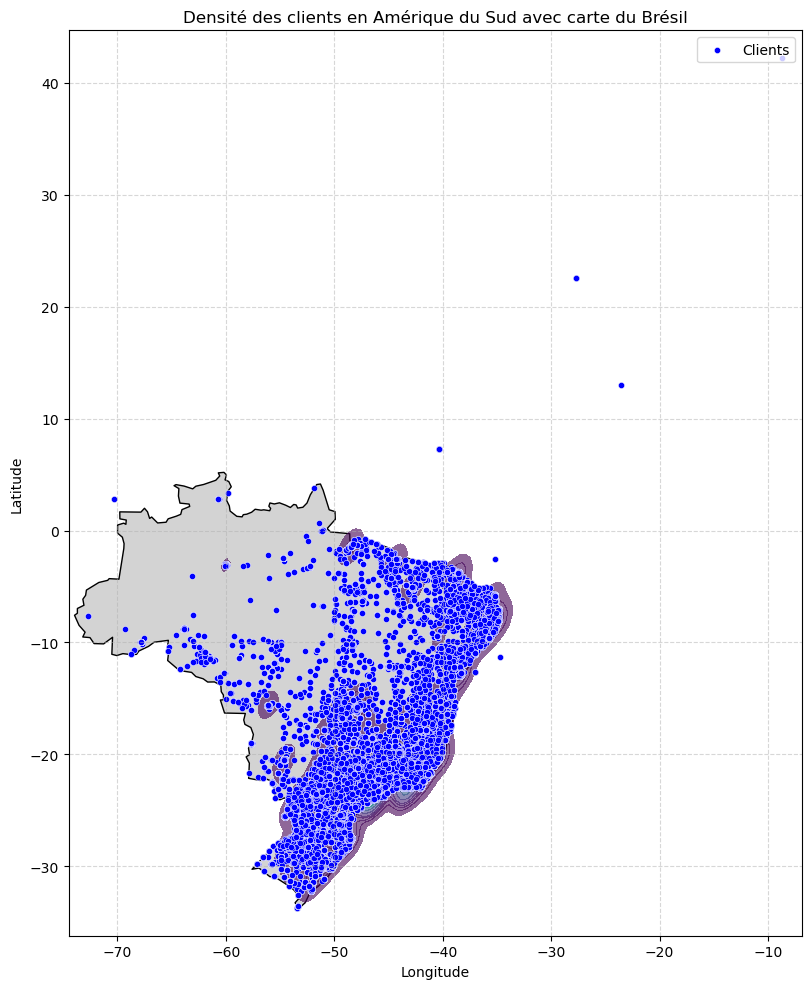

In [141]:
# Charger les données géographiques du Brésil
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
brazil = brazil[brazil.name == 'Brazil']

# Créer une figure et des axes
fig, ax = plt.subplots(figsize=(12, 10))

# Carte du Brésil avec les régions
brazil.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1)

# Créer une heatmap pour la densité des clients en Amérique du Sud
sns.kdeplot(x=df_cust['geolocation_lng_most_frequent'], 
            y=df_cust['geolocation_lat_most_frequent'], 
            cmap="viridis", fill=True, alpha=0.6, ax=ax)

# Points des clients en Amérique du Sud
sns.scatterplot(x=df_cust['geolocation_lng_most_frequent'], 
                y=df_cust['geolocation_lat_most_frequent'], 
                color='blue', marker='o', s=20, label='Clients', ax=ax)

# Légende
plt.legend(loc='upper right', fontsize='medium')
plt.title("Densité des clients en Amérique du Sud avec carte du Brésil")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### b. Répartition selon les régions & les villes

In [145]:
# Modifier les valeurs de la colonne customer_state_most_frequent en utilisant le dictionnaire
df_cust['customer_state_most_frequent'] = df_cust['customer_state_most_frequent'].map(regions_bresil)

# Dataframe pour l'analyse 
df_cust_2b = df_cust[['customer_state_most_frequent','customer_unique_id','total_orders','payment_value_sum']]

# Agrégation des données
df_cust_2b = df_cust_2b.groupby('customer_state_most_frequent').agg({
    'customer_unique_id': 'nunique',
    'total_orders': 'sum',
    'payment_value_sum': 'sum'
}).reset_index()

# Renommer les colonnes agrégées
df_cust_2b.rename(columns={
    'customer_unique_id': 'unique_customer_count',
    'total_orders': 'total_order_count',
    'payment_value_sum': 'total_payment_value'
}, inplace=True)

# Trier les valeurs selon total_order_count en ordre décroissant
df_cust_2b = df_cust_2b.sort_values(by='total_order_count', ascending=False)

# Calculer le nombre total de clients
total_customers = df_cust_2b['unique_customer_count'].sum()

# Calculer la valeur relative du nombre de clients par région
df_cust_2b['relative_customer_count'] = df_cust_2b['unique_customer_count'] / total_customers * 100

# Afficher le DataFrame agrégé
df_cust_2b

customer_state_most_frequent  unique_customer_count  total_order_count  \
25                    São Paulo                  38900              40242   
20               Rio de Janeiro                  11775              12210   
12                 Minas Gerais                  10925              11283   
19            Rio Grande do Sul                   5145               5323   
13                       Paraná                   4737               4895   
23               Santa Catarina                   3419               3518   
4                         Bahia                   3125               3225   
7                Espirito Santo                   1900               1967   
8                         Goiás                   1875               1939   
6              District fédéral                   1852               1914   
16                   Pernambouc                   1531               1576   
5                         Ceará                   1249               1271   
15                         Pará                    909                933   
10                  Mato Grosso                    847                875   
9                      Maranhão                    691                708   
11           Mato Grosso do Sul                    679                700   
14                      Paraíba                    497                512   
17                        Piauí                    457                469   
18          Rio Grande do Norte                    459                469   
1                       Alagoas                    383                393   
24                      Sergipe                    324                330   
26                    Tocantins                    265                272   
21                     Rondônia                    228                240   
3                      Amazonas                    139                144   
0                          Acre                     76                 80   
2                         Amapá                     65                 66   
22                      Roraima                     40                 41   

    total_payment_value  relative_customer_count  
25           5734215.43                42.057691  
20           2027510.04                12.730831  
12           1804421.90                11.811832  
19            858452.88                 5.562643  
13            779393.00                 5.121524  
23            586235.19                 3.696536  
4             586299.88                 3.378671  
7             305444.30                 2.054232  
8             329856.76                 2.027202  
6             318774.51                 2.002335  
16            306547.17                 1.655278  
5             264395.37                 1.350387  
15            207789.54                 0.982788  
10            179650.59                 0.915755  
9             145682.40                 0.747092  
11            134160.01                 0.734118  
14            134918.38                 0.537344  
17            104063.80                 0.494097  
18             99796.81                 0.496259  
1              92451.24                 0.414090  
24             68666.36                 0.350301  
26             59711.91                 0.286511  
21             56585.65                 0.246508  
3              27500.67                 0.150283  
0              19586.25                 0.082169  
2              16071.43                 0.070276  
22              9039.52                 0.043247

### c. Est-ce que le temps de transport varie selon la localisation du client ? 

In [267]:
# Définir les limites géographiques du Brésil
lat_min, lat_max = -33.75, 5.25
lon_min, lon_max = -74.25, -34.75

# Filtrer les données pour exclure les valeurs aberrantes
df_brazil = df_cust[(df_cust['geolocation_lat_most_frequent'] >= lat_min) & 
                    (df_cust['geolocation_lat_most_frequent'] <= lat_max) &
                    (df_cust['geolocation_lng_most_frequent'] >= lon_min) & 
                    (df_cust['geolocation_lng_most_frequent'] <= lon_max)]

# Créer une carte centrée sur le Brésil
m = folium.Map(location=[-15.77972, -47.92972], zoom_start=4)

# Convertir les données en une liste de listes (latitude, longitude, poids)
heat_data = [[row['geolocation_lat_most_frequent'], row['geolocation_lng_most_frequent'], row['time_shipping_mean']] for index, row in df_brazil.iterrows()]

# Ajouter une carte de densité de chaleur avec les temps de livraison comme poids
HeatMap(heat_data, radius=7, blur=7, gradient={0.1: 'blue', 0.5: 'green', 0.9: 'red'}).add_to(m)

# Afficher la carte
m.save('brazil_shipping_heatmap.html')  # Sauvegarder la carte au format HTML


## 3. Les paiements & chiffre d'affaires

### a. Evolution du chiffre d'affaires mensuel

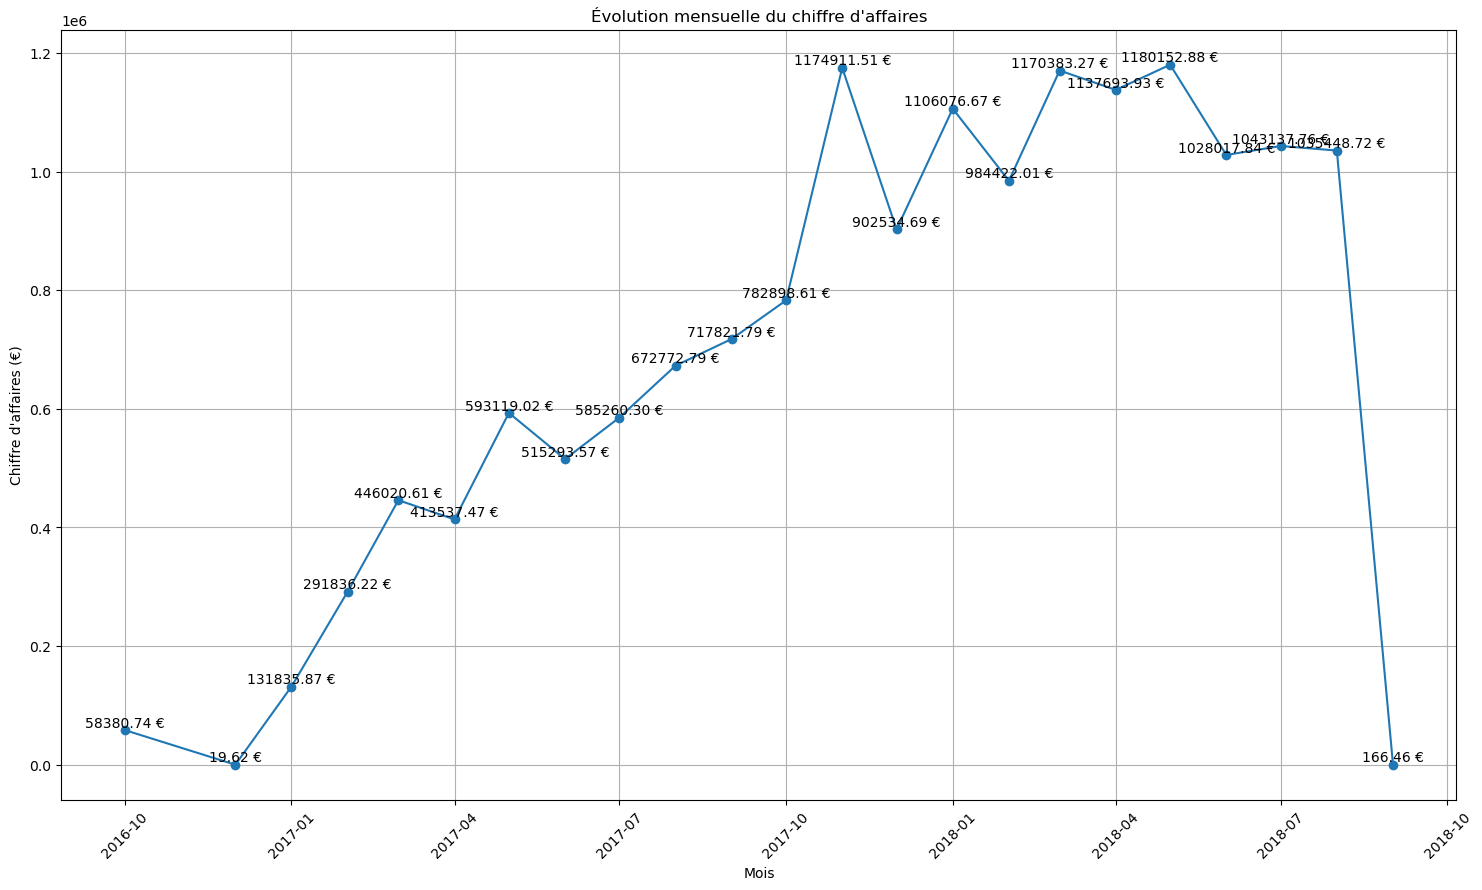

In [231]:
# Jointure entre les deux tables où la table products vient compléter la table order_items
df_CA = pd.merge(df_order_pymts, df_orders, how='left', on='order_id')

# Convertir la colonne order_approved_at en type datetime
df_CA['order_approved_at'] = pd.to_datetime(df_CA['order_approved_at'])

# Ajouter une nouvelle colonne pour extraire le mois
df_CA['month'] = df_CA['order_approved_at'].dt.to_period('M')

# Calculer le chiffre d'affaires mensuel
monthly_revenue = df_CA.groupby('month')['payment_value'].sum()

# Créer un DataFrame dédié pour stocker les données du chiffre d'affaires mensuel
df_monthly_revenue = pd.DataFrame({
    'month': monthly_revenue.index,
    'revenue': monthly_revenue.values
})

# Convertir les objets Period en datetime
df_monthly_revenue['month_datetime'] = df_monthly_revenue['month'].dt.to_timestamp()

# Tracer l'évolution du chiffre d'affaires mensuel
plt.figure(figsize=(18, 10))
plt.plot(df_monthly_revenue['month_datetime'], df_monthly_revenue['revenue'], marker='o')
plt.title("Évolution mensuelle du chiffre d'affaires")
plt.xlabel("Mois")
plt.ylabel("Chiffre d'affaires (€)")
plt.xticks(rotation=45)
plt.grid(True)

# Ajouter des étiquettes de données (valeurs) aux points de données
for i, txt in enumerate(df_monthly_revenue['revenue']):
    plt.text(df_monthly_revenue['month_datetime'][i], txt, f"{txt:.2f} €", ha='center', va='bottom')

plt.show()


### b. Evolution du chiffre d'affaires mensuel en cumulé

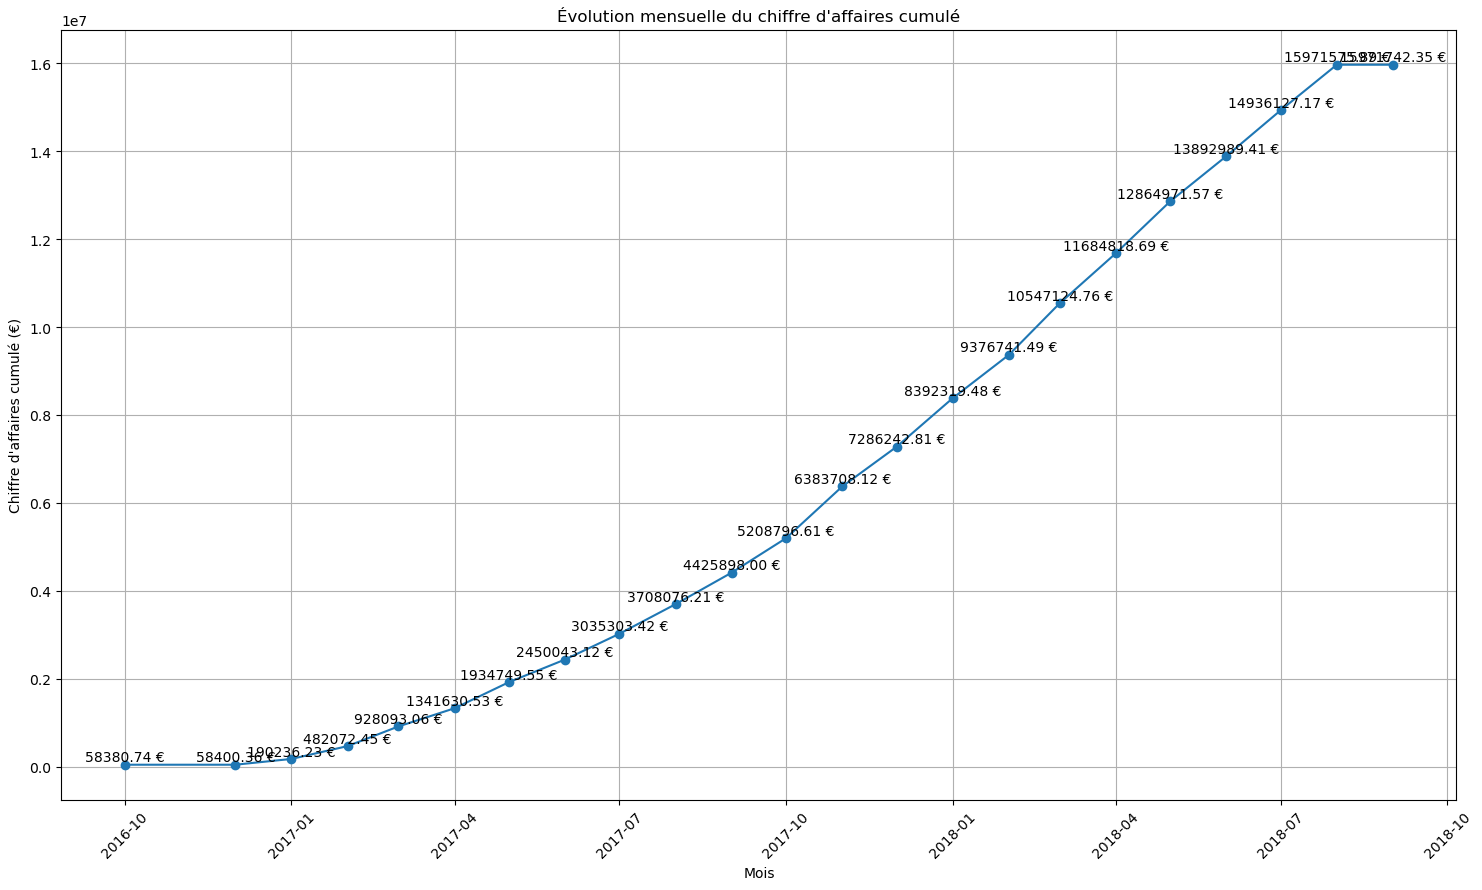

In [230]:
# Ajouter une nouvelle colonne pour extraire le mois
df_CA['month'] = df_CA['order_approved_at'].dt.to_period('M')

# Calculer le chiffre d'affaires mensuel
monthly_revenue = df_CA.groupby('month')['payment_value'].sum()

# Calculer le chiffre d'affaires mensuel cumulé
cumulative_monthly_revenue = monthly_revenue.cumsum()

# Créer un DataFrame dédié pour stocker les données du chiffre d'affaires mensuel cumulé
df_cumulative_monthly_revenue = pd.DataFrame({
    'month': cumulative_monthly_revenue.index,
    'cumulative_revenue': cumulative_monthly_revenue.values
})

# Convertir les objets Period en datetime
df_cumulative_monthly_revenue['month_datetime'] = df_cumulative_monthly_revenue['month'].dt.to_timestamp()

# Tracer l'évolution du chiffre d'affaires mensuel cumulé
plt.figure(figsize=(18, 10))
plt.plot(df_cumulative_monthly_revenue['month_datetime'], df_cumulative_monthly_revenue['cumulative_revenue'], marker='o')
plt.title("Évolution mensuelle du chiffre d'affaires cumulé")
plt.xlabel("Mois")
plt.ylabel("Chiffre d'affaires cumulé (€)")
plt.xticks(rotation=45)
plt.grid(True)

# Ajouter des étiquettes de données (valeurs) aux points de données
for i, txt in enumerate(df_cumulative_monthly_revenue['cumulative_revenue']):
    plt.text(df_cumulative_monthly_revenue['month_datetime'][i], txt, f"{txt:.2f} €", ha='center', va='bottom')

plt.show()


### c. Répartition de la valeur & des clients selon le mode de paiement

In [247]:
# Grouper par mode de paiement, puis calculer la somme du chiffre d'affaires pour chaque groupe
payment_type = df_cust.groupby('payment_type_most_frequent')['payment_value_sum'].sum().reset_index()

# Calculer le chiffre d'affaires total pour chaque mode de paiement
total_revenue = payment_type['payment_value_sum'].sum()

# Calculer la valeur relative du chiffre d'affaires pour chaque mode de paiement
payment_type['relative_value'] = (payment_type_revenue['payment_value_sum'] / total_revenue) * 100

# Trier les résultats dans l'ordre décroissant selon le chiffre d'affaires
payment_type = payment_type.sort_values(by='payment_value_sum', ascending=False)

# Afficher le résultat
payment_type


payment_type_most_frequent  payment_value_sum  relative_value
1                credit_card        12090697.29       79.245737
0                     boleto         2768012.90       18.142314
2                 debit_card          200923.24        1.316906
3                    voucher          197587.56        1.295043

In [95]:
# Grouper par mode de paiement, puis compter le nombre de clients uniques dans chaque groupe
payment_type_client = df_cust.groupby('payment_type_most_frequent')['customer_unique_id'].nunique().reset_index()

# Calculer le nombre total de clients
total_clients = payment_type_client['customer_unique_id'].sum()

# Calculer la proportion relative de clients pour chaque mode de paiement
payment_type_client['relative_client_count'] = (payment_type_client['customer_unique_id'] / total_clients) * 100

# Trier les résultats dans l'ordre décroissant selon le nombre de clients
payment_type_client = payment_type_client.sort_values(by='customer_unique_id', ascending=False)

# Afficher le résultat
payment_type_client

payment_type_most_frequent  customer_unique_id  relative_client_count
1                credit_card               70838              76.588245
0                     boleto               18530              20.034165
3                    voucher                1709               1.847727
2                 debit_card                1415               1.529862

A la lecture de ces deux graphiques, nous pouvons voir que deux catégories se distinguent nettement, 'la carte de crédit & les billets'. La stratégie opérée par le one hot encoder sur toutes les colonnes semblent peu pertinente ou appropriée au contexte. Un segmentation binaire serait sûrement plus juste -- Carte de crédit et les 3 catégories.

### d. Répartition de la valeur des articles selon les catégories

In [98]:
# Sélection des colonnes commençant par le préfixe "cat_"
cat_columns = [col for col in df_cust.columns if col.startswith('cat_')]

# Calcul du cumul de chaque colonne
cat_totals = df_cust[cat_columns].sum()

# Tri des valeurs dans l'ordre décroissant
cat_totals_sorted = cat_totals.sort_values(ascending=False)

# Calcul du pourcentage sans cumul
total_sum = cat_totals_sorted.sum()
percentage = (cat_totals_sorted / total_sum) * 100

# Calcul du pourcentage cumulé
cumulative_percentage = percentage.cumsum()

# Création d'un DataFrame pour le tableau
table_data = pd.DataFrame({'Catégories': cat_totals_sorted.index,
                           'Valeur totale': cat_totals_sorted.values,
                           'Pourcentage sans cumul': percentage,
                           'Pourcentage cumulé': cumulative_percentage})
# Affichage du tableau
table_data

Catégories  Valeur totale  \
cat_Home_Furniture                cat_Home_Furniture     2926290.15   
cat_Miscellaneous                  cat_Miscellaneous     2065719.36   
cat_Electronics_Computers  cat_Electronics_Computers     1981736.89   
cat_Health_Beauty                  cat_Health_Beauty     1609640.28   
cat_Entertainment                  cat_Entertainment     1511319.50   
cat_Baby_Kids                          cat_Baby_Kids     1074483.62   
cat_Automotive                        cat_Automotive      622812.70   
cat_Home_Garden                      cat_Home_Garden      509976.26   
cat_Tools_Construction        cat_Tools_Construction      340822.28   
cat_Fashion_Clothing            cat_Fashion_Clothing      194462.80   
cat_Other                                  cat_Other      174851.05   
cat_Food_Drink                        cat_Food_Drink       66639.96   

                           Pourcentage sans cumul  Pourcentage cumulé  
cat_Home_Furniture                      22.374379           22.374379  
cat_Miscellaneous                       15.794465           38.168844  
cat_Electronics_Computers               15.152336           53.321180  
cat_Health_Beauty                       12.307290           65.628470  
cat_Entertainment                       11.555530           77.184000  
cat_Baby_Kids                            8.215489           85.399489  
cat_Automotive                           4.762018           90.161507  
cat_Home_Garden                          3.899272           94.060779  
cat_Tools_Construction                   2.605923           96.666702  
cat_Fashion_Clothing                     1.486860           98.153563  
cat_Other                                1.336909           99.490472  
cat_Food_Drink                           0.509528          100.000000

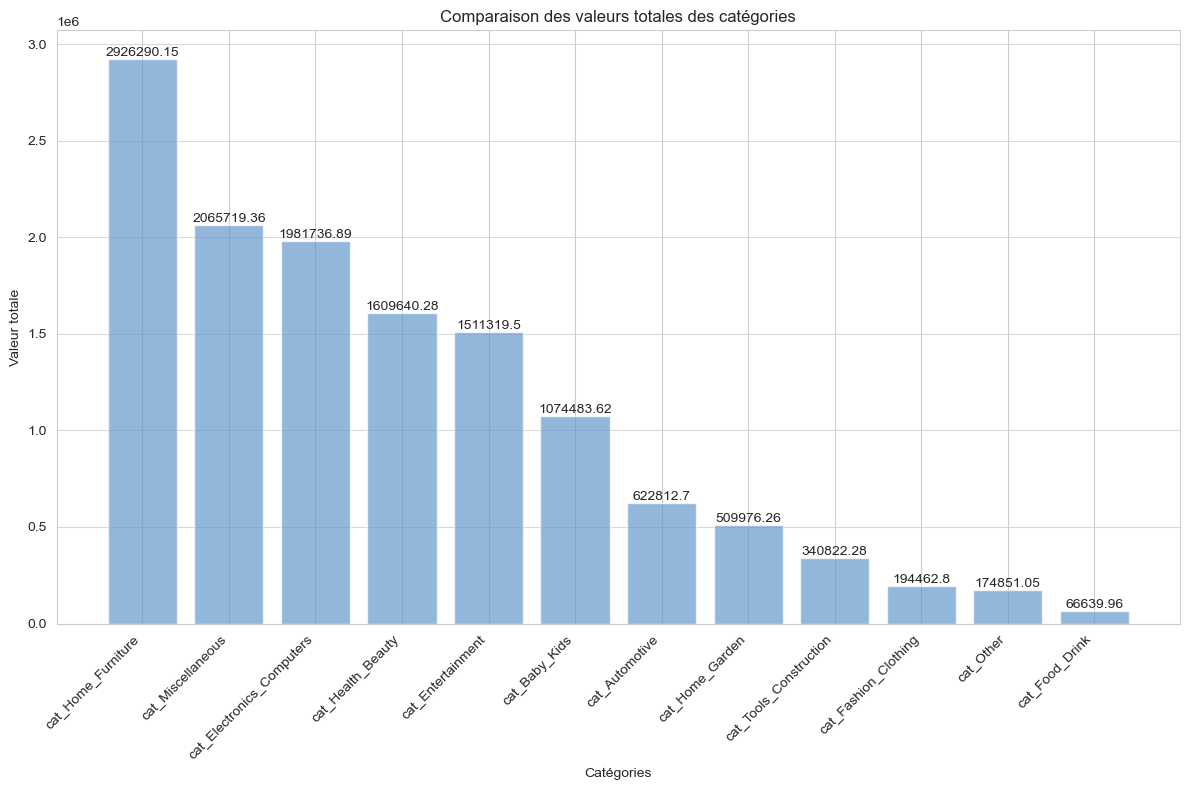

In [102]:
# Sélection des colonnes commençant par le préfixe "cat_"
cat_columns = [col for col in df_cust.columns if col.startswith('cat_')]

# Calcul du cumul de chaque colonne
cat_totals = df_cust[cat_columns].sum()

# Tri des valeurs dans l'ordre décroissant
cat_totals_sorted = cat_totals.sort_values(ascending=False)

# Création d'une liste d'index numériques pour les barres
indexes = np.arange(len(cat_totals_sorted))

# Tracer le graphique
plt.figure(figsize=(12, 8))

# Barres
bars = plt.bar(indexes, cat_totals_sorted.values, color='#6699cc', alpha=0.7, label='Valeur totale')

# Étiquettes de valeur
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.xlabel('Catégories')
plt.ylabel('Valeur totale')
plt.title('Comparaison des valeurs totales des catégories')

# Affichage des étiquettes de catégories
plt.xticks(indexes, cat_totals_sorted.index, rotation=45, ha='right')

plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


Nous pouvons améliorer nos catégories, en regroupant certaines d'entres elles,  car certaines sont peu représentées et créée des variables peu exploitables.

## 4. La satisfaction client

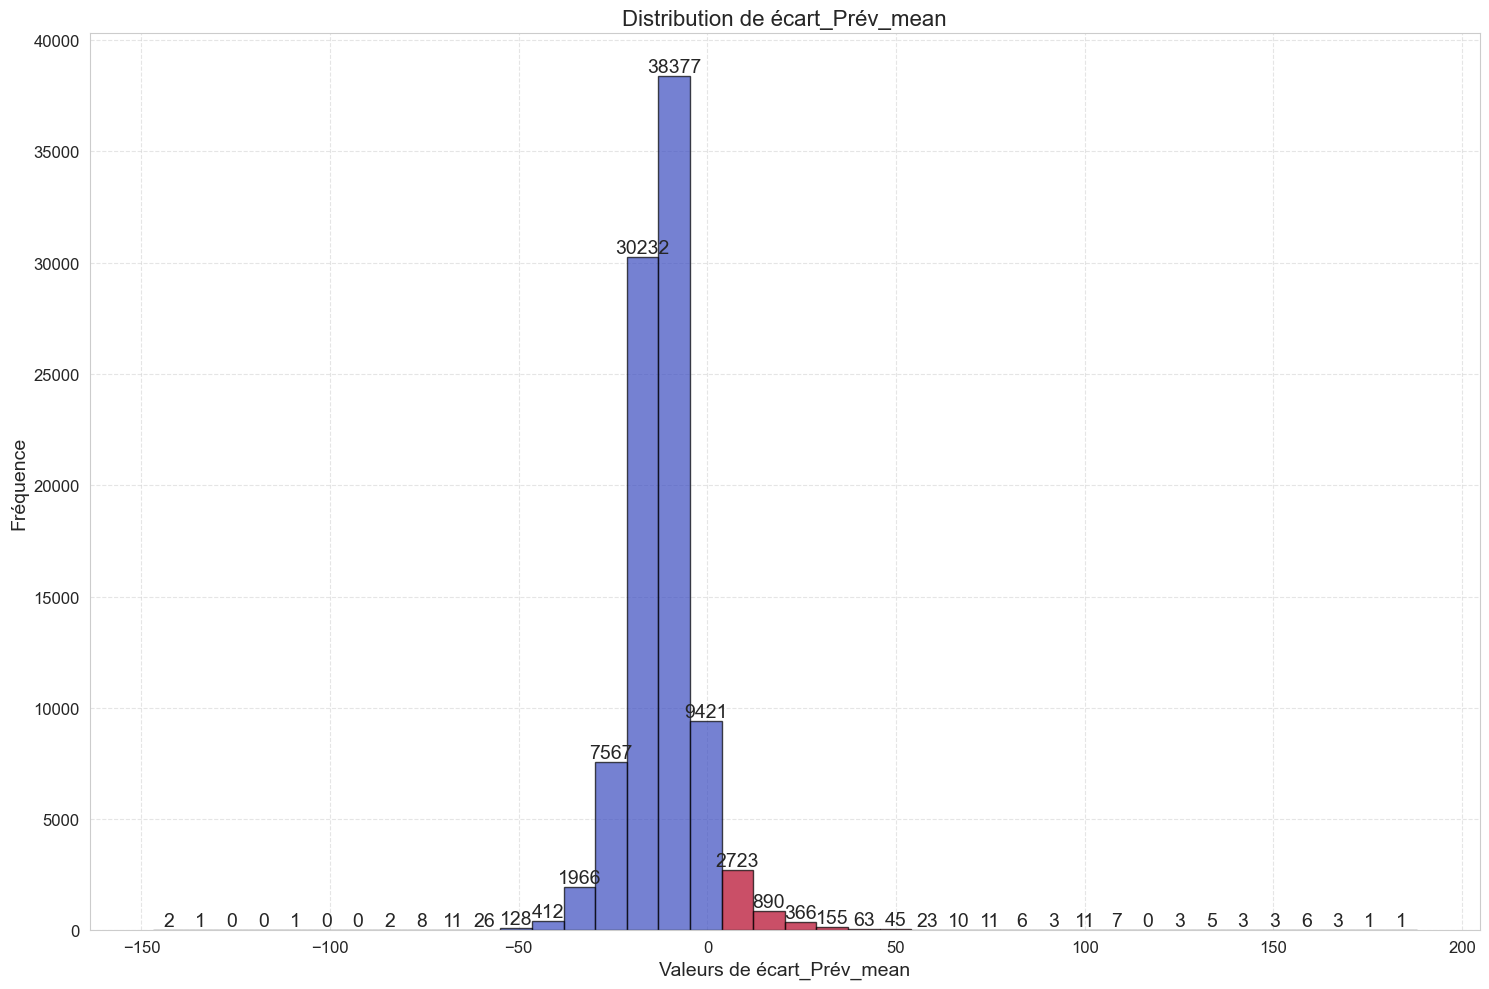

In [260]:
# Déterminer les limites des couleurs
max_value = df_cust['écart_Prév_mean'].max()
min_value = df_cust['écart_Prév_mean'].min()

# Créer une colormap personnalisée allant du rouge au bleu
cmap = plt.cm.coolwarm

# Tracer l'histogramme
plt.figure(figsize=(15, 10))
n, bins, patches = plt.hist(df_cust['écart_Prév_mean'], bins=40, edgecolor='black', alpha=0.7)

for i in range(len(patches)):
    if bins[i] < 0:
        color = cmap(0)
    else:
        color = cmap(255)

    # Coloration de la barre
    patches[i].set_facecolor(color)

    # Ajouter des étiquettes de valeurs
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height()
    plt.text(x, y, f'{int(y)}', ha='center', va='bottom', fontsize=14)

plt.title('Distribution de écart_Prév_mean', fontsize=16)
plt.xlabel('Valeurs de écart_Prév_mean', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

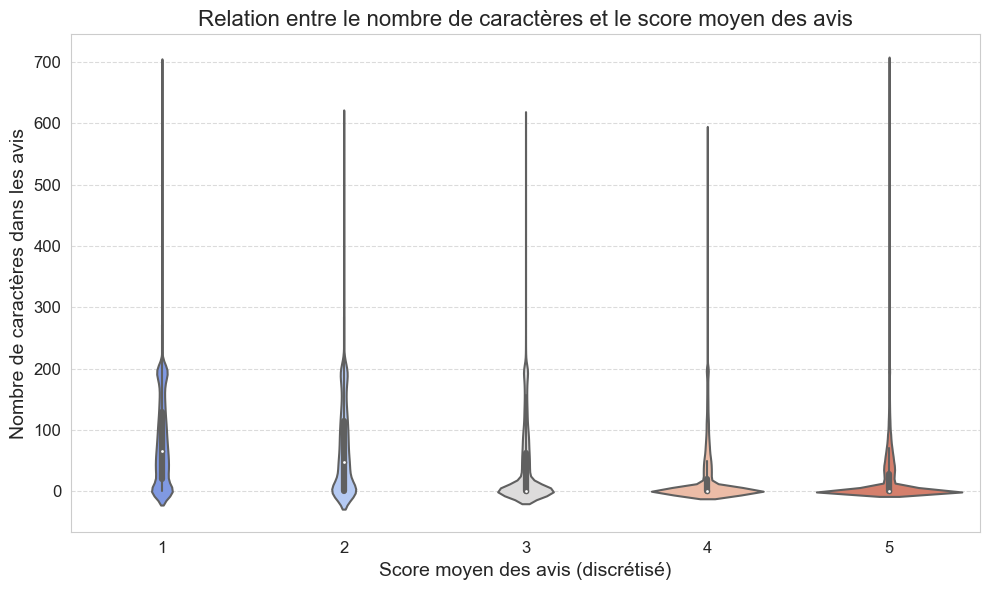

In [122]:
# Copie du df pour ne pas modifier le df_cust
df_exp = df_cust.copy()

# Discrétisation de la variable review_score
review_score_discret = np.ceil(df_exp['avg_review_score_mean']).astype(int)

# Définition des couleurs
colors = sns.color_palette('coolwarm', n_colors=5)

# Tracer le violin plot avec la variable discrétisée
plt.figure(figsize=(10, 6))
sns.violinplot(x=review_score_discret, y=df_exp['total_characters_review_comment_message_sum'], palette=colors, linewidth=1.5)

plt.title('Relation entre le nombre de caractères et le score moyen des avis', fontsize=16)
plt.xlabel('Score moyen des avis (discrétisé)', fontsize=14)
plt.ylabel('Nombre de caractères dans les avis', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

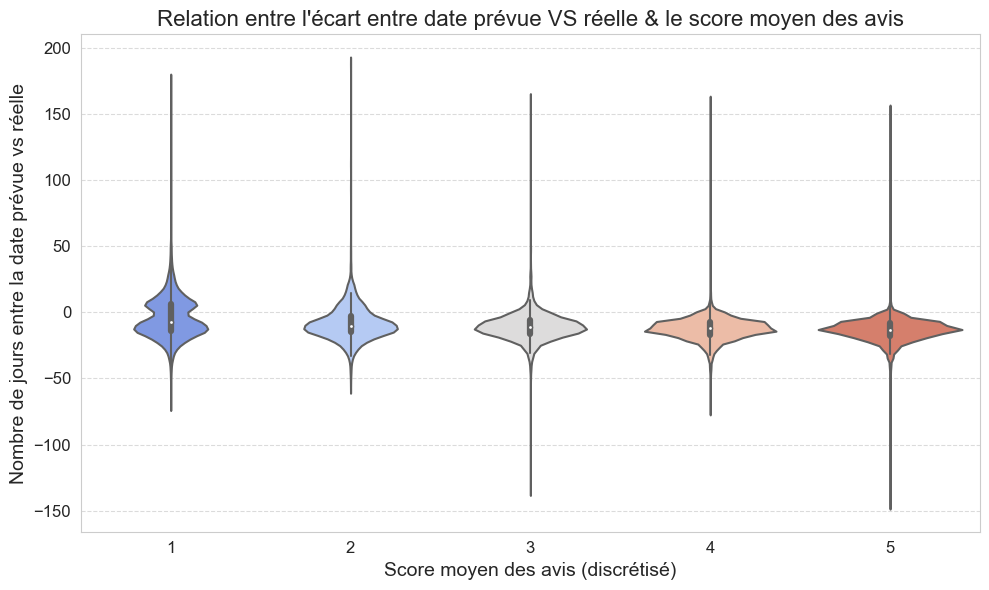

In [127]:
# Discrétisation de la variable review_score
review_score_discret = np.ceil(df_exp['avg_review_score_mean']).astype(int)

# Définition des couleurs
colors = sns.color_palette('coolwarm', n_colors=5)

# Tracer le violin plot avec la variable discrétisée
plt.figure(figsize=(10, 6))
sns.violinplot(x=review_score_discret, y=df_exp['écart_Prév_mean'], palette=colors, linewidth=1.5)

plt.title('Relation entre l\'écart entre date prévue VS réelle & le score moyen des avis', fontsize=16)
plt.xlabel('Score moyen des avis (discrétisé)', fontsize=14)
plt.ylabel('Nombre de jours entre la date prévue vs réelle', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## 5. Evolution dans le temps des données

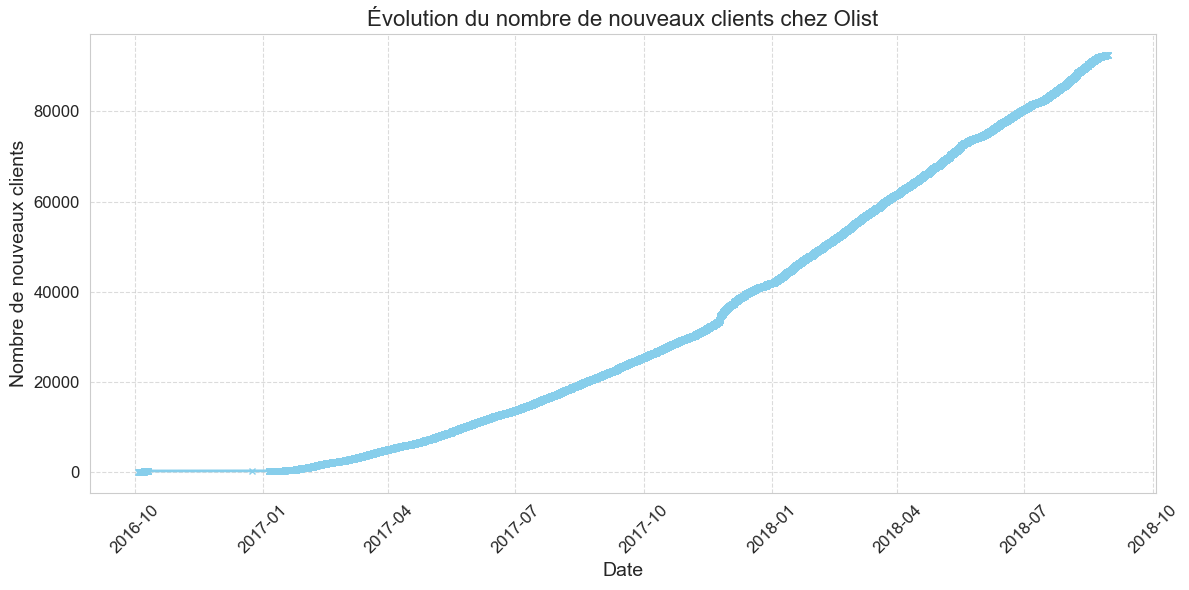

In [259]:
# Evolution du nombre de nouveaux clients chez Olist
df_new_customers = df_cust.copy()

# Convertir la colonne oldest_purch_date en type datetime si ce n'est pas déjà fait
df_new_customers['oldest_order_purchase'] = pd.to_datetime(df_new_customers['oldest_order_purchase'])

# Trier le DataFrame par date d'achat la plus ancienne
df_new_customers.sort_values(by='oldest_order_purchase', inplace=True)

# Ajouter une colonne indiquant si un client est un nouveau client à chaque date
df_new_customers['new_customer'] = df_new_customers.groupby('customer_unique_id')['oldest_order_purchase'].transform('min') == df_new_customers['oldest_order_purchase']

# Grouper par date d'achat la plus ancienne et compter le nombre de nouveaux clients
new_customers_count = df_new_customers.groupby('oldest_order_purchase')['new_customer'].sum().cumsum()

# Créer un DataFrame dédié pour l'évolution du nombre de nouveaux clients
df_new_customers_evolution = pd.DataFrame({'date': new_customers_count.index, 'new_customers_count': new_customers_count.values})

# Utiliser le style seaborn
sns.set_style("whitegrid")

# Tracer l'évolution du nombre de nouveaux clients
plt.figure(figsize=(12, 6))
plt.plot(df_new_customers_evolution['date'], df_new_customers_evolution['new_customers_count'], marker='x', color='skyblue', linewidth=2, markersize=5)
plt.title("Évolution du nombre de nouveaux clients chez Olist", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Nombre de nouveaux clients", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 6. Tables des corrélations du dataset

C:\Users\justi\.conda\envs\env_projetno5_olist\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


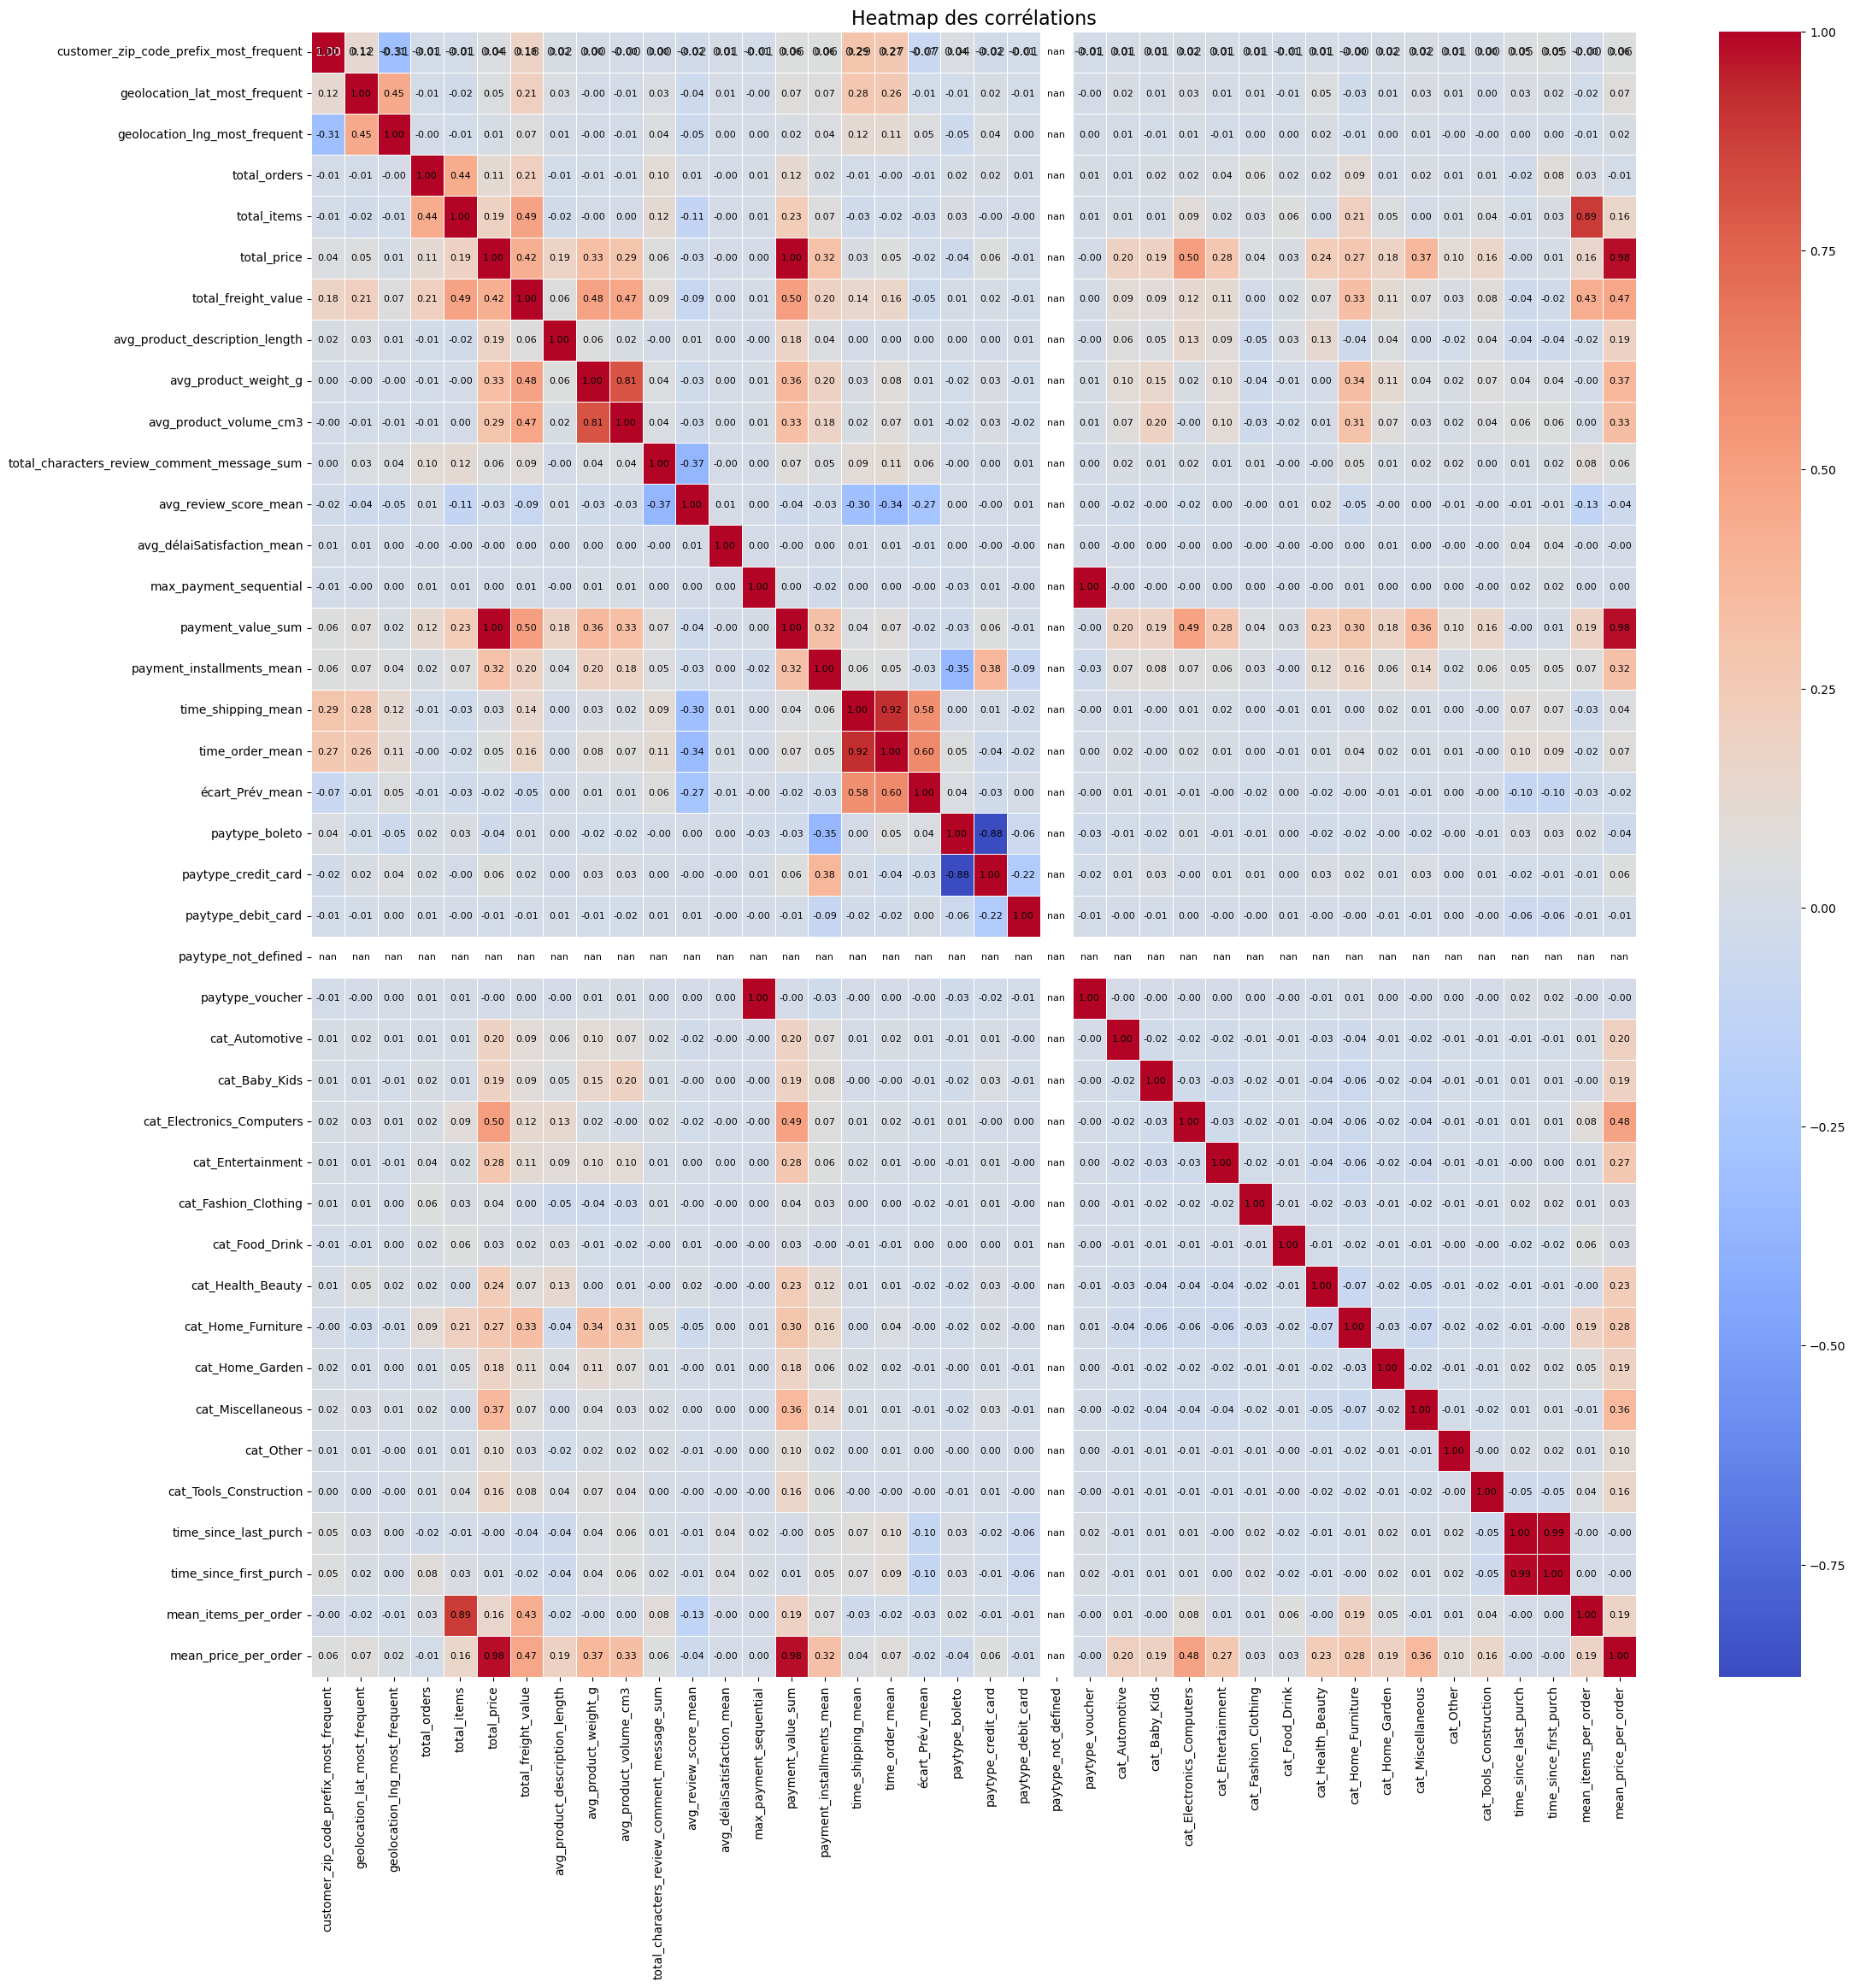

In [77]:
# Sélectionner les colonnes de type int et float
numeric_cols = df_cust.select_dtypes(include=['int', 'float']).columns

# Calculer les corrélations
correlation_matrix = df_cust[numeric_cols].corr()

# Tracer la heatmap avec une annotation personnalisée
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Ajouter des annotations personnalisées pour contourner le message d'avertissement
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j + 0.5, i + 0.5, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', fontsize=8)

plt.title('Heatmap des corrélations', fontsize=16)
plt.show()


## 7. Analyse en composantes principales (avec toutes les variables)

### a. Préparation des données

In [3]:
# Sélectionner les colonnes de type int et float parmi celles filtrées
cols_int_float = df_cust.select_dtypes(include=['int', 'float']).columns

# Sélectionner les données correspondantes à ces colonnes
X = df_cust[cols_int_float]

# Stocker les colonnes dans un objet 'features"
features = cols_int_float

### b. Centrer-Réduire

In [4]:
# Scaler les données en utilisation la fonction de sklearn 'StandardScaler'
scaler = StandardScaler()

# Adapter le scaler aux données pour calculer la moyenne et l'écart-type
scaler.fit(X)

# Transformer les données originales en utilisant la moyenne et l'écart-type calculés
X_scaled = scaler.transform(X)

# Vérification que nos moyennes sont égales à 0 et nos écart-type à 1
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5    6    7    8    9   ...   33   34   35  \
mean  0.0 -0.0 -0.0  0.0  0.0 -0.0 -0.0  0.0 -0.0  0.0  ... -0.0  0.0  0.0   
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   

       36   37   38   39   40   41   42  
mean -0.0 -0.0 -0.0  0.0 -0.0 -0.0 -0.0  
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  

[2 rows x 43 columns]

### c. Application de la PCA

In [5]:
# Sélection du nombre de composantes
n_components = 20

# Instanciation de l'ACP
pca = PCA(n_components=n_components)

# Entrainement sur les données "X"
pca.fit(X_scaled)

PCA(n_components=20)

In [6]:
# Création d'une variable pour visualiser la valeur de la variance stockée par chacune des composantes
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round(2)

# Afficher les valeurs correspondantes
print(scree)
print(scree.cumsum().round(2))
print('Cumul:',sum(scree))

[11.53  8.6   6.57  5.31  4.86  4.75  4.35  3.47  3.1   2.74  2.71  2.65
  2.48  2.46  2.44  2.43  2.42  2.41  2.4   2.39]
[11.53 20.13 26.7  32.01 36.87 41.62 45.97 49.44 52.54 55.28 57.99 60.64
 63.12 65.58 68.02 70.45 72.87 75.28 77.68 80.07]
Cumul: 80.07000000000001


In [7]:
# Définir une variable pour stocker nos composantes
x_list = range(1, n_components+1)

### d. Graphique des éboulis & analyse des composantes

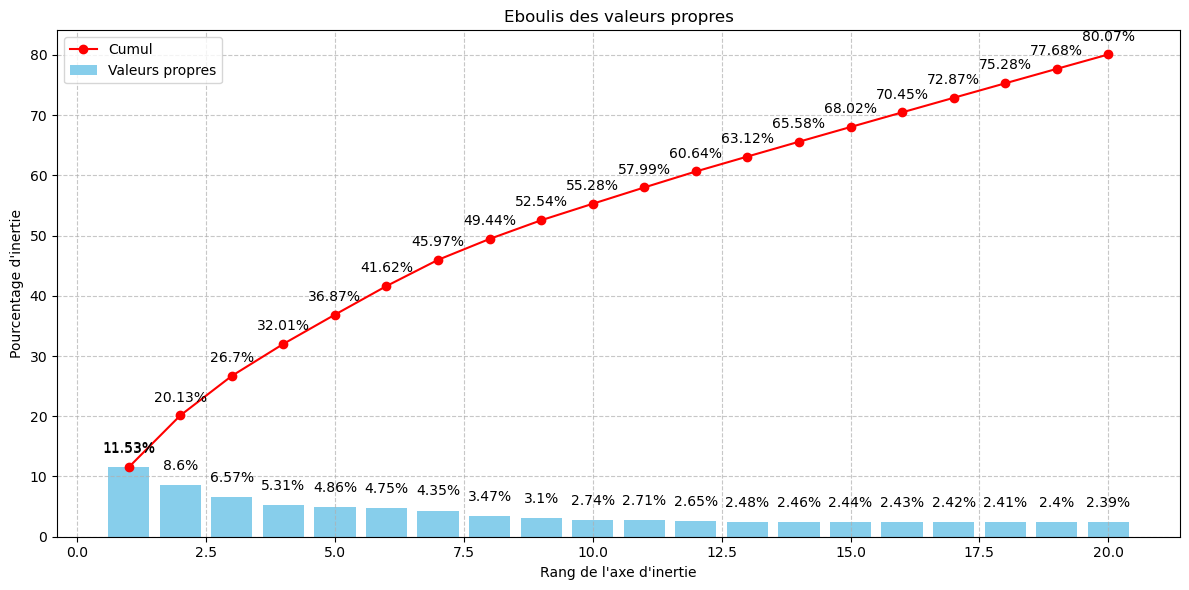

In [8]:
# Création d'un graphique pour afficher et illustrer ces résultats

plt.figure(figsize=(12, 6))

plt.bar(x_list, scree, color='skyblue', label='Valeurs propres')
plt.plot(x_list, scree_cum, c="red", marker='o', label='Cumul')

plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)

# Ajout des étiquettes de données
for i, value in enumerate(scree):
    plt.text(x_list[i], value + 2, f'{value}%', ha='center', va='bottom')

# Ajout d'annotations pour le cumul
for i, value in enumerate(scree_cum):
    plt.annotate(f'{value}%', (x_list[i], value), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

In [25]:
# Stockage des données de nos composantes dans un dataframe
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]

# Transposer le DataFrame
pcs = pcs.T

# Arrondir à deux chiffres après la virgule
pcs = pcs.round(2)
pcs

F1    F2    F3    F4    F5  \
customer_zip_code_prefix_most_frequent       0.05 -0.04  0.15  0.01 -0.05   
geolocation_lat_most_frequent                0.06 -0.03  0.21 -0.06  0.03   
geolocation_lng_most_frequent                0.02 -0.01  0.12 -0.07  0.08   
total_orders                                 0.07 -0.01 -0.03  0.24  0.15   
total_items                                  0.17  0.02 -0.05  0.51  0.27   
total_price                                  0.41  0.04 -0.08 -0.09 -0.14   
total_freight_value                          0.32  0.03  0.05  0.21  0.10   
avg_product_description_length               0.08  0.04 -0.02 -0.08 -0.12   
avg_product_weight_g                         0.25 -0.01 -0.01 -0.07 -0.04   
avg_product_volume_cm3                       0.24 -0.02 -0.01 -0.06 -0.03   
total_characters_review_comment_message_sum  0.06 -0.01  0.13  0.11  0.10   
avg_review_score_mean                       -0.06  0.01 -0.29 -0.09 -0.09   
avg_délaiSatisfaction_mean                   0.00 -0.03 -0.00 -0.00 -0.00   
max_payment_sequential                       0.00 -0.02 -0.01  0.03  0.24   
payment_value_sum                            0.42  0.04 -0.07 -0.06 -0.13   
payment_installments_mean                    0.19 -0.02 -0.03 -0.23  0.25   
time_shipping_mean                           0.07 -0.06  0.54 -0.05  0.01   
time_order_mean                              0.08 -0.08  0.55 -0.03 -0.01   
écart_Prév_mean                              0.01  0.02  0.43 -0.02 -0.01   
paytype_boleto                              -0.04 -0.03  0.06  0.35 -0.50   
paytype_credit_card                          0.06  0.02 -0.06 -0.35  0.51   
paytype_debit_card                          -0.02  0.04 -0.00  0.06 -0.10   
paytype_not_defined                         -0.00  0.00 -0.00  0.00  0.00   
paytype_voucher                              0.00 -0.02 -0.01  0.03  0.23   
tot_ord_2016                                 0.01 -0.06 -0.03  0.00  0.01   
tot_ord_2017                                 0.04 -0.48 -0.06  0.05  0.02   
tot_ord_2018                                -0.01  0.49  0.05  0.05  0.04   
cat_Automotive                               0.09  0.01 -0.00 -0.04 -0.04   
cat_Baby_Kids                                0.09 -0.00 -0.02 -0.07 -0.03   
cat_Electronics_Computers                    0.18  0.02 -0.04 -0.02 -0.14   
cat_Entertainment                            0.11  0.01 -0.02 -0.05 -0.07   
cat_Fashion_Clothing                         0.01 -0.02 -0.01  0.02  0.03   
cat_Food_Drink                               0.01  0.02 -0.01  0.05  0.02   
cat_Health_Beauty                            0.08  0.02 -0.02 -0.08 -0.04   
cat_Home_Furniture                           0.18  0.02 -0.02  0.13  0.11   
cat_Home_Garden                              0.09 -0.01 -0.01 -0.00 -0.03   
cat_Miscellaneous                            0.13  0.01 -0.03 -0.11 -0.07   
cat_Other                                    0.04 -0.01 -0.00 -0.01 -0.02   
cat_Tools_Construction                       0.07  0.04 -0.02 -0.01 -0.02   
time_since_last_purch                        0.03 -0.50 -0.04 -0.01 -0.01   
time_since_first_purch                       0.03 -0.50 -0.04  0.02  0.00   
mean_items_per_order                         0.15  0.02 -0.04  0.45  0.23   
mean_price_per_order                         0.41  0.04 -0.07 -0.10 -0.15   

                                               F6    F7    F8    F9   F10  \
customer_zip_code_prefix_most_frequent      -0.00  0.00 -0.39 -0.56  0.19   
geolocation_lat_most_frequent               -0.02  0.10  0.52 -0.36  0.09   
geolocation_lng_most_frequent               -0.02  0.09  0.71  0.07 -0.05   
total_orders                                -0.06  0.07  0.00 -0.02 -0.20   
total_items                                 -0.13  0.11 -0.01 -0.04 -0.06   
total_price                                  0.03  0.19 -0.03  0.07 -0.04   
total_freight_value                         -0.02 -0.18  0.10 -0.23  0.02   
avg_product_description_length            

In [28]:
# Exporter le DataFrame en fichier Excel
pcs.to_excel('pcs_dataframe.xlsx', index=True)

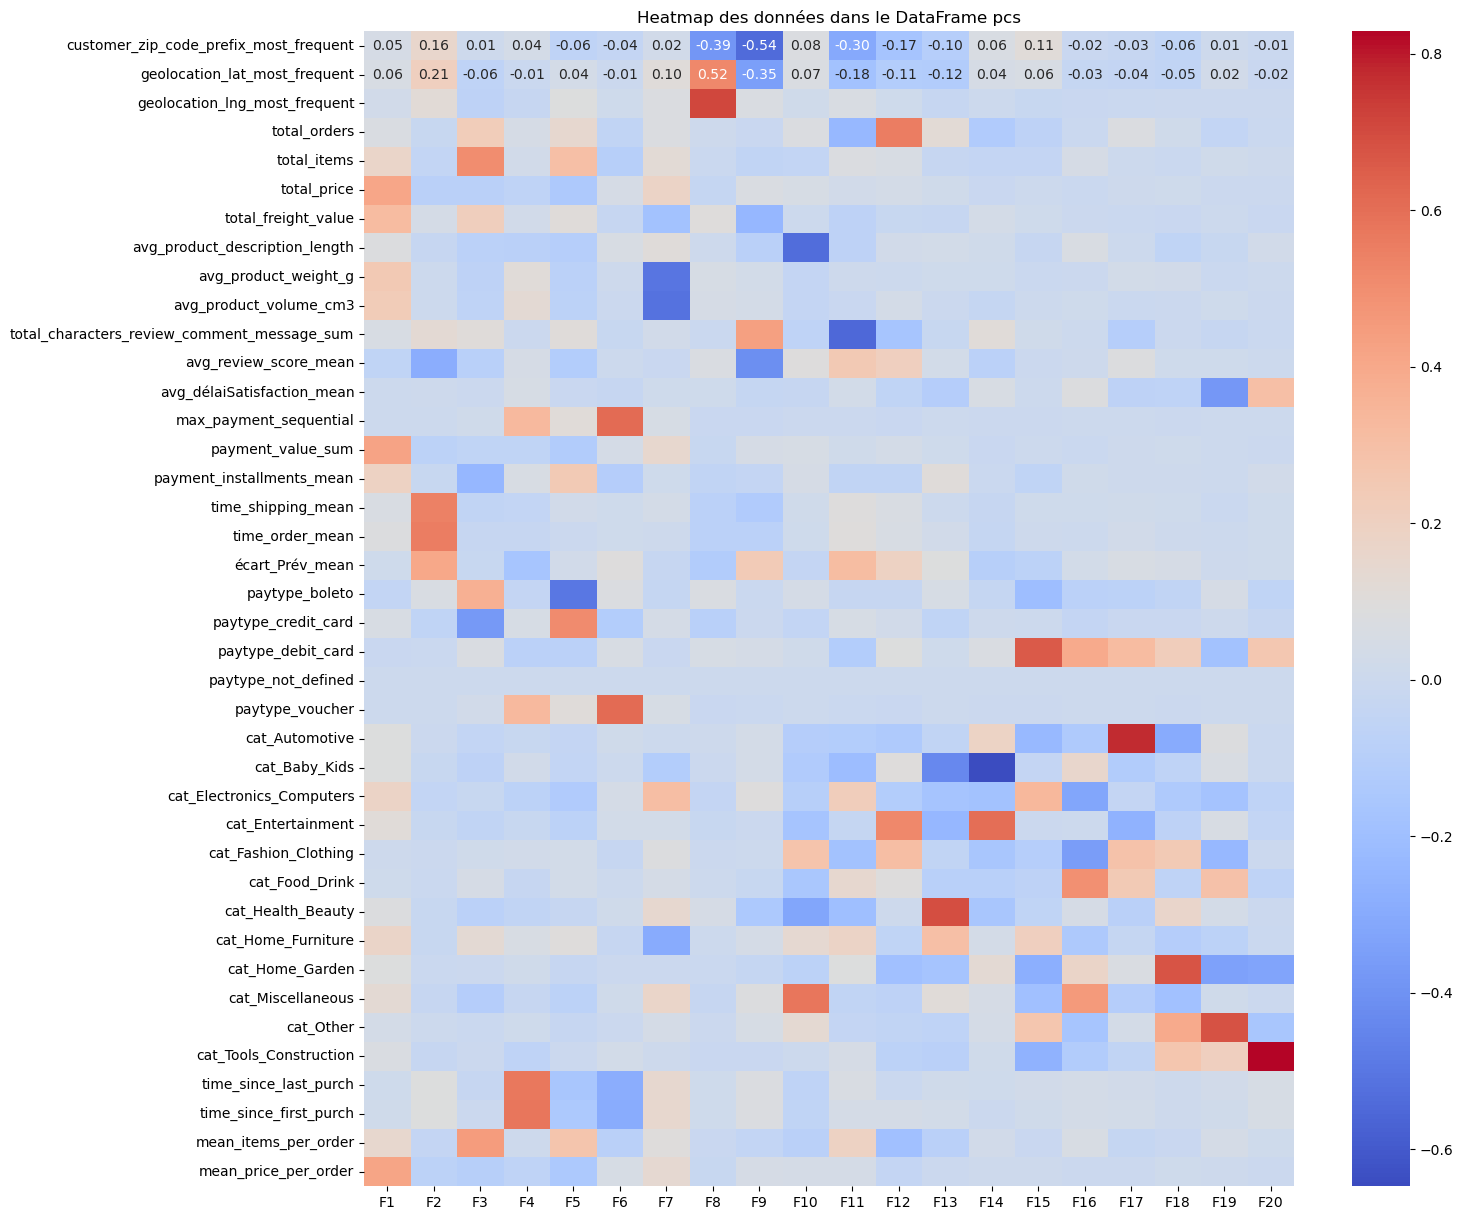

In [32]:
# Si nécessaire, vous pouvez ajuster la taille de la figure
plt.figure(figsize=(15, 15))

# Utilisez la fonction heatmap de seaborn
sns.heatmap(pcs.T, annot=True, cmap='coolwarm', fmt=".2f")

# Ajoutez un titre à votre heatmap
plt.title("Heatmap des données dans le DataFrame pcs")

# Affichez la heatmap
plt.show()


L'ensemble des variables catégorielles pour les produits n'apportent peu d'information dans les premières composantes, leur charge factorielle semblent être plus importantes sur les dernières composantes. Je vais décider de les mettre de côté par la suite lors de la modélisation.

D'autres variables semblent peu informatives également :
- paytype_not_defined & debit_card
- le zipcode customer's
- le nombre de caractères pour la description du produit

Nous ne les conserverons pas non plus, l'objectif est de diminuer le nombre de variables pour facilier la modélisation par la suite.
Je garde l'ensemble de ces variables et je ferai ma sélection de features juste avant d'entrainer les algorithmes.

### e. Cercle des corrélations : F1 & F2

In [33]:
# Définir les axe x,y
x, y = 0,1

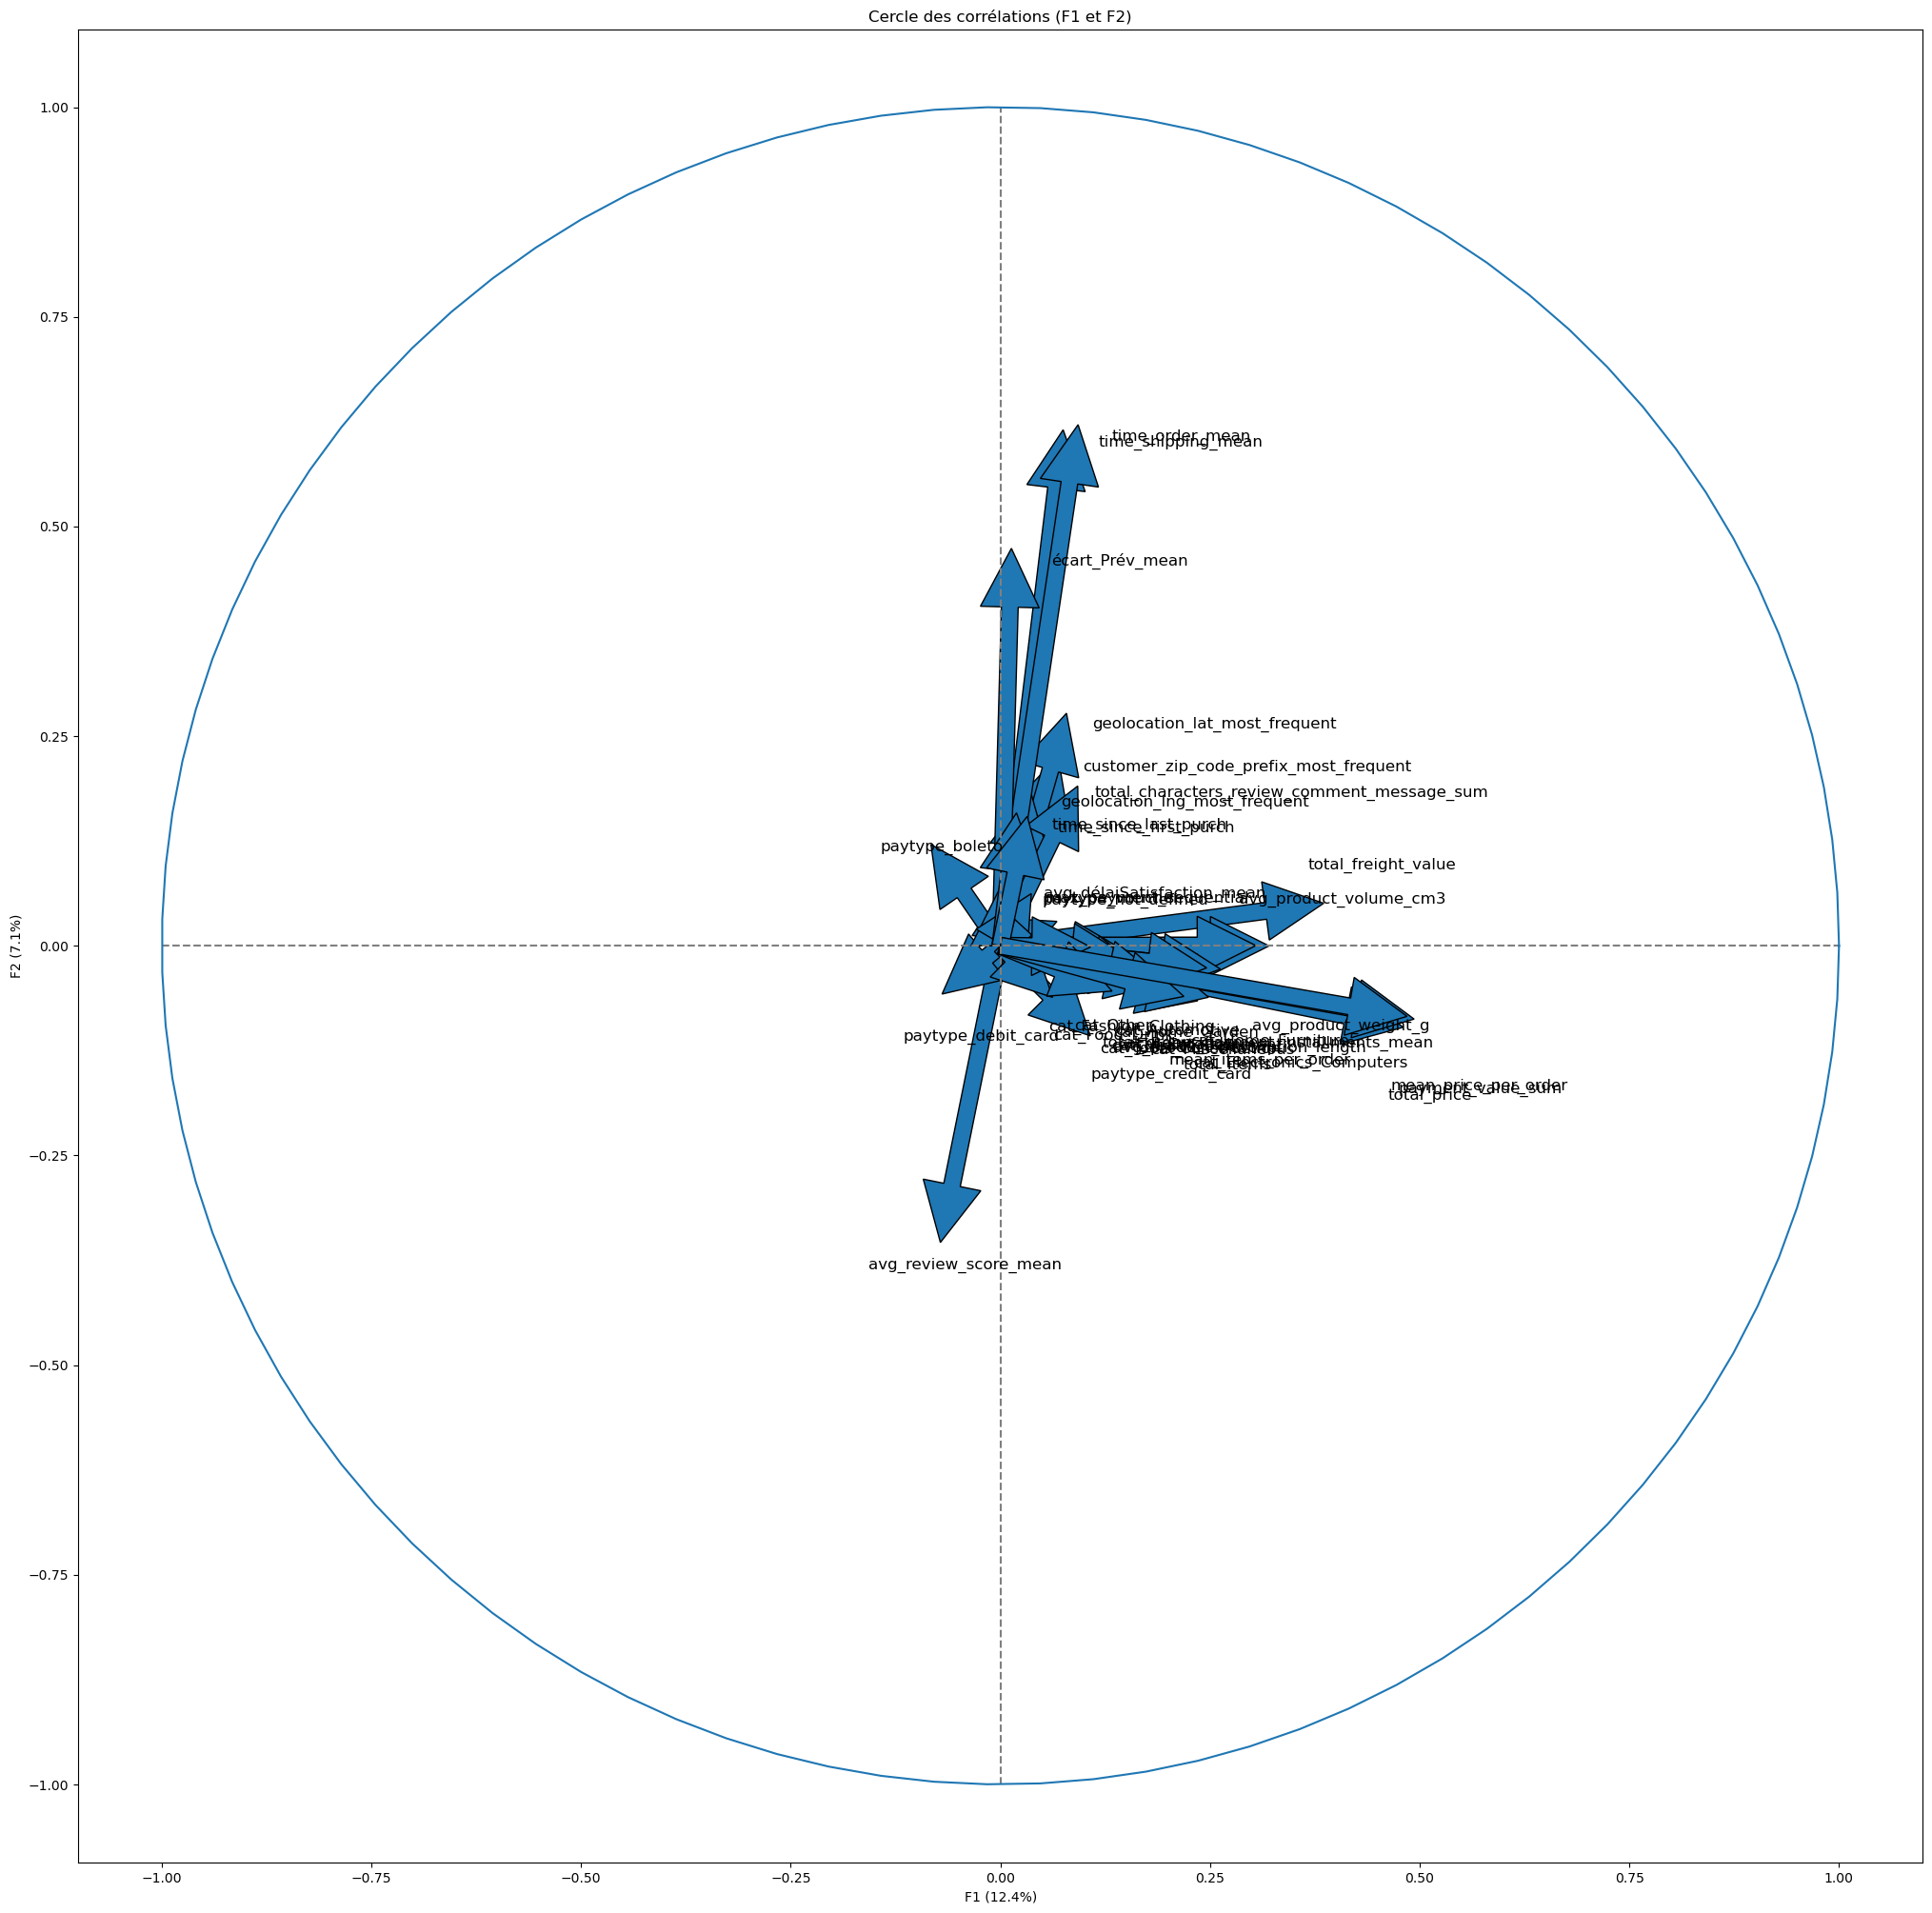

In [34]:
# Création du graphique pour le cercle des corrélations
fig, ax = plt.subplots(figsize=(25, 25))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Commencer la flèche à l'origine
             pca.components_[0, i],
             pca.components_[1, i],  
             head_width=0.07,
             head_length=0.07, 
             width=0.02)
    
    # Ajuster la position des étiquettes 
    if pca.components_[0, i] < 0:
        offset_x = -0.1
    else:
        offset_x = 0.05
    
    if pca.components_[1, i] < 0:
        offset_y = -0.1
    else:
        offset_y = 0.05
    
    plt.text(pca.components_[0, i] + offset_x,
             pca.components_[1, i] + offset_y,
             features[i], fontsize=12)
    
# Affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# Nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

# Dessin du cercle
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)


### f. Cercle des corrélations : F3 & F4

In [35]:
# Définir les axe x,y
x, y = 2,3

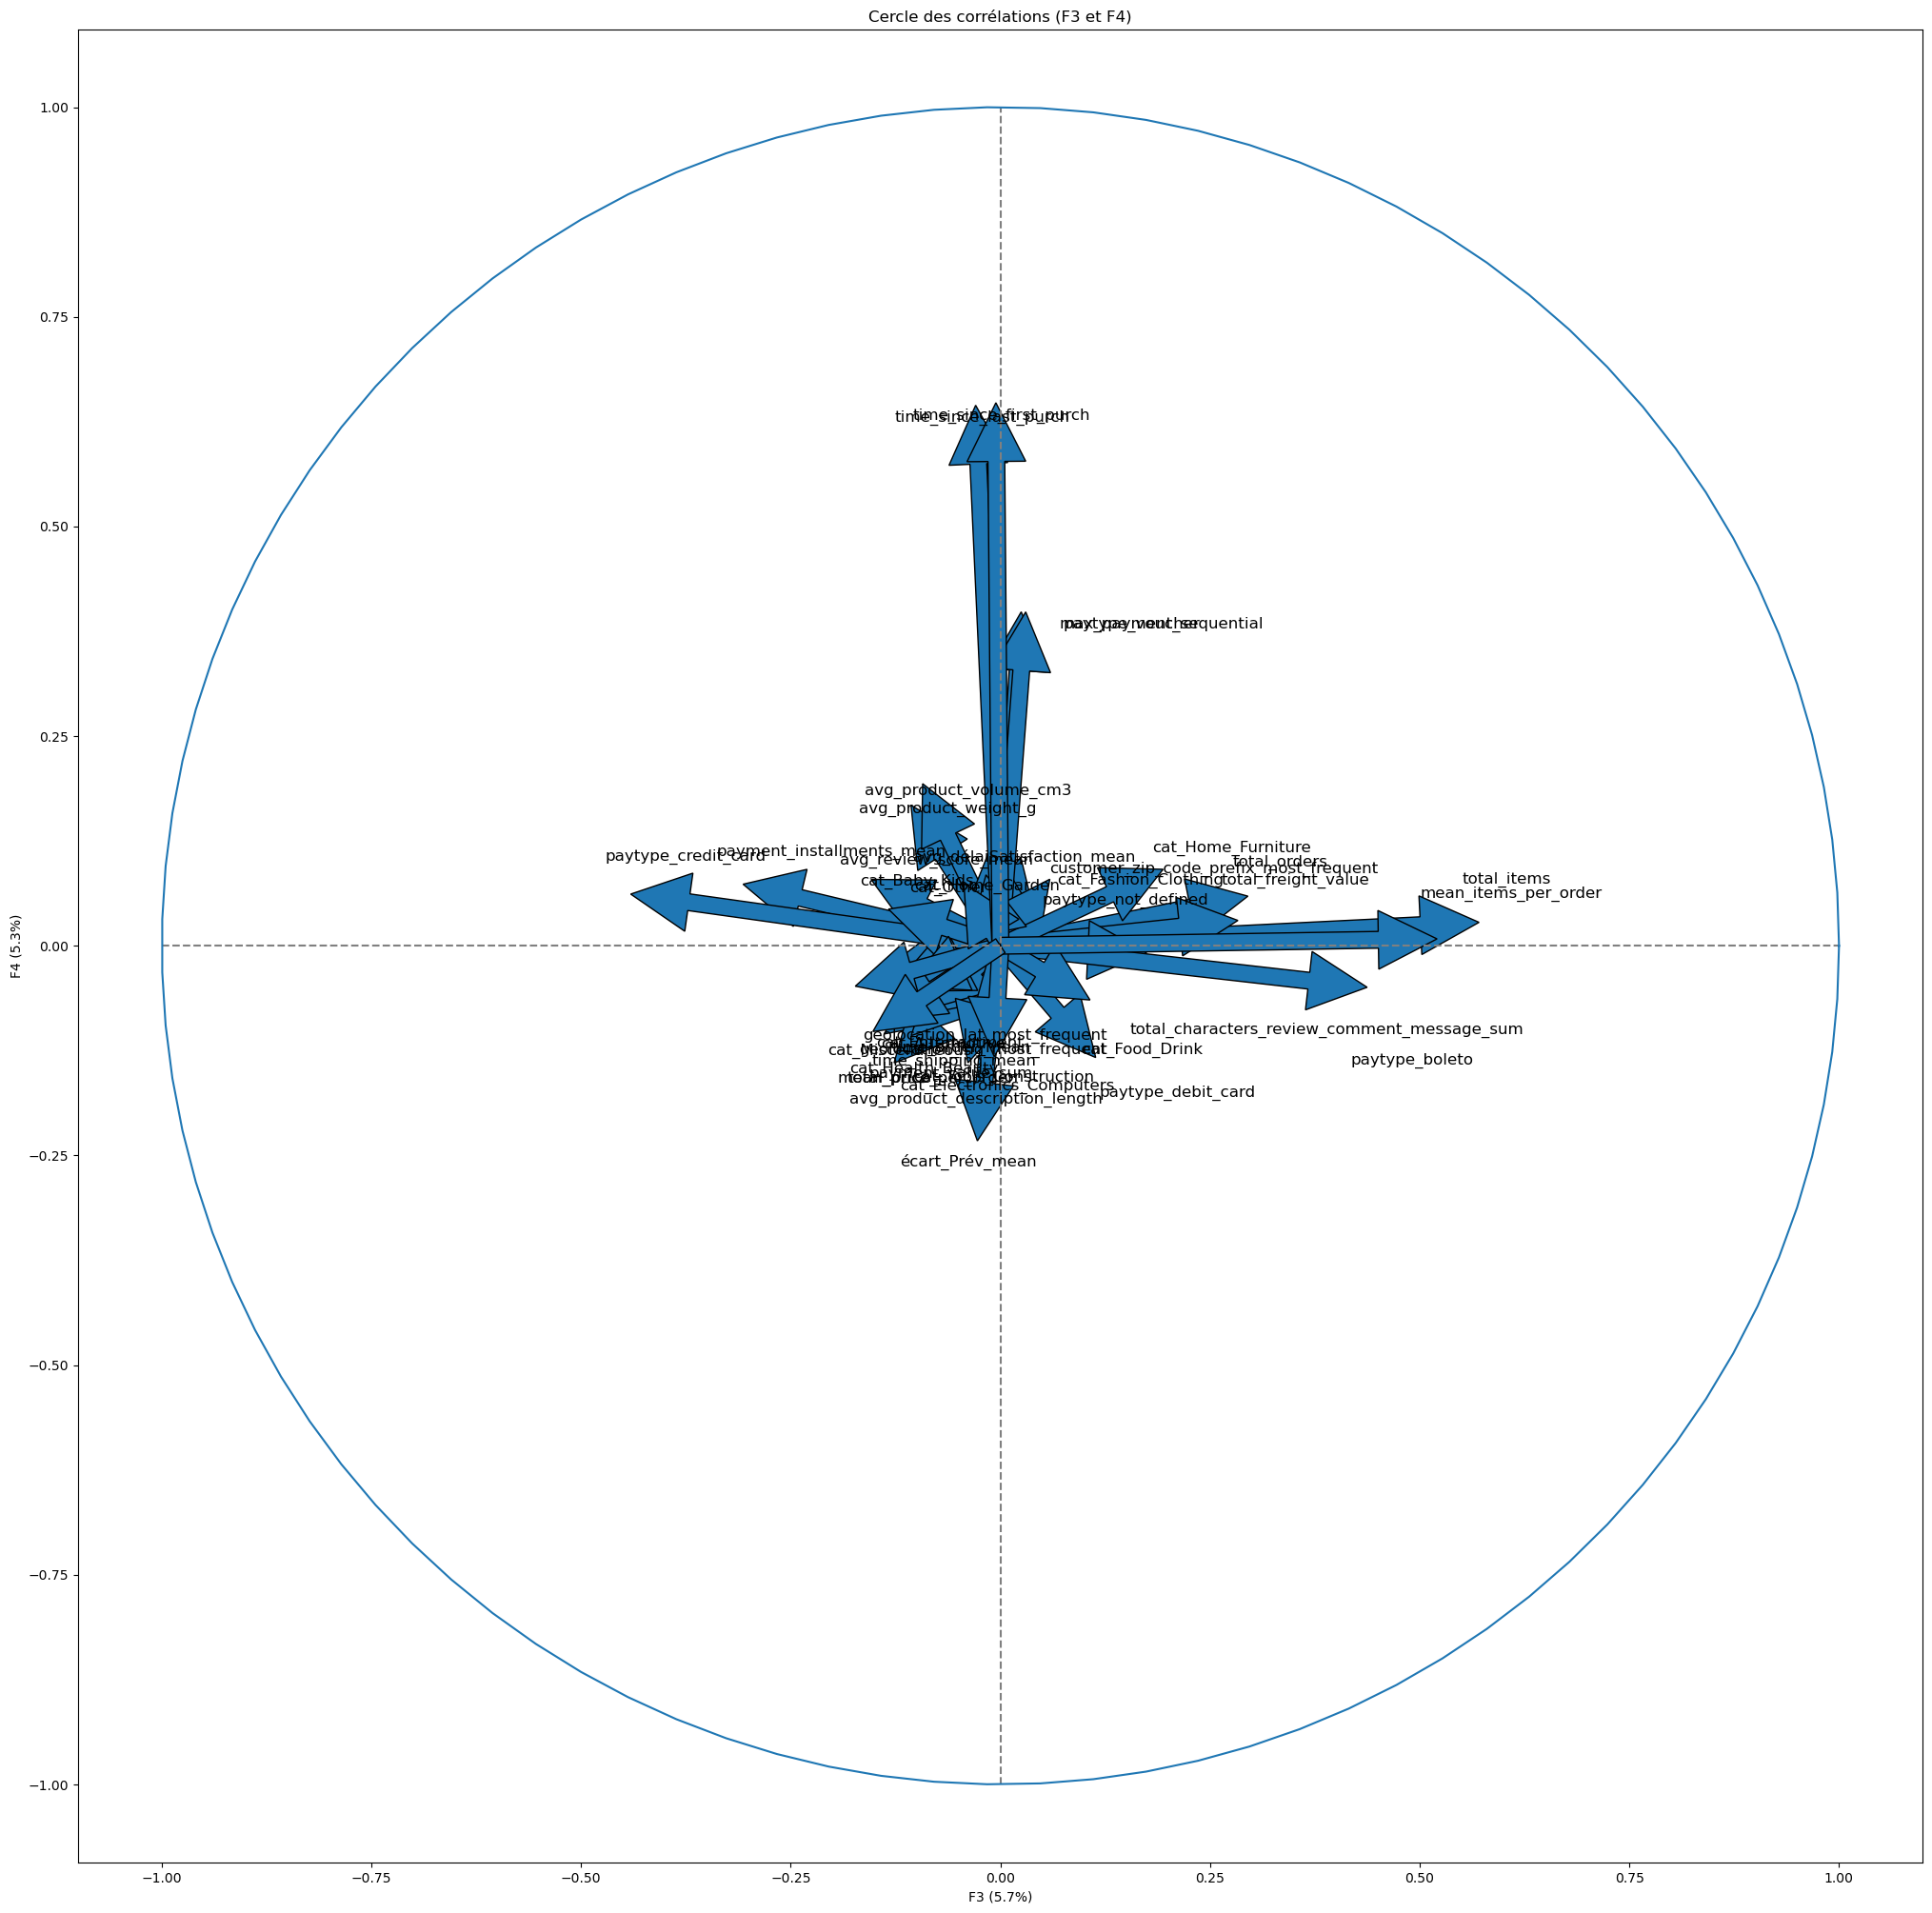

In [36]:
# Création du graphique pour le cercle des corrélations
fig, ax = plt.subplots(figsize=(25, 25))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Commencer la flèche à l'origine
             pca.components_[2, i], 
             pca.components_[3, i],  
             head_width=0.07,
             head_length=0.07, 
             width=0.02)
    
    # Ajuster la position des étiquettes
    if pca.components_[2, i] < 0:
        offset_x = -0.1
    else:
        offset_x = 0.05
    
    if pca.components_[3, i] < 0:
        offset_y = -0.1
    else:
        offset_y = 0.05
    
    plt.text(pca.components_[2, i] + offset_x,
             pca.components_[3, i] + offset_y,
             features[i], fontsize=12)
    
# Affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# Nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

# Dessin du cercle
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)


### g. Cercle des corrélations : F5 & F6

In [37]:
# Définir les axe x,y
x, y = 4,5

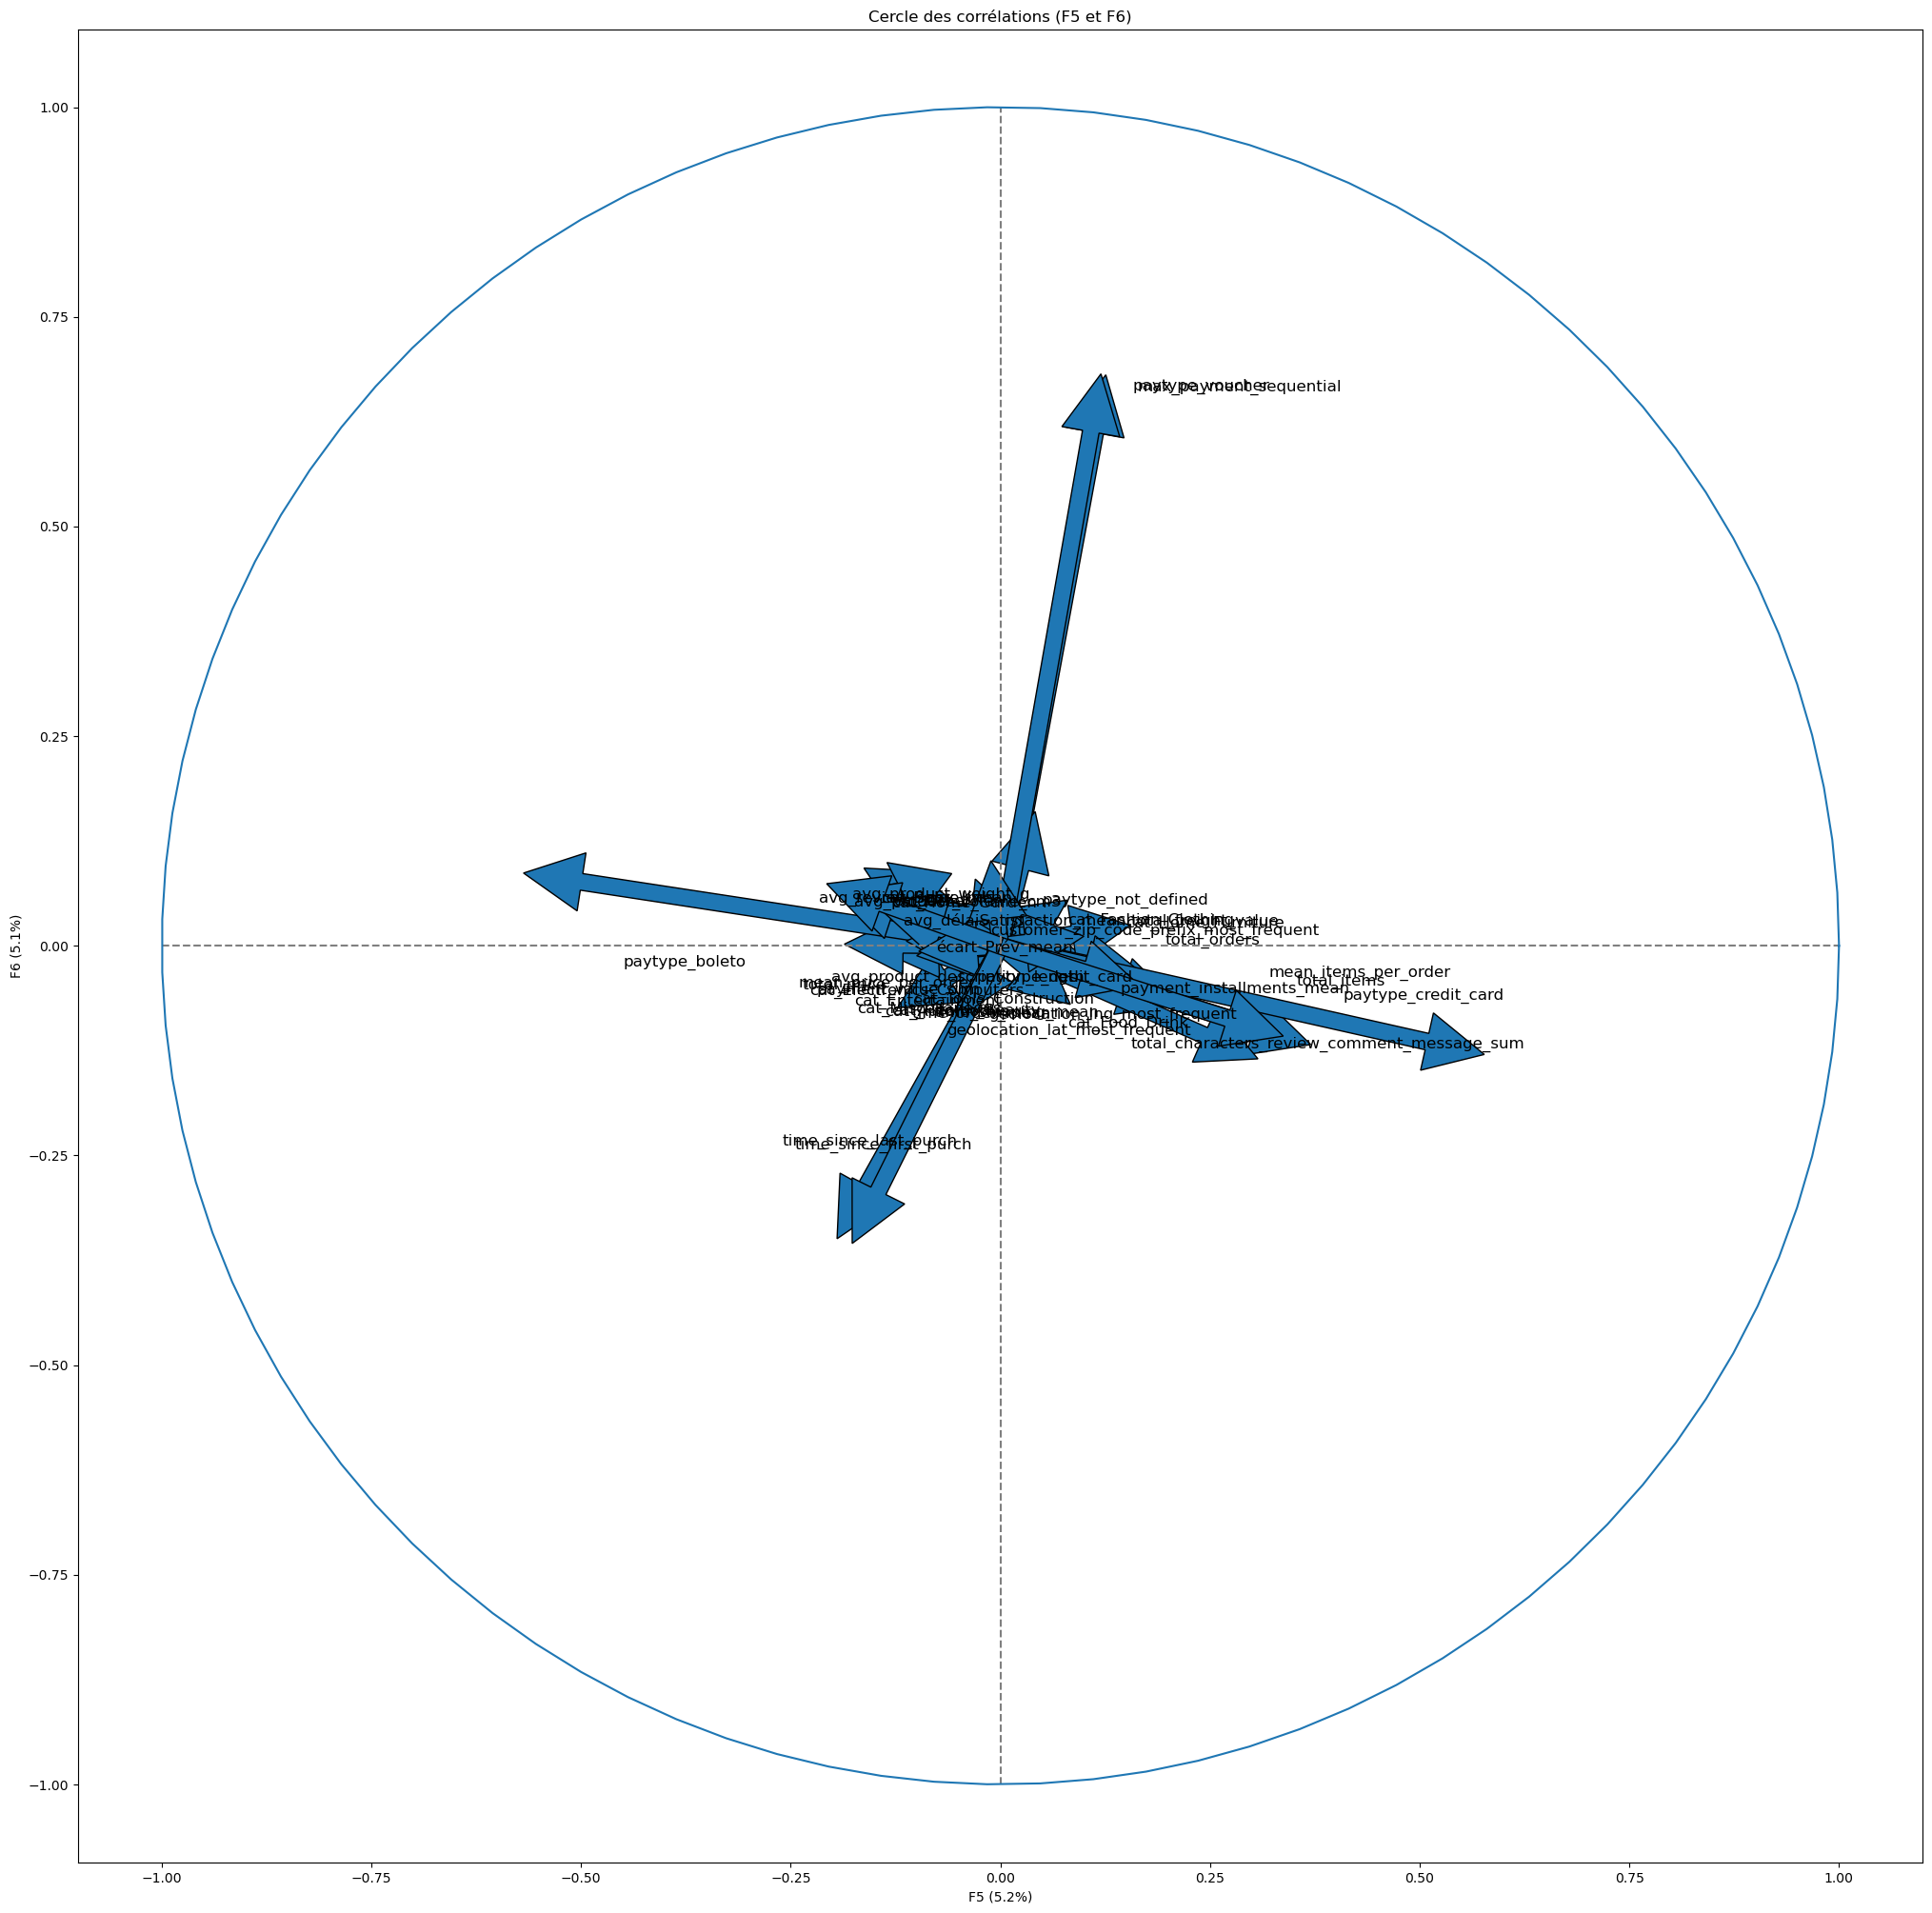

In [38]:
# Création du graphique pour le cercle des corrélations
fig, ax = plt.subplots(figsize=(25, 25))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Commencer la flèche à l'origine
             pca.components_[4, i], 
             pca.components_[5, i],  
             head_width=0.07,
             head_length=0.07, 
             width=0.02)
    
    # Ajuster la position des étiquettes 
    if pca.components_[2, i] < 0:
        offset_x = -0.1
    else:
        offset_x = 0.05
    
    if pca.components_[3, i] < 0:
        offset_y = -0.1
    else:
        offset_y = 0.05
    
    plt.text(pca.components_[4, i] + offset_x,
             pca.components_[5, i] + offset_y,
             features[i], fontsize=12)
    
# Affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# Nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

# Dessin du cercle
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)


## 8. Analyse en composantes principales (sans les variables catégorielles encodées)

Dans cette ACP, nous allons enlever les variables catégorielles qui ont été encodées ainsi que les variables fortement corrélées, qui sont le prix moyen et le nombre moyen d'article par commande. Etant donné que la majorité des commandes sont unitaires (96% du total des commandes), peu de différence entre les variables moyennées et les variables d'origine.

### a. ACP

In [42]:
# Filtrer les colonnes en excluant celles avec les préfixes "cat" et "paytype"
filtered_cols = [col for col in df_cust.columns if not col.startswith(('cat', 'paytype'))]

# Sélectionner les colonnes de type int et float parmi celles filtrées, en excluant deux colonnes spécifiques
cols_int_float = df_cust[filtered_cols].select_dtypes(include=['int', 'float']).columns

# Exclure les colonnes spécifiques
cols_int_float = cols_int_float[~cols_int_float.isin(['mean_items_per_order', 'mean_price_per_order'])]

# Sélectionner les données correspondantes à ces colonnes
X = df_cust[cols_int_float]

# Stocker les colonnes dans un objet 'features"
features = cols_int_float

# Scaler les données en utilisation la fonction de sklearn 'StandardScaler'
scaler = StandardScaler()

# Adapter le scaler aux données pour calculer la moyenne et l'écart-type
scaler.fit(X)

# Transformer les données originales en utilisant la moyenne et l'écart-type calculés
X_scaled = scaler.transform(X)

# Vérification que nos moyennes sont égales à 0 et nos écart-type à 1
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

# Sélection du nombre de composantes
n_components = 10

# Instanciation de l'ACP
pca = PCA(n_components=n_components)

# Entrainement sur les données "X"
pca.fit(X_scaled)

# Création d'une variable pour visualiser la valeur de la variance stockée par chacune des composantes
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round(2)

# Afficher les valeurs correspondantes
print(scree)
print(scree.cumsum().round(2))
print('Cumul:',sum(scree))


[16.36 12.76  9.66  7.67  7.    6.35  5.81  5.09  4.77  4.74]
[16.36 29.12 38.78 46.45 53.45 59.8  65.61 70.7  75.47 80.21]
Cumul: 80.21


Avec 10 composantes, nous atteingons les 80% de variables cumulées, contre 20 composantes sur l'analyse précédentes.

### b. Graphique des éboulis des valeurs propres

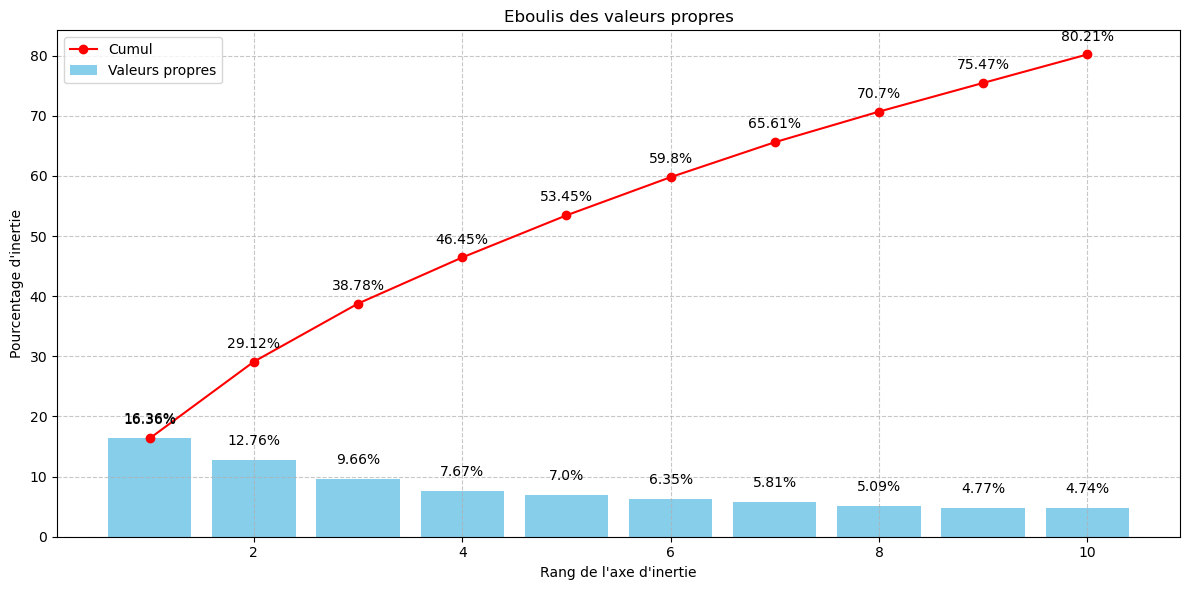

In [43]:
# Définir une variable pour stocker nos composantes
x_list = range(1, n_components+1)

# Création d'un graphique pour afficher et illustrer ces résultats
plt.figure(figsize=(12, 6))

plt.bar(x_list, scree, color='skyblue', label='Valeurs propres')
plt.plot(x_list, scree_cum, c="red", marker='o', label='Cumul')

plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)

# Ajout des étiquettes de données
for i, value in enumerate(scree):
    plt.text(x_list[i], value + 2, f'{value}%', ha='center', va='bottom')

# Ajout d'annotations pour le cumul
for i, value in enumerate(scree_cum):
    plt.annotate(f'{value}%', (x_list[i], value), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

### c. Visualisation des charges factorielles par composante

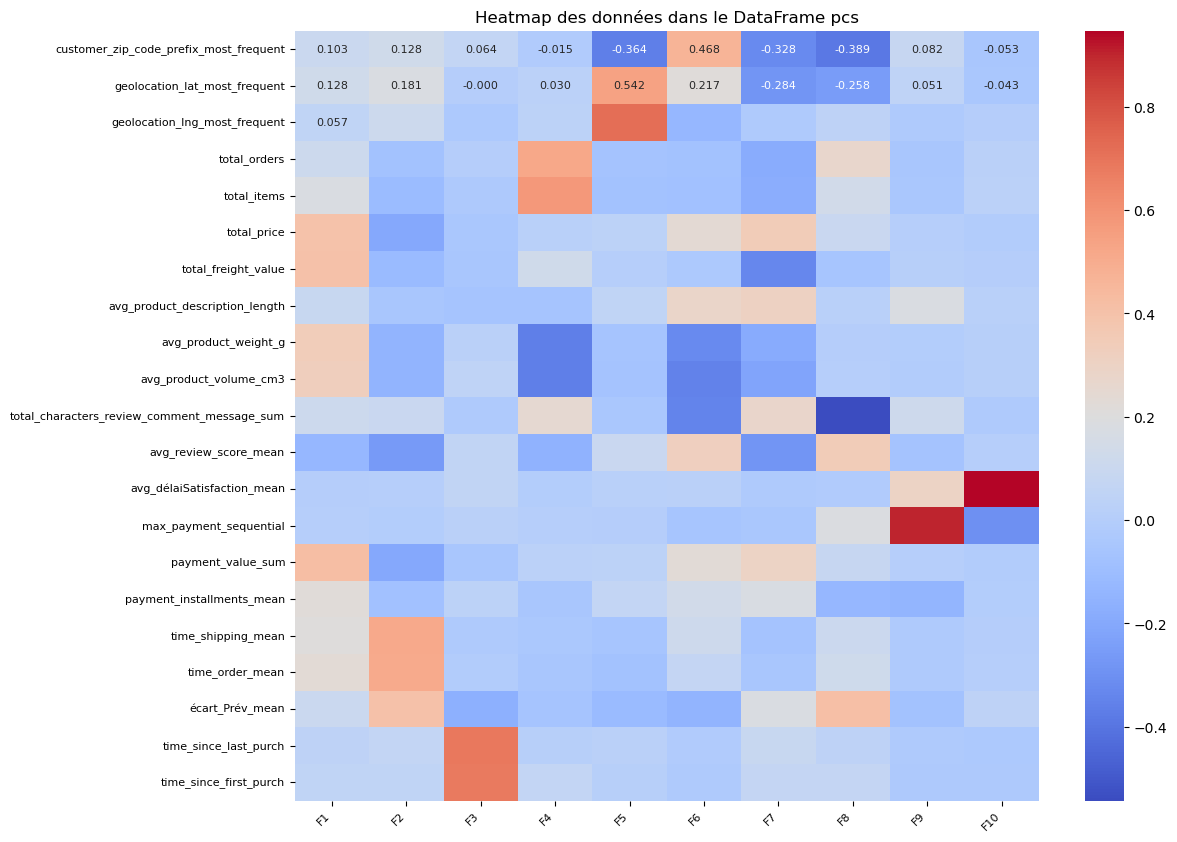

In [44]:
# Stockage des données de nos composantes dans un dataframe
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]

# Ajuster la taille de la figure
plt.figure(figsize=(12, 10))

# Utiliser la fonction heatmap de seaborn
heatmap = sns.heatmap(pcs.T, annot=True, cmap='coolwarm', fmt=".3f", annot_kws={"size": 8})

# Ajuster les étiquettes des axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right', fontsize=8)

# Ajouter un titre à votre heatmap
plt.title("Heatmap des données dans le DataFrame pcs")

# Afficher la heatmap
plt.show()


**La lecture des composantes :**
- 1iere composante : prix et produits
- 2ième composante : transport & délais 
- 3ième composante : récence
- 4ième composante : volume commandes & articles
- 5ième composante : localisation
- 6ième composante : localisation & satifaction client
- 7ième composante : prix & description produits & longueur du message retour client & la valeur du paiement 
- 8ième composante : le review_score & l'écart entre le réel et le prévu et on exclut le nombre de caractères dans le message de retour client
- 9ième composante : le nombre de séquence pour les paiements
- 10ième composante : le délais pour la réponse à l'enquête de satisfaction

### d. Cercle des corrélations : F1 & F2

In [45]:
# Définir les axe x,y
x, y = 0,1

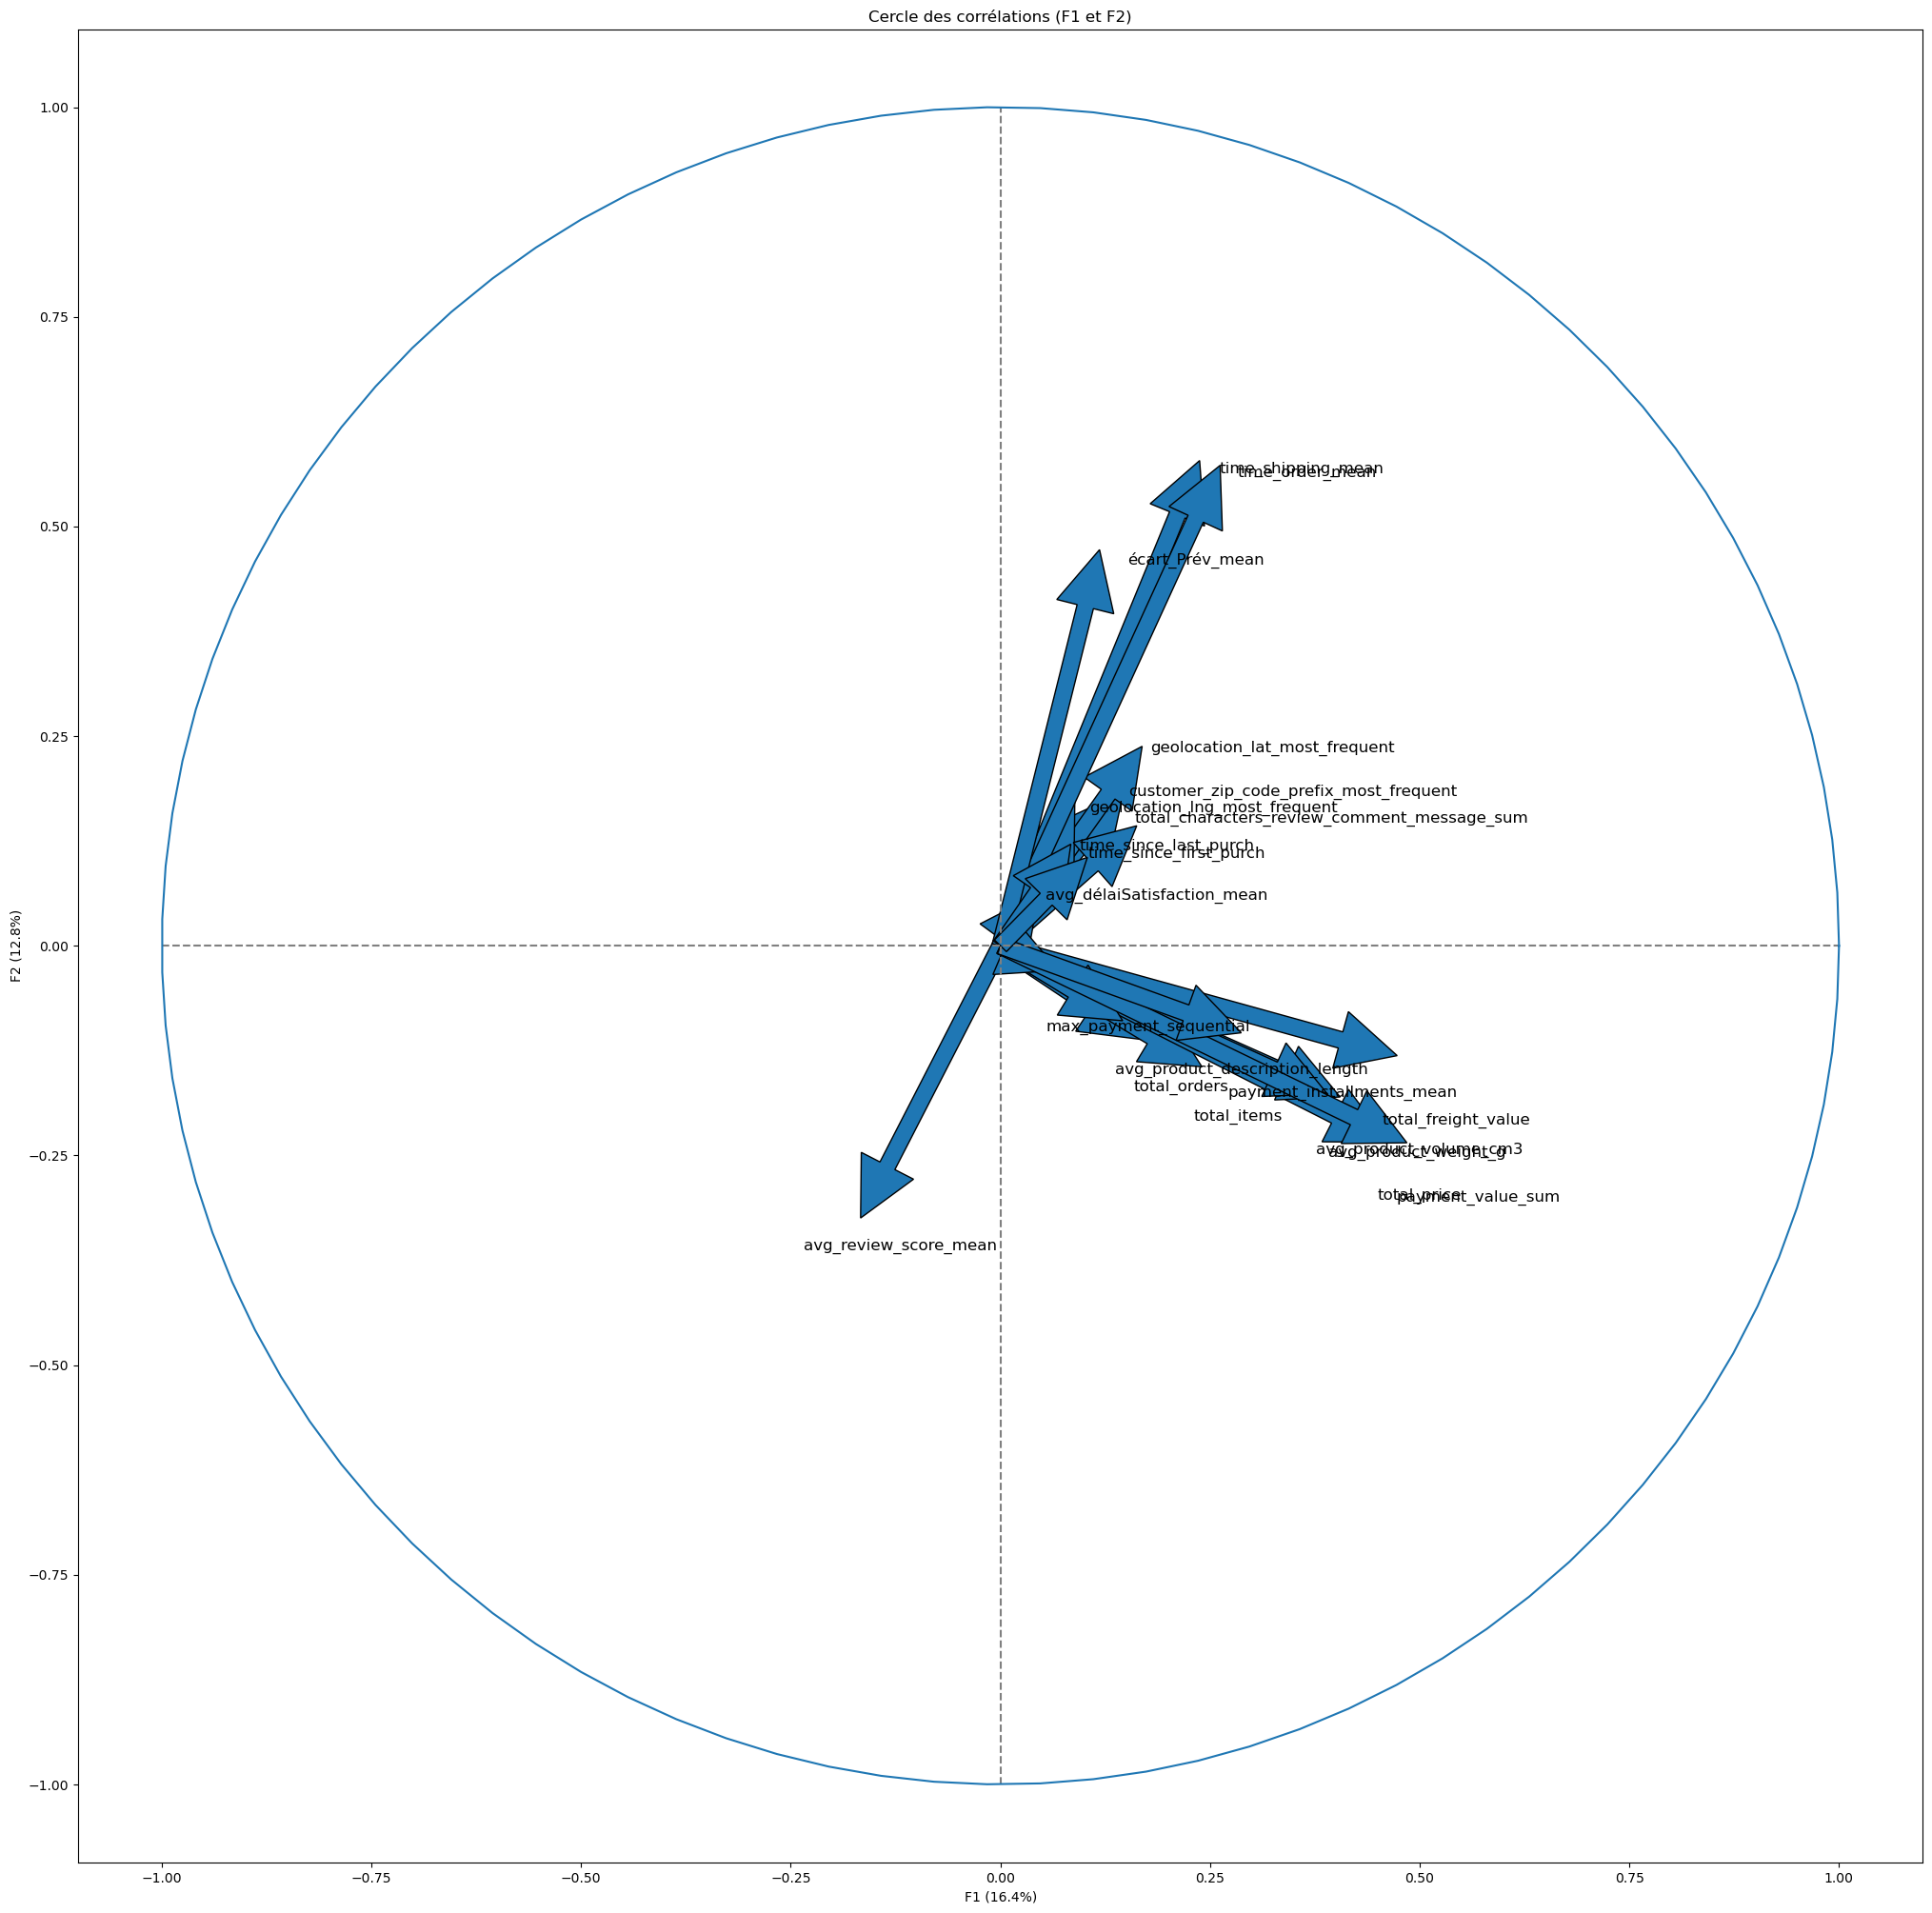

In [46]:
# Création du graphique pour le cercle des corrélations
fig, ax = plt.subplots(figsize=(25, 25))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Commencer la flèche à l'origine
             pca.components_[0, i],  # 0 pour CP1
             pca.components_[1, i],  # 1 pour CP2
             head_width=0.07,
             head_length=0.07, 
             width=0.02)
    
    # Ajuster la position des étiquettes 
    if pca.components_[0, i] < 0:
        offset_x = -0.1
    else:
        offset_x = 0.05
    
    if pca.components_[1, i] < 0:
        offset_y = -0.1
    else:
        offset_y = 0.05
    
    plt.text(pca.components_[0, i] + offset_x,
             pca.components_[1, i] + offset_y,
             features[i], fontsize=12)
    
# Affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# Nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

# Dessin du cercle
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)


### e. Cercle des corrélations : F3 & F4

In [47]:
# Définir les axe x,y
x, y = 2,3

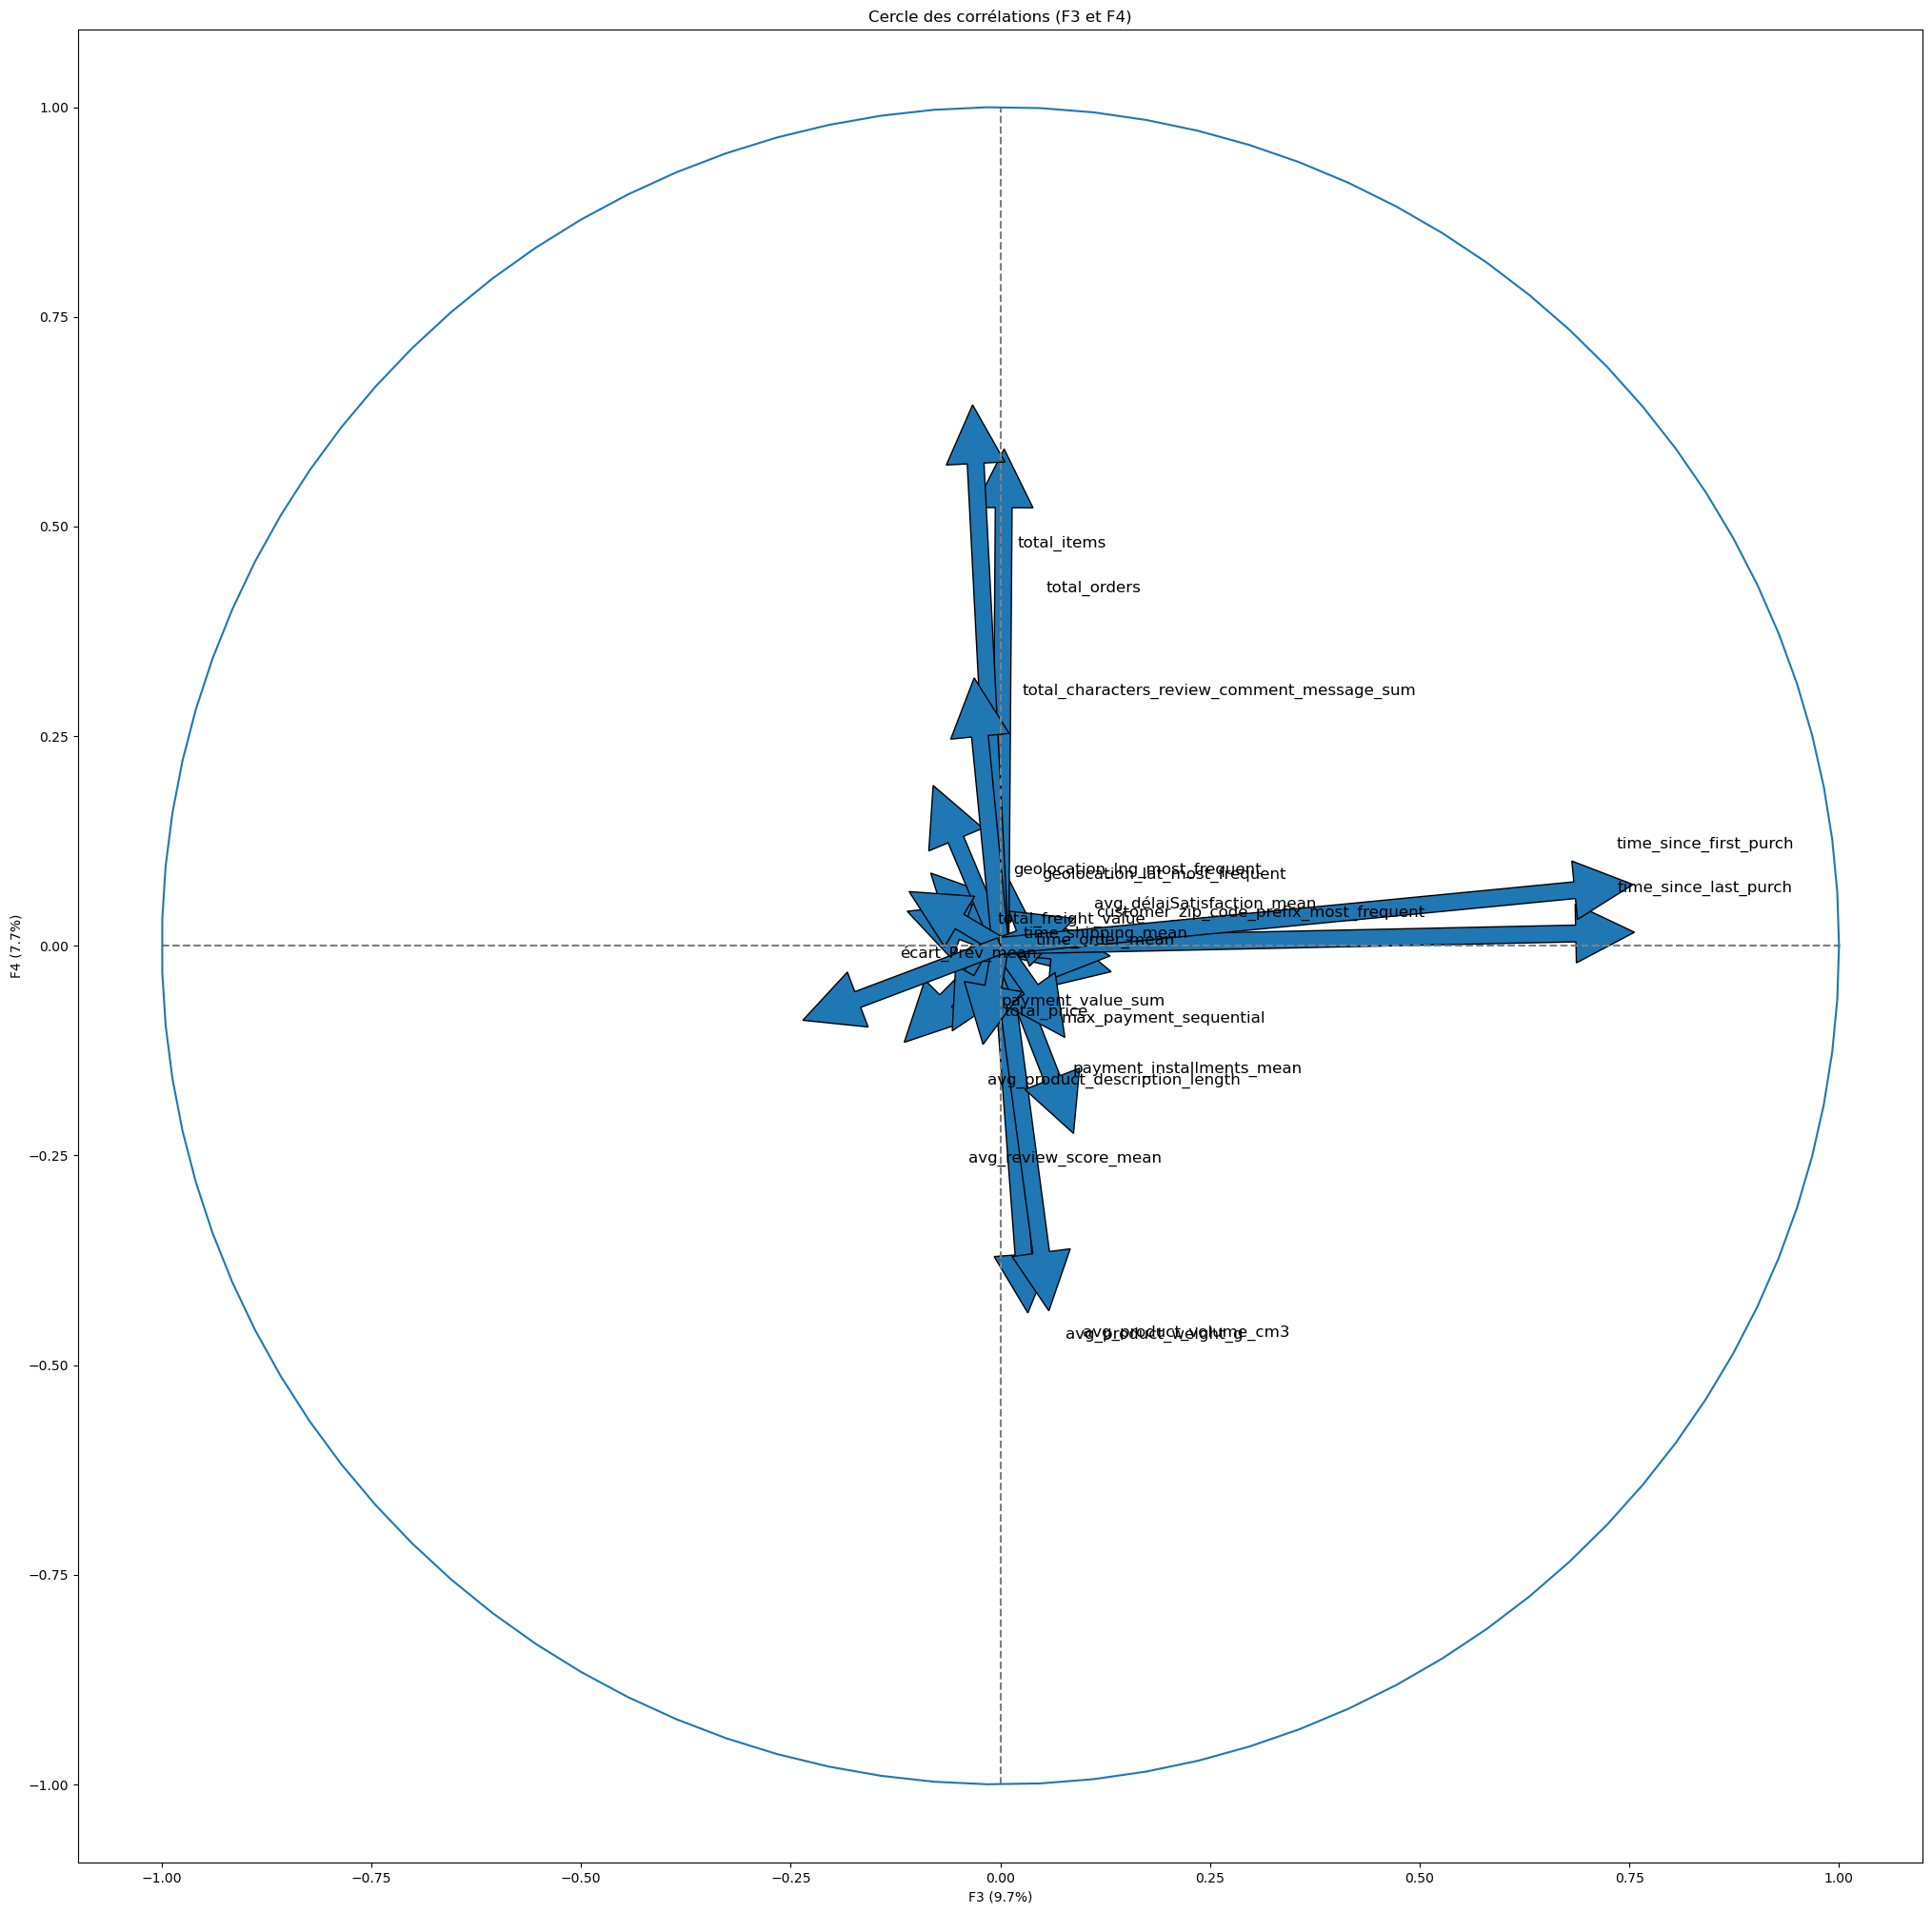

In [49]:
# Création du graphique pour le cercle des corrélations
fig, ax = plt.subplots(figsize=(25, 25))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  
             pca.components_[2, i],
             pca.components_[3, i], 
             head_width=0.07,
             head_length=0.07, 
             width=0.02)
    
    # Ajuster la position des étiquettes 
    if pca.components_[0, i] < 0:
        offset_x = -0.1
    else:
        offset_x = 0.05
    
    if pca.components_[1, i] < 0:
        offset_y = -0.1
    else:
        offset_y = 0.05
    
    plt.text(pca.components_[2, i] + offset_x,
             pca.components_[3, i] + offset_y,
             features[i], fontsize=12)
    
# Affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# Nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

# Dessin du cercle
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)


### f. Cercle des corrélations : F5 & F6

In [50]:
# Définir les axe x,y
x, y = 4,5

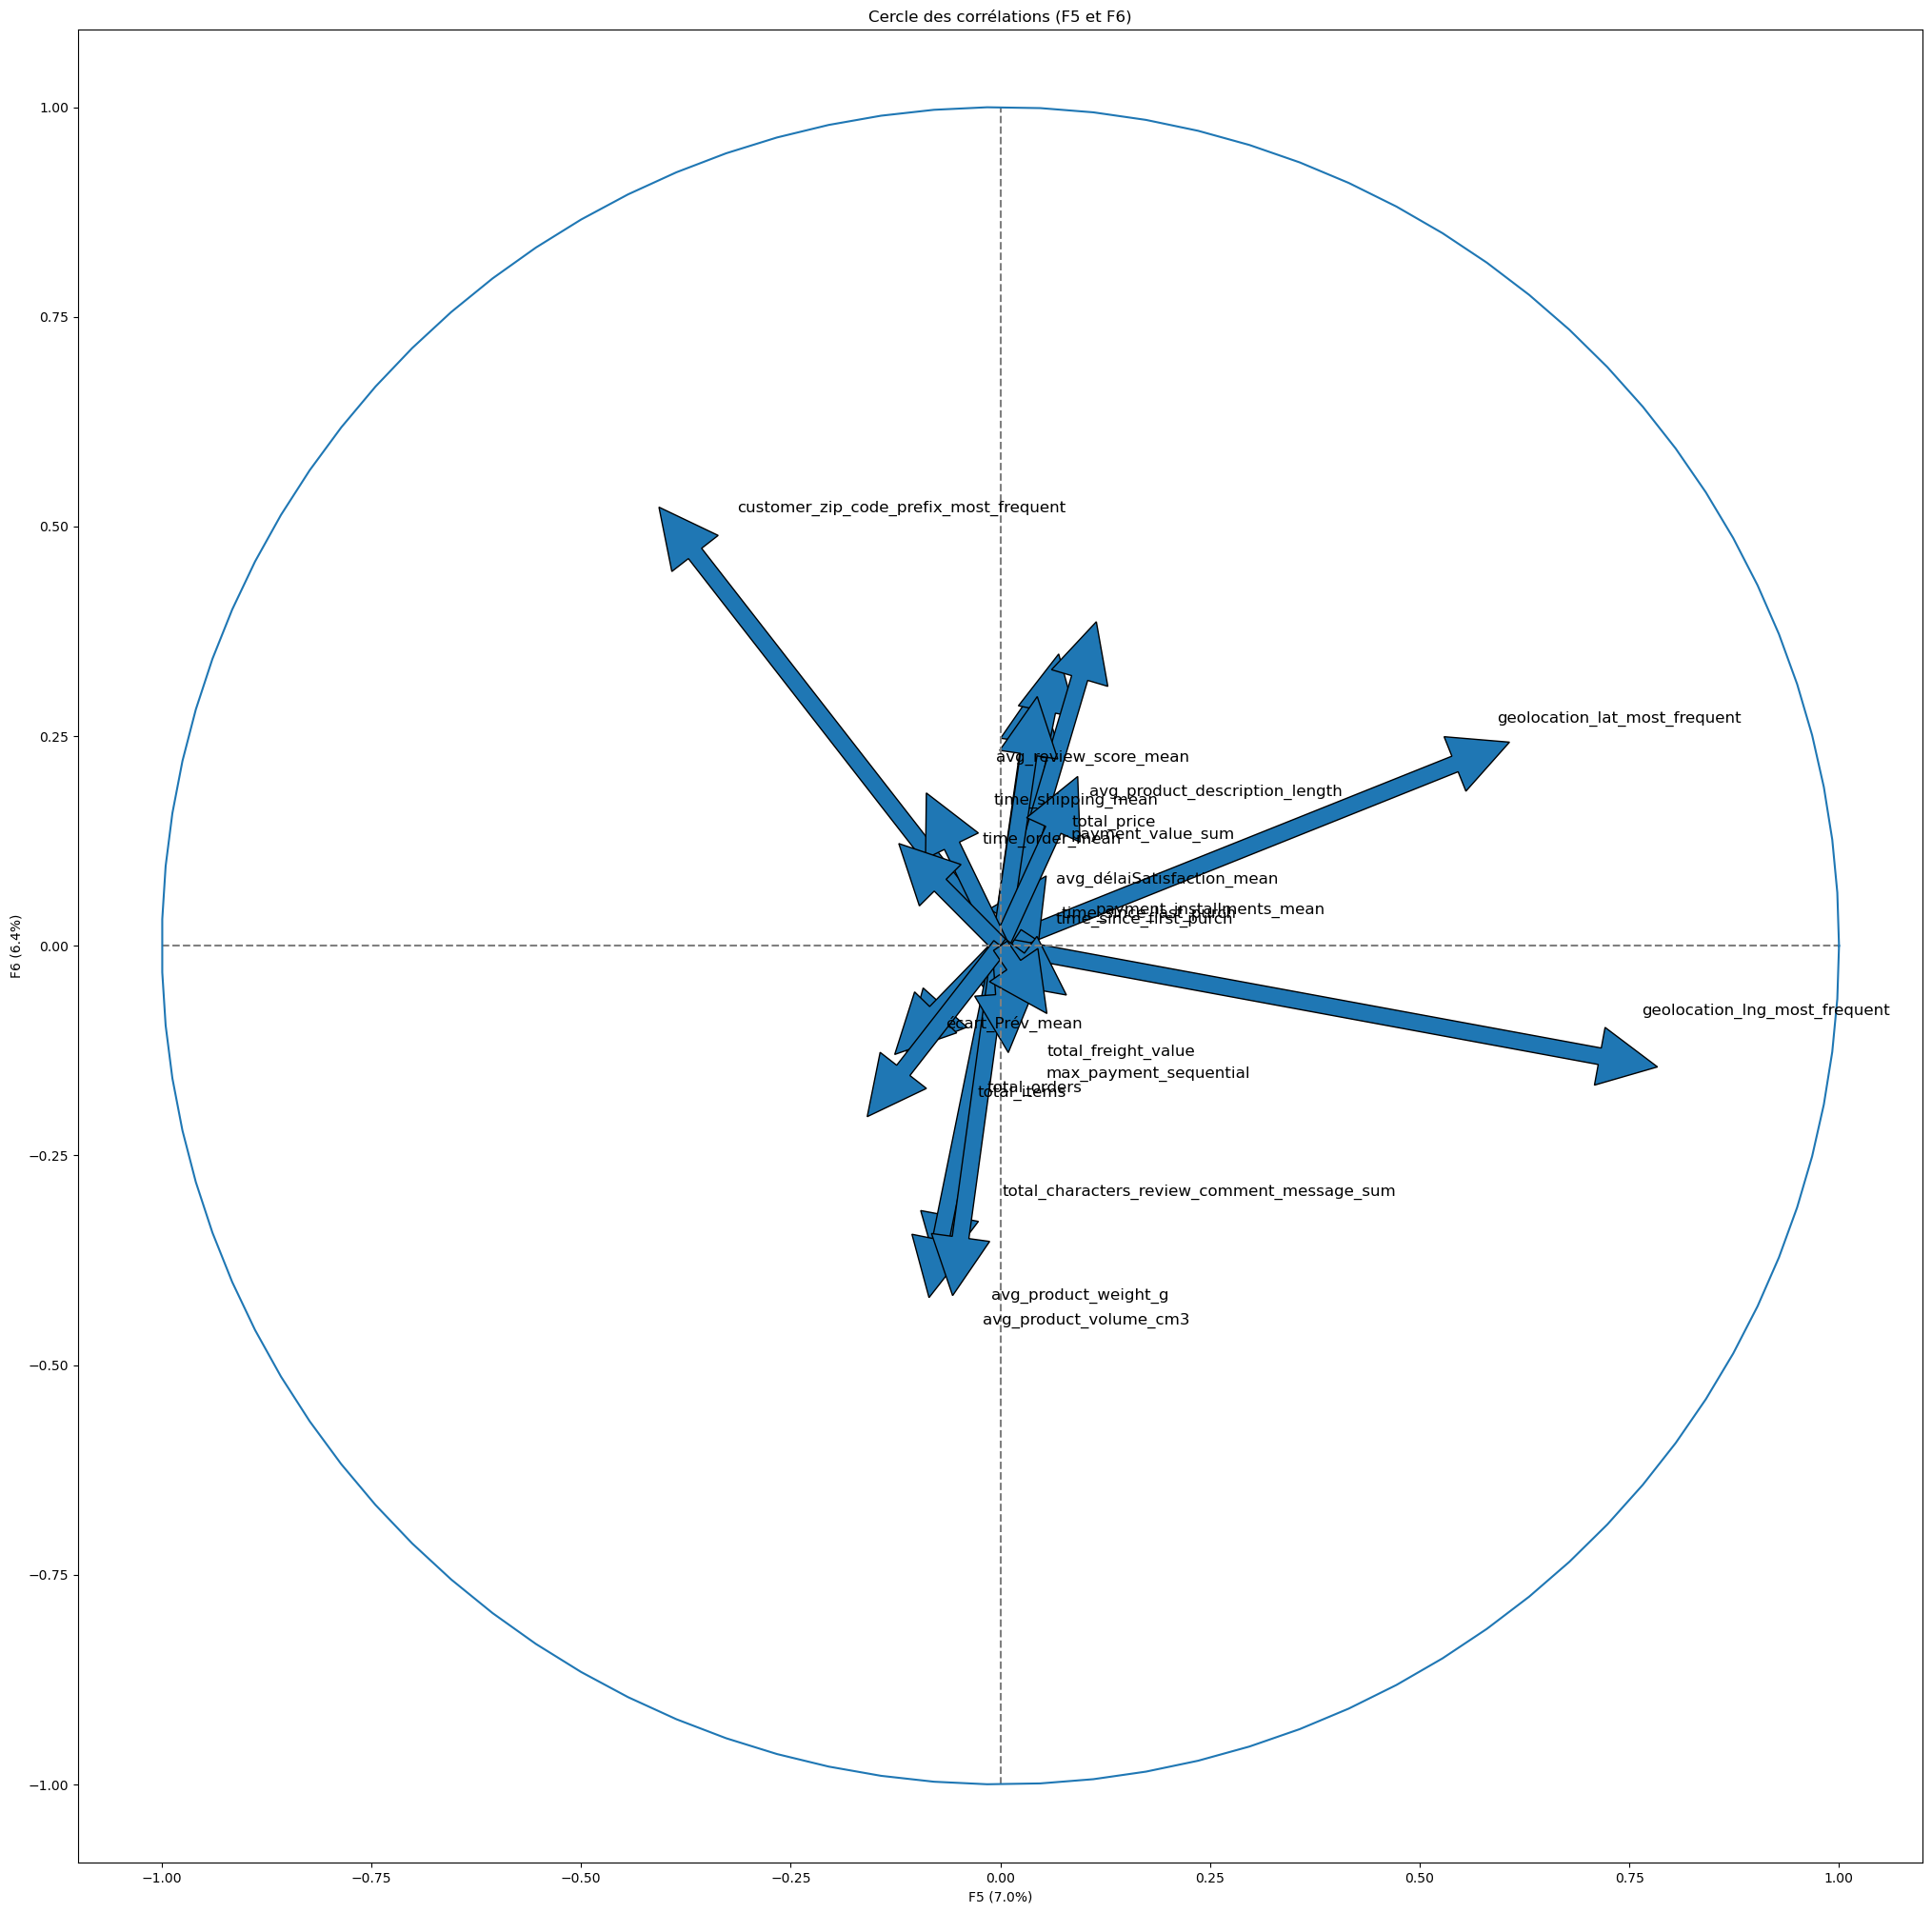

In [51]:
# Création du graphique pour le cercle des corrélations
fig, ax = plt.subplots(figsize=(25, 25))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  
             pca.components_[4, i],
             pca.components_[5, i], 
             head_width=0.07,
             head_length=0.07, 
             width=0.02)
    
    # Ajuster la position des étiquettes 
    if pca.components_[0, i] < 0:
        offset_x = -0.1
    else:
        offset_x = 0.05
    
    if pca.components_[1, i] < 0:
        offset_y = -0.1
    else:
        offset_y = 0.05
    
    plt.text(pca.components_[4, i] + offset_x,
             pca.components_[5, i] + offset_y,
             features[i], fontsize=12)
    
# Affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# Nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

# Dessin du cercle
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an)) 
plt.axis('equal')
plt.show(block=False)


# VI. Transformation suite à l'analyse exploratoire

Voici les transformations que nous allons opérer :
- Suppression des variables fortement corrélées, prix moyen et nombre d'articles moyens par commmande.
- Création d'une varaible binaire pour paiement avec la carte de crédit ou non.
- Regroupement de certaines catégories pour diminuer le nombre de cat pour les produits
- Avoir le ratio du prix total et non la valeur absolue pour les variables catégorielles
- Création d'une colonne fréquence d'achat
- Pour les données géographique, prendre le transformers harversine pour les lattitudes et longitudes

## 1. Variable binaire pour le type de paiement

In [92]:
# Utiliser get_dummies pour créer des variables binaires
df_dummies = pd.get_dummies(df_cust['payment_type_most_frequent'])

# Sélection de la colonne correspondante à 'credit_card' 
df_cust['payment_is_credit_card'] = df_dummies['credit_card']

# Convertir les colonnes en 0/1
df_cust['payment_is_credit_card'] = df_cust['payment_is_credit_card'].astype(int)

# Supprimer la colonne
df_cust.drop('payment_type_most_frequent', axis=1, inplace=True)

# Supprimer les colonnes avec le préfixe 'paytype'
columns_to_drop = [col for col in df_cust.columns if col.startswith('paytype')]
df_cust.drop(columns_to_drop, axis=1, inplace=True)


## 2. Regroupement des catégories produits

Nous allons réunir les colonnes suivantes :
- cat_Fashion_Clothing & cat_Health_Beauty = cat_Health_Beauty_clothing
- cat_Home_Garden & cat_Home_Furniture & cat_Tools_Construction = cat_Home_Tools
- cat_Miscellaneous	& cat_Other & cat_Automotive & cat_Food_Drink = cat_Miscellaneous

Ces variables sont pondérées par le poids de la valeur marchande 'price'.

In [93]:
# Créer une nouvelle colonne cat_Health_Beauty_clothing qui est la somme de cat_Fashion_Clothing et cat_Health_Beauty
df_cust['cat_Health_Beauty_clothing'] = df_cust[['cat_Fashion_Clothing', 'cat_Health_Beauty']].sum(axis=1)

# Créer une nouvelle colonne cat_Home_Tools qui est la somme de cat_Home_Garden, cat_Home_Furniture et cat_Tools_Construction
df_cust['cat_Home_Tools'] = df_cust[['cat_Home_Garden', 'cat_Home_Furniture', 'cat_Tools_Construction']].sum(axis=1)

# Créer une nouvelle colonne cat_Miscellaneous qui est la somme de cat_Miscellaneous, cat_Other et cat_Automotive
df_cust['cat_Miscellaneous'] = df_cust[['cat_Miscellaneous', 'cat_Other', 'cat_Automotive','cat_Food_Drink']].sum(axis=1)

# Supprimer les colonnes d'origine qui ne sont plus nécessaires
df_cust.drop(['cat_Fashion_Clothing', 'cat_Health_Beauty', 'cat_Home_Garden', 'cat_Home_Furniture', 'cat_Tools_Construction', 'cat_Other', 'cat_Automotive', 'cat_Food_Drink'], axis=1, inplace=True)


Nous allons maintenant faire le ratio des valeurs par catégories sur la valeur totale.

In [97]:
# Identifier les colonnes qui commencent par 'cat_'
cat_columns = [col for col in df_cust.columns if col.startswith('cat_')]

# Diviser les colonnes cat_ par la colonne total_price pour obtenir les pourcentages
df_cust[cat_columns] = df_cust[cat_columns].div(df_cust['total_price'], axis=0)

## 3. Création de deux nouvelles variables

### a. 'Single or multiple purchases' : Variable booléenne

In [101]:
# Création de colonne pour le dataframe df1
df_cust['single/mult_orders'] = df_cust['total_orders'].apply(lambda x: 1 if x > 1 else 0)

### b. Calculer le ratio des frais de transport sur le paiement total

In [102]:
# Faire un ratio pour la colonne des frais de transport
df_cust['ratio_freight'] = df_cust['total_freight_value'] / df_cust['payment_value_sum']

# VII. Consolidation & exportation des dataframes

In [104]:
# Afficher le dataset df_cust
pd.set_option('display.max_columns', None)
df_cust

customer_unique_id  \
0      0000366f3b9a7992bf8c76cfdf3221e2   
1      0000b849f77a49e4a4ce2b2a4ca5be3f   
2      0000f46a3911fa3c0805444483337064   
3      0000f6ccb0745a6a4b88665a16c9f078   
4      0004aac84e0df4da2b147fca70cf8255   
...                                 ...   
92487  fffcf5a5ff07b0908bd4e2dbc735a684   
92488  fffea47cd6d3cc0a88bd621562a9d061   
92489  ffff371b4d645b6ecea244b27531430a   
92490  ffff5962728ec6157033ef9805bacc48   
92491  ffffd2657e2aad2907e67c3e9daecbeb   

       customer_zip_code_prefix_most_frequent customer_city_most_frequent  \
0                                        7787                     cajamar   
1                                        6053                      osasco   
2                                       88115                    sao jose   
3                                       66812                       belem   
4                                       18040                    sorocaba   
...                                       ...                         ...   
92487                                   55250                     sanharo   
92488                                   44054            feira de santana   
92489                                   78552                       sinop   
92490                                   29460          bom jesus do norte   
92491                                   83608                 campo largo   

      customer_state_most_frequent  geolocation_lat_most_frequent  \
0                               SP                     -23.340235   
1                               SP                     -23.559115   
2                               SC                     -27.542880   
3                               PA                      -1.312214   
4                               SP                     -23.505548   
...                            ...                            ...   
92487                           PE                      -8.362511   
92488                           BA                     -12.217395   
92489                           MT                     -11.834552   
92490                           ES                     -21.126568   
92491                           PR                     -25.447504   

       geolocation_lng_most_frequent  total_orders  total_items  total_price  \
0                         -46.830140             1            1       129.90   
1                         -46.787626             1            1        18.90   
2                         -48.633426             1            1        69.00   
3                         -48.483159             1            1        25.99   
4                         -47.469705             1            1       180.00   
...                              ...           ...          ...          ...   
92487                     -36.562343             1            2      1570.00   
92488                     -38.959308             1            1        64.89   
92489                     -55.508110             1            1        89.90   
92490                     -41.672806             1            1       115.00   
92491                     -49.441283             1            1        56.99   

       total_freight_value  avg_product_description_length  \
0                    12.00                           236.0   
1                     8.29                           635.0   
2                    17.22                           177.0   
3                    17.63                          1741.0   
4                    16.89                           794.0   
...                    ...                             ...   
92487               497.42                           478.5   
92488                19.69                           506.0   
92489                22.56                           716.0   
92490                18.69                           591.0   
92491                14.57                          1003.0   

       avg_product_weight_g  avg_product_vol

In [105]:
# Exportation au format csv des dataframe
df_cust.to_csv('df_clean.csv', index=False)

Le travail dans ce notebook a permis de consolider un dataset constitué d'un certains nombres de features qui en théorie me permettront de constituer des profils clients différents. Nous allons donc utiliser ce dataset dans notre phase de modélisation, où nous utiliserons des algorithmes non-supervisés pour faire du partitionnement / clustering. 
L'analyse exploratoire nous a permis de voir que certaines features ne sont pas ou peu informatives. Nous ferons une sélection dans un prochain notebook, lors de la modélisation. Tout en sachant que notre partitionnement doit être actionnable du point de vue marketing.